---
# Part 1 - Results from the GS's are Analyzed 
---
- purpose of the Part 1 of thenotebook is to analyze the metrics from an initial exploratory gridsearch 
- after this largetr GS, i run a more concentrated GS with less parameters , parameters are eliminated based on the visual analysis below 
- more robust methods may be used but this works for now 

In [4]:
import pandas as pd
import pickle
import random
import numpy as np
import os
import itertools
from joblib import Parallel, delayed , parallel_backend
from collections import defaultdict
import math
import torch.nn as nn
import json
import matplotlib.pyplot as plt
import random
from Equations_Run_Combo_V_2 import *
import pickle
import copy

with open('/Users/cs/Desktop/LSTM_ETF_V2/short_dfs.pkl', 'rb') as f:
    loaded_dfs = pickle.load(f)
with open("/Users/cs/Desktop/LSTM_ETF_V2/lagged_cache.pkl", "rb") as f:
    lagged_cache = pickle.load(f)

from Functions_1_Initial_GS_and_Dist_Analytics_HOD import *

#/home/charifslmn/

In [9]:

# import json

# import copy

# with open('/Users/cs/Desktop/DATA_LSTM_ETF_V2/top_70_DIST_DISC_GS_21_01_to_22_12_chunk_1_32_10percentPOS_Vset_HOD.json') as f_json:
#     results_dist_disc = json.load(f_json)   # Load the JSON data

with open("/Users/cs/Desktop/DATA_LSTM_ETF_V2/Vset_NOTsorted_90_models_GS_22_01_to_23_12_DIST_Discovery_10percentPOS_UCO.json" , "r") as f:
    results_dist_disc_Vset_NOTsorted_same_seeds = json.load(f)

results_dist_disc_Vset_NOTsorted_same_seeds_copy = copy.deepcopy(results_dist_disc_Vset_NOTsorted_same_seeds)
results_dist_disc = []
ignore_find_combo = ['seed_num']

combo_idxs = np.arange(len(results_dist_disc_Vset_NOTsorted_same_seeds_copy) + 1).tolist()
combo_idxs_counter = 0

for idx ,entry in enumerate(results_dist_disc_Vset_NOTsorted_same_seeds_copy):
    organized_results_entry = {} ## entry for results_dist_disc
    params_included = [e['combo'] for e in results_dist_disc] ## for each entry, there is a combo , these are unique
    params_included_keys = [str({k: v for k, v in c.items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '') for c in params_included]
    current_param_keys = str({k: v for k, v in entry['parameters'].items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')
    if current_param_keys not in params_included_keys:
        combo_idxs_counter += 1
        organized_results_entry["combo_index"] = combo_idxs[combo_idxs_counter]
        organized_results_entry["combo"] = entry["parameters"]
        organized_results_entry["per_seed_all_results"] = []
        for params_for_combo in results_dist_disc_Vset_NOTsorted_same_seeds_copy:
            seed_results_entry = {}
            if str({k: v for k, v in params_for_combo['parameters'].items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '') == current_param_keys:
                seed_results_entry["seed"] = params_for_combo["parameters"]["seed_num"]
                seed_results_entry["result_entry"] = params_for_combo
                organized_results_entry["per_seed_all_results"].append(seed_results_entry)
        results_dist_disc.append(organized_results_entry)





In [ ]:
# results_dist_disc_2 = []

# for i in results_dist_disc:
#     if i['combo']["use_custom_loss_function_BCE_THRESH_AND_SEVERITY"] == True:
#         results_dist_disc_2.append(i)

# results_dist_disc = results_dist_disc_2

In [10]:
len(results_dist_disc)

90

In [11]:
# results_dist_disc = results_dist_disc_2

# len(results_dist_disc)

In [12]:
# for i in results_dist_disc:
#       if (i['combo']["use_custom_loss_function_BCE_THRESH"] == False and i['combo']["use_custom_loss_function_BCE_THRESH_AND_SEVERITY"] == False) and i['combo']["use_class_weighting"] == False:
#             print(i['combo']["POS_weight_multiplier"])


# results_dist_disc_2 = []

# for i in copy.deepcopy(results_dist_disc):
#     if (i['combo']["use_custom_loss_function_BCE_THRESH"] == False and i['combo']["use_custom_loss_function_BCE_THRESH_AND_SEVERITY"] == False) and i['combo']["POS_weight_multiplier"] == 1.3:
#         results_dist_disc_2.append(i)

# len(results_dist_disc_2 )

# results_dist_disc = results_dist_disc_2




In [17]:


###### T set with same seed sas val set, neeed sot be organized first 

with open('/Users/cs/Desktop/DATA_LSTM_ETF_V2/Tset_NOTsorted_90_models_GS_22_01_to_23_12_DIST_Discovery_10percentPOS_UCO.json') as f:
    results_dist_disc_Tset_NOTsorted_same_seeds = json.load(f)


# ignore = ['val_start_month', 'val_end_month' , 'seed']


##### Organizing the results to have same seeds and combos together --- since params were extracted themselves for GC run simplification 
results_dist_disc_Tset_same_seeds = copy.deepcopy(results_dist_disc_Tset_NOTsorted_same_seeds)

ignore_find_combo = ['val_start_month', 'val_end_month'  ]
### first collect combo_idxs and combo outer info
results_dist_disc_Tset_same_seeds_organized = []
for true in results_dist_disc: ### make sure the combo idx lines up, parallel_backend runs could vary since its the idx when func is called in parallel 
    t_cb_idx = true["combo_index"]

    # same_seed_and_combo = []
    dict_entry = {}
    tt = str({k: v for k, v in true['combo'].items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')

    for find in results_dist_disc_Tset_same_seeds:

        ff = str({k: v for k, v in find['parameters'].items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')
        if tt == ff:
            dict_entry["combo_index"] = t_cb_idx
            dict_entry["combo"] = find["parameters"]
            results_dist_disc_Tset_same_seeds_organized.append(dict_entry)
            break
        

ignore_find_seeds = ['val_start_month', 'val_end_month'  , 'seed_num'   ]

### then collect per seed results for each combo , combos are
for entry in results_dist_disc_Tset_same_seeds_organized:
    entry["per_seed_all_results"] = []

    ee = str({k: v for k, v in entry['combo'].items() if k not in ignore_find_seeds}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')

    for find in results_dist_disc_Tset_same_seeds:
        ff = str({k: v for k, v in find['parameters'].items() if k not in ignore_find_seeds}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')

        if ee == ff:
            seed_entry = {}
            # print(find["parameters"]["seed_num"])
            seed_entry["seed"] = find["parameters"]["seed_num"]
            seed_entry["result_entry"] = find
            entry["per_seed_all_results"].append(seed_entry)

##### Organizing the results to have same seeds and combos together

            

In [18]:
len(results_dist_disc_Tset_same_seeds_organized)

90

In [19]:
results_dist_disc_Tset_same_seeds_organized[0]


{'combo_index': 1,
 'combo': {'binary_0_1_cutoff_ret_rate_percentage': 0.1,
  'learning_rate': 0.005,
  'num_epochs': 700,
  'batch_size': 50,
  'use_bidirectional': False,
  'lag': 2,
  'input_size': 12,
  'hidden_size': 12,
  'num_layers': 6,
  'use_monthly_dfs_only': True,
  'use_binary_0_1_retRate': False,
  'use_custom_loss_function_BCE_THRESH': False,
  'use_custom_loss_function_BCE_THRESH_AND_SEVERITY': False,
  'use_LOW_weights_for_BCE_custom_loss': True,
  'pred_threshold_sigmoid01_up': None,
  'use_binary_neg1_1': False,
  'use_ret_rate': False,
  'use_print_acc': False,
  'use_dropout': False,
  'use_class_weighting': False,
  'is_deterministic': True,
  'seed_num': 56183,
  'use_existing_lagged_data': True,
  'use_dynamic_weights': False,
  'use_binary_0_1_retRate_custom_neg': False,
  'use_binary_0_1_retRate_custom_pos': True,
  'POS_weight_multiplier': 1,
  'use_rolling_fixed_train_size': False,
  'use_existing_initial_weights': False,
  'state_dict': None,
  'use_USO_wti

In [20]:
selected_models_control = select_models_by_criteria(
    results_dist_disc,

    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)

In [21]:
selected_models_control[0]

{'combo_index': 1,
 'parameters': {'binary_0_1_cutoff_ret_rate_percentage': 0.1,
  'learning_rate': 0.005,
  'num_epochs': 700,
  'batch_size': 50,
  'use_bidirectional': False,
  'lag': 2,
  'input_size': 12,
  'hidden_size': 12,
  'num_layers': 6,
  'use_monthly_dfs_only': True,
  'use_binary_0_1_retRate': False,
  'use_custom_loss_function_BCE_THRESH': False,
  'use_custom_loss_function_BCE_THRESH_AND_SEVERITY': False,
  'use_LOW_weights_for_BCE_custom_loss': True,
  'pred_threshold_sigmoid01_up': None,
  'use_binary_neg1_1': False,
  'use_ret_rate': False,
  'use_print_acc': False,
  'use_dropout': False,
  'use_class_weighting': False,
  'is_deterministic': True,
  'seed_num': 56183,
  'use_existing_lagged_data': True,
  'use_dynamic_weights': False,
  'use_binary_0_1_retRate_custom_neg': False,
  'use_binary_0_1_retRate_custom_pos': True,
  'POS_weight_multiplier': 1,
  'use_rolling_fixed_train_size': False,
  'use_existing_initial_weights': False,
  'state_dict': None,
  'use_US

Number of models with mean precision of 0: 0


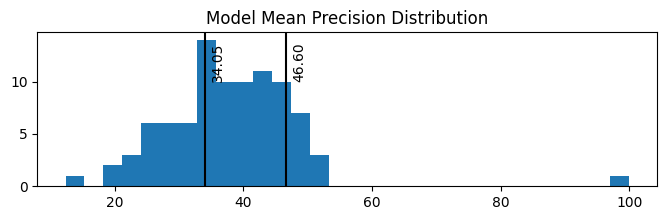

Number of models with mean recall up of 0: 0


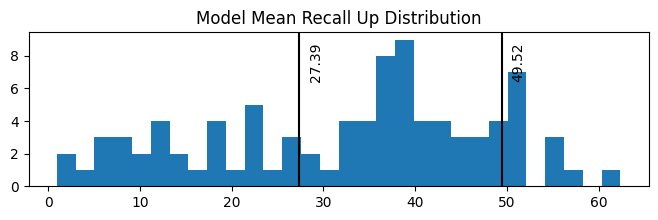

Number of models with ratio difference of 0: 1


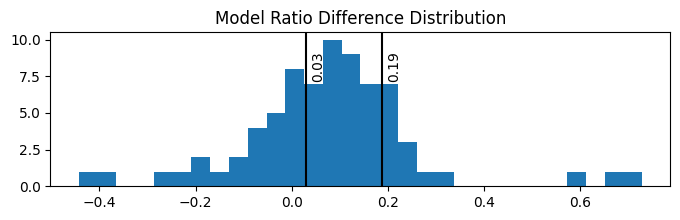

Number of models with FP Severe Ratio FPs of 0: 7


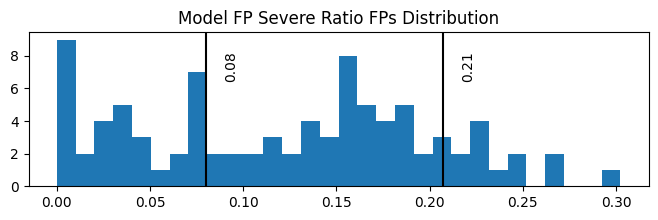

Number of models with FP Severe Ratio FPs and TPs of 0: 7


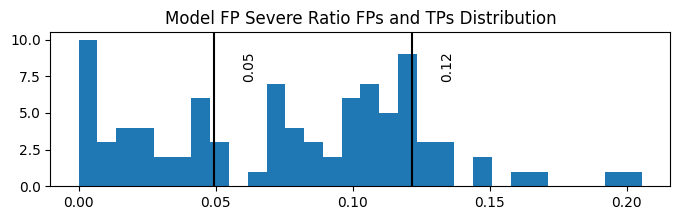

Number of seeds with precision of 0: 476


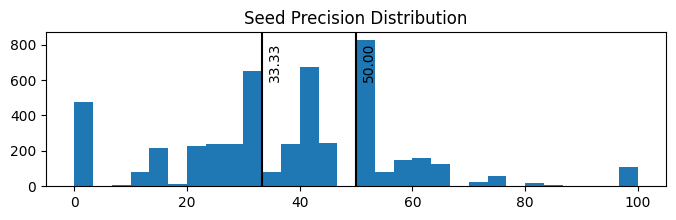

Number of seeds with recall of 0: 476


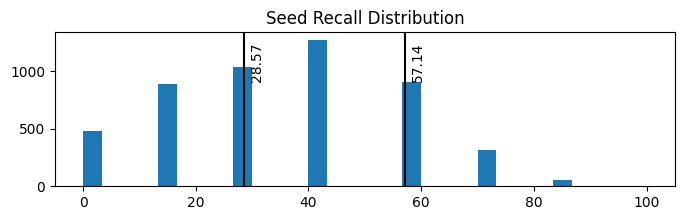

Number of seeds with TP minus FP of 0: 786


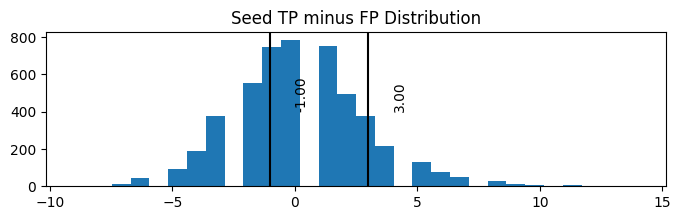

Number of seeds with severe FP high bracket of 0: 3780


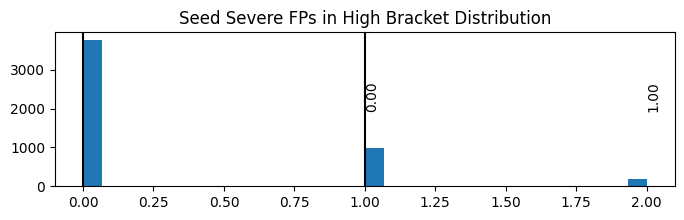

Number of seeds with TP high bracket of 0: 305


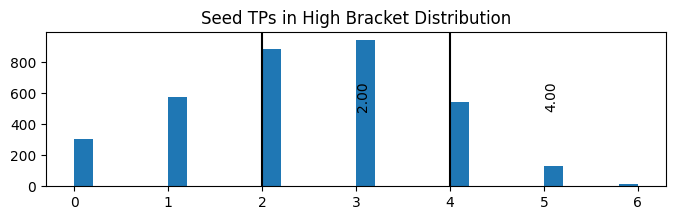

In [22]:
######             Plot the Dist for each variable metric, choose high, mid and low based on PERCENTILE RANGES
# this is better for standardizing across different data sets and time periods


selected_models = select_models_by_criteria(
    results_data=results_dist_disc,
    mean_precision_range=(0, 100),
    mean_recall_up_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(0, 100),
    min_seeds_per_model=1,
    max_models_to_return=len(results_dist_disc),  # include all; prevents sampling cap
    max_zero_precision_seeds=None,
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs=None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,
    random_seed=None,
)

###########                 MODEL METRICS DISTS


plt.figure(figsize=(8, 2))
mean_precision_list = [model['mean_precision'] for model in selected_models]
zero_count = sum(1 for mp in mean_precision_list if mp == 0)
print(f'Number of models with mean precision of 0: {zero_count}')
Mp_1q = np.percentile(mean_precision_list, 35)
Mp_2q = np.percentile(mean_precision_list, 85)
plt.hist(mean_precision_list, bins=30)

ax = plt.gca()              
x_min, x_max = ax.get_xlim() ; y_min, y_max = ax.get_ylim()

plt.text(Mp_1q + 1, y_max * 0.7, f'{Mp_1q:.2f}', rotation=90)
plt.text(Mp_2q + 1, y_max * 0.7, f'{Mp_2q:.2f}', rotation=90)
plt.axvline(x=Mp_1q, color='k')
plt.axvline(x=Mp_2q, color='k')
plt.title('Model Mean Precision Distribution')
plt.show()

# mean_recall_up
plt.figure(figsize=(8, 2))
mean_recall_up_list = [model['mean_recall_up'] for model in selected_models]
zero_count = sum(1 for mr in mean_recall_up_list if mr == 0)
print(f'Number of models with mean recall up of 0: {zero_count}')
Mr_1q = np.percentile(mean_recall_up_list, 35)
Mr_2q = np.percentile(mean_recall_up_list, 85)
plt.hist(mean_recall_up_list, bins=30)

ax = plt.gca()
x_min, x_max = ax.get_xlim() ; y_min, y_max = ax.get_ylim()
plt.text(Mr_1q + 1, y_max * 0.7, f'{Mr_1q:.2f}', rotation=90)
plt.text(Mr_2q + 1, y_max * 0.7, f'{Mr_2q:.2f}', rotation=90)
plt.axvline(x=Mr_1q, color='k')
plt.axvline(x=Mr_2q, color='k')
plt.title('Model Mean Recall Up Distribution')
plt.show()

# ratio_difference
plt.figure(figsize=(8, 2))
ratio_difference_list = [model['ratio_difference'] for model in selected_models if model['ratio_difference'] is not None]
zero_count = sum(1 for rd in ratio_difference_list if rd == 0)
print(f'Number of models with ratio difference of 0: {zero_count}')
Rd_1q = np.percentile(ratio_difference_list, 35)
Rd_2q = np.percentile(ratio_difference_list, 85)
plt.hist(ratio_difference_list, bins=30)
ax = plt.gca()              
x_min, x_max = ax.get_xlim() ; y_min, y_max = ax.get_ylim()
plt.text(Rd_1q + 0.01, y_max * 0.7, f'{Rd_1q:.2f}', rotation=90)
plt.text(Rd_2q + 0.01, y_max * 0.7, f'{Rd_2q:.2f}', rotation=90)
plt.axvline(x=Rd_1q, color='k')
plt.axvline(x=Rd_2q, color='k')
plt.title('Model Ratio Difference Distribution')
plt.show()

# fp_severe_ratio_fps
plt.figure(figsize=(8, 2))
fp_severe_ratio_fps_list = [model['fp_severe_ratio_fps'] for model in selected_models if model['fp_severe_ratio_fps'] is not None]
zero_count = sum(1 for fpr in fp_severe_ratio_fps_list if fpr == 0)
print(f'Number of models with FP Severe Ratio FPs of 0: {zero_count}')
Fpr_Fps_1q = np.percentile(fp_severe_ratio_fps_list, 35)
Fpr_Fps_2q = np.percentile(fp_severe_ratio_fps_list, 85)
plt.hist(fp_severe_ratio_fps_list, bins=30)
ax = plt.gca()              
x_min, x_max = ax.get_xlim() ; y_min, y_max = ax.get_ylim()
plt.text(Fpr_Fps_1q + 0.01, 0.7 * y_max, f'{Fpr_Fps_1q:.2f}', rotation=90)
plt.text(Fpr_Fps_2q + 0.01, 0.7 * y_max, f'{Fpr_Fps_2q:.2f}', rotation=90)
plt.axvline(x=Fpr_Fps_1q, color='k')
plt.axvline(x=Fpr_Fps_2q, color='k')
plt.title('Model FP Severe Ratio FPs Distribution')
plt.show()

# fp_severe_ratio_fps_tps
plt.figure(figsize=(8, 2))
fp_severe_ratio_fps_tps_list = [model['fp_severe_ratio_fps_tps'] for model in selected_models if model['fp_severe_ratio_fps_tps'] is not None]
zero_count = sum(1 for fpr in fp_severe_ratio_fps_tps_list if fpr == 0)
print(f'Number of models with FP Severe Ratio FPs and TPs of 0: {zero_count}')
Fpr_Fps_Tps_1q = np.percentile(fp_severe_ratio_fps_tps_list, 35)
Fpr_Fps_Tps_2q = np.percentile(fp_severe_ratio_fps_tps_list, 85)
plt.hist(fp_severe_ratio_fps_tps_list, bins=30)
ax = plt.gca()              
x_min, x_max = ax.get_xlim() ; y_min, y_max = ax.get_ylim()
plt.text(Fpr_Fps_Tps_1q + 0.01, 0.7 * y_max, f'{Fpr_Fps_Tps_1q:.2f}', rotation=90)
plt.text(Fpr_Fps_Tps_2q + 0.01, 0.7 * y_max, f'{Fpr_Fps_Tps_2q:.2f}', rotation=90)
plt.axvline(x=Fpr_Fps_Tps_1q, color='k')
plt.axvline(x=Fpr_Fps_Tps_2q, color='k')
plt.title('Model FP Severe Ratio FPs and TPs Distribution')
plt.show()

###########                 SEED METRICS DISTS

# seed_precision
plt.figure(figsize=(8, 2))
all_seed_precisions = []
for model in selected_models:
    for seed_result in model['selected_seeds']:
        all_seed_precisions.append(seed_result['precision'])
sp_1q = np.percentile(all_seed_precisions, 35)
sp_2q = np.percentile(all_seed_precisions, 85)
zero_count = sum(1 for sp in all_seed_precisions if sp == 0)
print(f'Number of seeds with precision of 0: {zero_count}')

plt.hist(all_seed_precisions, bins=30)
ax = plt.gca()              
x_min, x_max = ax.get_xlim() ; y_min, y_max = ax.get_ylim()
plt.text(sp_1q + 1, 0.7 * y_max, f'{sp_1q:.2f}', rotation=90)
plt.text(sp_2q + 1, 0.7 * y_max, f'{sp_2q:.2f}', rotation=90)
plt.axvline(x=sp_1q, color='k')
plt.axvline(x=sp_2q, color='k')
plt.title('Seed Precision Distribution')
plt.show()

# seed_recall
all_seed_recalls = []
for model in selected_models:
    for seed_result in model['selected_seeds']:
        all_seed_recalls.append(seed_result['recall'])
zero_count = sum(1 for sr in all_seed_recalls if sr == 0)
print(f'Number of seeds with recall of 0: {zero_count}')
sr_1q = np.percentile(all_seed_recalls, 35)
sr_2q = np.percentile(all_seed_recalls, 85)

plt.figure(figsize=(8, 2))
plt.hist(all_seed_recalls, bins=30)
ax = plt.gca()              
x_min, x_max = ax.get_xlim() ; y_min, y_max = ax.get_ylim()
plt.text(sr_1q + 1, 0.7 * y_max, f'{sr_1q:.2f}', rotation=90)
plt.text(sr_2q + 1, 0.7 * y_max, f'{sr_2q:.2f}', rotation=90)
plt.axvline(x=sr_1q, color='k')
plt.axvline(x=sr_2q, color='k')
plt.title('Seed Recall Distribution')
plt.show()


# seed_min_TPminusFP_greaterEqual

all_seed_TPminusFP=[]
for model in selected_models:
    for seed_result in model['selected_seeds']:

        bracket_high = seed_result["seed_bracket_counts"].get("0.7-1.0", {"TP": 0, "FP": 0})
        bracket_low = seed_result["seed_bracket_counts"].get("0.5-0.7", {"TP": 0, "FP": 0})

        net_high = bracket_high["TP"] - bracket_high["FP"]
        net_low = bracket_low["TP"] - bracket_low["FP"]
        TPminusFP = net_high - net_low
        all_seed_TPminusFP.append(TPminusFP)

zero_count = sum(1 for st in all_seed_TPminusFP if st == 0)
print(f'Number of seeds with TP minus FP of 0: {zero_count}')
s_TPminusFP_1q = np.percentile(all_seed_TPminusFP, 35)
s_TPminusFP_2q = np.percentile(all_seed_TPminusFP, 85)

plt.figure(figsize=(8, 2))
plt.hist(all_seed_TPminusFP, bins=30)

ax = plt.gca()              
x_min, x_max = ax.get_xlim() ; y_min, y_max = ax.get_ylim()
plt.text(s_TPminusFP_1q + 1, .5 * y_max, f'{s_TPminusFP_1q:.2f}', rotation=90)
plt.text(s_TPminusFP_2q + 1, .5 * y_max, f'{s_TPminusFP_2q:.2f}', rotation=90)
plt.axvline(x=s_TPminusFP_1q, color='k')
plt.axvline(x=s_TPminusFP_2q, color='k')
plt.title('Seed TP minus FP Distribution')
plt.show()


# max_seed_severe_FPs_high_bracket
all_seed_severe_FPs_high_bracket = []
for model in selected_models:
    for seed_result in model['selected_seeds']:
        all_seed_severe_FPs_high_bracket.append(seed_result['seed_severe_fp_high_bracket'])
zero_count = sum(1 for sr in all_seed_severe_FPs_high_bracket if sr == 0)
print(f'Number of seeds with severe FP high bracket of 0: {zero_count}')

s_severeFPs_H_1q = np.percentile(all_seed_severe_FPs_high_bracket, 35)
s_severeFPs_H_2q = np.percentile(all_seed_severe_FPs_high_bracket, 85)

plt.figure(figsize=(8, 2))
plt.hist(all_seed_severe_FPs_high_bracket, bins=30)

ax = plt.gca()              
x_min, x_max = ax.get_xlim() ; y_min, y_max = ax.get_ylim()

plt.text(s_severeFPs_H_1q + 1, .5 * y_max, f'{s_severeFPs_H_1q:.2f}', rotation=90)
plt.text(s_severeFPs_H_2q + 1, .5 * y_max, f'{s_severeFPs_H_2q:.2f}', rotation=90)
plt.axvline(x=s_severeFPs_H_1q, color='k')
plt.axvline(x=s_severeFPs_H_2q, color='k')
plt.title('Seed Severe FPs in High Bracket Distribution')
plt.show()

# min_seed_TPs_high_bracket

all_seed_TPs_high_bracket = []

for model in selected_models:
    for seed_result in model['selected_seeds']:
        if "0.7-1.0" in seed_result['seed_bracket_counts']:

            all_seed_TPs_high_bracket.append(seed_result['seed_bracket_counts']["0.7-1.0"]["TP"])

zero_count = sum(1 for st in all_seed_TPs_high_bracket if st == 0)
print(f'Number of seeds with TP high bracket of 0: {zero_count}')
s_TPs_H_1q = np.percentile(all_seed_TPs_high_bracket, 35)
s_TPs_H_2q = np.percentile(all_seed_TPs_high_bracket, 85)

plt.figure(figsize=(8, 2))
plt.hist(all_seed_TPs_high_bracket, bins=30)
ax = plt.gca()              
x_min, x_max = ax.get_xlim() ; y_min, y_max = ax.get_ylim()
plt.text(s_TPs_H_1q + 1, .5 * y_max, f'{s_TPs_H_1q:.2f}', rotation=90)
plt.text(s_TPs_H_2q + 1, .5 * y_max, f'{s_TPs_H_2q:.2f}', rotation=90)
plt.axvline(x=s_TPs_H_1q, color='k')
plt.axvline(x=s_TPs_H_2q, color='k')
plt.title('Seed TPs in High Bracket Distribution')
plt.show()


In [23]:
brackets = [(0.5, 0.6), (0.6, 0.65), (0.65, 0.7), (0.7, 0.75), 
            (0.75, 0.8), (0.8, 0.85), (0.85, 0.9), (0.9, 0.95), (0.95, 1)]

metrics = ["precision_up", "recall_up", "accuracy"]


# ---- collect per-model data and compute precision_up mean for ordering ----
model_summaries = []  # (prec_mean, combo_idx, collected_dict, parameters, per_seed)

for model in results_dist_disc:
    combo_idx = model["combo_index"]
    parameters = model["combo"]
    per_seed = model["per_seed_all_results"]

    collected = {k: [] for k in metrics}
    for run in per_seed:
        om = run["result_entry"]["cv_sets"]["overall_metrics"]
        for k in metrics:
            v = om[k]
            try:
                collected[k].append(float(v))
            except (TypeError, ValueError):
                collected[k].append(None)

    vals_prec = [x for x in collected["precision_up"] if isinstance(x, (int, float)) and not (isinstance(x, float) and math.isnan(x))]
    prec_mean = float(np.mean(vals_prec)) if vals_prec else float("nan")


    model_summaries.append((prec_mean, combo_idx, collected, parameters, per_seed))

# sort as before
model_summaries.sort(key=lambda t: (-t[0]) if not math.isnan(t[0]) else float("inf"))




##############################

model_summaries_Tset_same_seeds = []  # (prec_mean, combo_idx, collected_dict, parameters, per_seed)

for model in results_dist_disc_Tset_same_seeds_organized:
    combo_idx = model["combo_index"]
    parameters = model["combo"]
    per_seed = model["per_seed_all_results"]

    collected = {k: [] for k in metrics}
    for run in per_seed:
        om = run["result_entry"]["cv_sets"]["overall_metrics"]
        for k in metrics:
            v = om[k]
            try:
                collected[k].append(float(v))
            except (TypeError, ValueError):
                collected[k].append(None)

    vals_prec = [x for x in collected["precision_up"] if isinstance(x, (int, float)) and not (isinstance(x, float) and math.isnan(x))]
    prec_mean = float(np.mean(vals_prec)) if vals_prec else float("nan")

    # ⬇️ add per_seed in the tuple
    model_summaries_Tset_same_seeds.append((prec_mean, combo_idx, collected, parameters, per_seed))

# sort as before
model_summaries_Tset_same_seeds.sort(key=lambda t: (-t[0]) if not math.isnan(t[0]) else float("inf"))



{'binary_0_1_cutoff_ret_rate_percentage': 0.1, 'learning_rate': 0.05, 'num_epochs': 300, 'batch_size': 70, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 35, 'num_layers': 6, 'use_monthly_dfs_only': True, 'use_binary_0_1_retRate': False, 'use_custom_loss_function_BCE_THRESH': False, 'use_custom_loss_function_BCE_THRESH_AND_SEVERITY': False, 'use_LOW_weights_for_BCE_custom_loss': True, 'pred_threshold_sigmoid01_up': None, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': False, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 60607, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_binary_0_1_retRate_custom_neg': False, 'use_binary_0_1_retRate_custom_pos': True, 'POS_weight_multiplier': 1.3, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None, 'use_USO_wticoncat_predictor_WEEKLY_END_MO': False, 'use_UCO_wticoncat_predictor_WEEKLY_END_MO': Tru

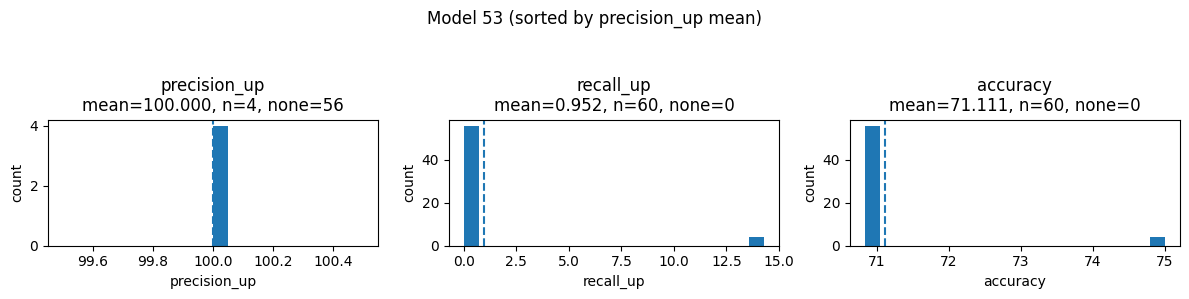

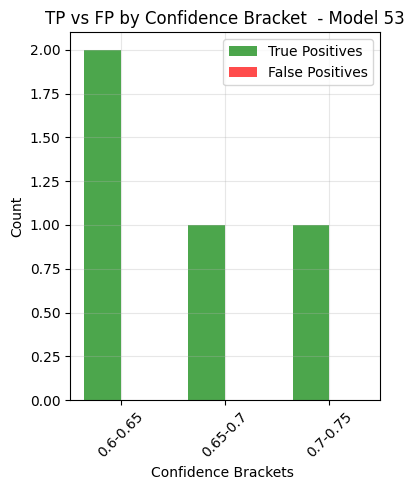

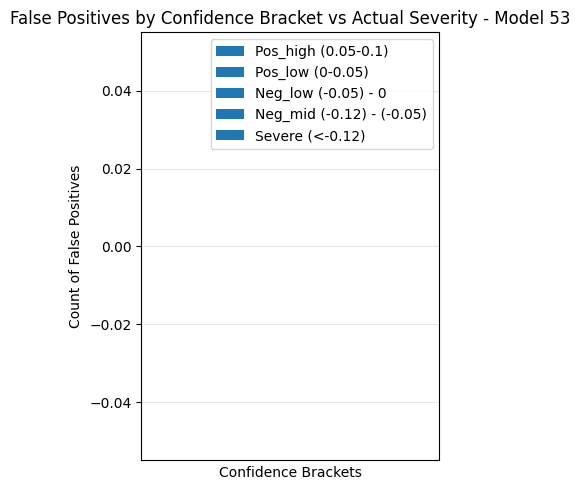

Severe Case Proportions by Confidence Bracket:
--------------------------------------------------
Severity Counts by Confidence Bracket:
--------------------------------------------------


In [24]:




LENGTH = 1
# ---- plot in the sorted order ----
for prec_mean, combo_idx, collected, parameters, per_seed in model_summaries[:LENGTH]:
    fig, axes = plt.subplots(1, len(metrics), figsize=(12, 3), squeeze=False)
    axes = axes[0]

    print(parameters)

    for ax, k in zip(axes, metrics):
        vals = [x for x in collected[k] if isinstance(x, (int, float)) and not (isinstance(x, float) and math.isnan(x))]
        none_cnt = len(collected[k]) - len(vals)

        if vals:
            mean_val = float(np.mean(vals))
            ax.hist(vals, bins=20)
            ax.axvline(mean_val, linestyle="--")
            ax.set_xlabel(k)
            ax.set_ylabel("count")
            ax.set_title(f"{k}\nmean={mean_val:.3f}, n={len(vals)}, none={none_cnt}")
        else:
            ax.text(0.5, 0.5, f"No data\nnone={none_cnt}", ha="center", va="center")
            ax.set_xticks([]); ax.set_yticks([]); ax.set_title(k)

    fig.suptitle(f"Model {combo_idx} (sorted by precision_up mean)", fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

    # =================== NEW: per-model correlation-threshold + severity plots ===================

    # Recycle your functions by making a "top-like" list from this model's seeds
    # Each item: (score_unused, entry=result_entry)
    top_like_for_this_model = [(0.0, run["result_entry"]) for run in per_seed]

    # Correlation / confidence bracket plot for THIS model
    TP_FP_brackets_analysis(top_like_for_this_model, brackets, f"Model {combo_idx}")

    # Severity plot for THIS model
    TP_FP_brackets_severity_analysis(top_like_for_this_model, brackets, f"Model {combo_idx}")







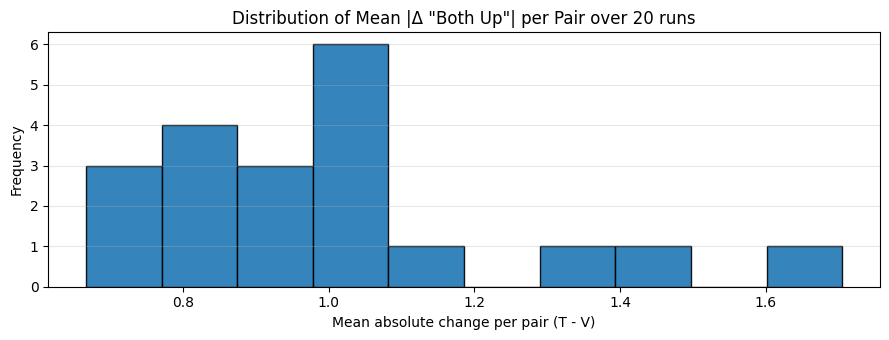

Runs: 20 | Valid: 20 | NaNs: 0
Mean=0.991 | Median=0.976 | Std=0.248 | Min=0.667 | Max=1.705


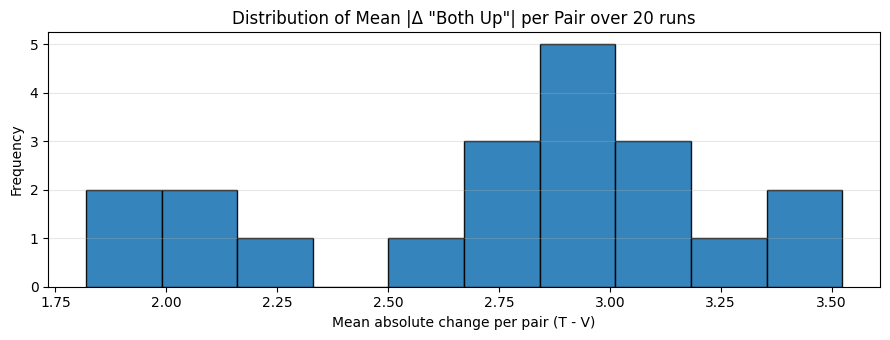

Runs: 20 | Valid: 20 | NaNs: 0
Mean=2.757 | Median=2.852 | Std=0.483 | Min=1.819 | Max=3.524


In [25]:
##### RECALL AND MODEL CORRELATION IN V vs T set Assesment 

import copy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Results_Dists_V_2 import *

### NOTE consider changing this os that the function chooses the max number of midels possible , this should imporve the resutls in general since 
### seeds of the same model are generally more correalted --- this can also be tested but i am pretty positive this is the case (ran short tests)

### NOTE for now since we want to test the params for model slection , it may be better to keep it as is for standardization

def collect_V_T_set_FULLraw_data(models_selected, results_dist_disc, results_dist_disc_Tset_same_seeds_organized):
    T_set_data = [] 
    V_set_data = []

    # select 5 models at random from the selected models
    models_RAND = random.sample(models_selected, min(15, len(models_selected)))

    for model_entry in models_RAND:
        model_seeds = []
        ff_combo_idx = model_entry['combo_index']
        for seed_entry in model_entry['selected_seeds']:
            seed_num = seed_entry['seed_num']
            model_seeds.append(seed_num)

        ##### Find randomly chosen seeds in the V and T raw data 
        for raw_data_entry_V in results_dist_disc:
            V_combo_idx = raw_data_entry_V["combo_index"]
            if ff_combo_idx == V_combo_idx:
                rand_chosen_seeds = random.sample(model_seeds, min(1, len(model_seeds)))
                for seed_chosen in rand_chosen_seeds:
                    for seed_raw in raw_data_entry_V['per_seed_all_results']:
                        if seed_raw['seed'] == seed_chosen:
                            V_set_data.append(seed_raw['result_entry'])

        for raw_data_entry_T in results_dist_disc_Tset_same_seeds_organized:
            T_combo_idx = raw_data_entry_T["combo_index"]
            if ff_combo_idx == T_combo_idx:
                for seed_chosen in rand_chosen_seeds:
                    for seed_raw in raw_data_entry_T['per_seed_all_results']:
                        if seed_raw['seed'] == seed_chosen:
                            T_set_data.append(seed_raw['result_entry'])

    return {"V_set_data": V_set_data, "T_set_data": T_set_data}


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# res = collect_V_T_set_FULLraw_data(Mp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# V_set_data = res["V_set_data"] ; T_set_data = res["T_set_data"]
# print(len(V_set_data)) ; print(len(T_set_data))  


def plot_model_corr(master_df,  output_plot : bool ,machine="mac", set_type="V", use_spearman=True, use_01_preds=False ):
    """
    Plots correlation and matching-parameter counts for models
    from a given machine ('mac' or 'gc') and set type ('V' or 'T'),
    using the param_int_Vue column as the unique model ID.
    
    Returns: Dictionary with keys as model pairs (tuple) and values as (same_params_count, correlation, both_up_count)
    """
    # Dynamic column names
    preds_col  = f"all_preds_{machine}_{set_type}"
    params_col = f"parameters_{machine}_{set_type}"
    id_col     = f"param_int_Vue_{machine}_{set_type}"  # unique model integer

    # Extract relevant rows
    block = master_df[[preds_col, params_col, id_col]].reset_index(drop=True)
    if block.empty:
        raise ValueError(f"No data found for machine '{machine}' and set '{set_type}'.")

    # 1. Flatten predictions and get model IDs
    all_preds_list = []
    model_ids = []
    
    for idx, preds in enumerate(block[preds_col]):
        flat = [p for fold in preds for p in fold]  # flatten folds
        if use_01_preds:
            flat = [1 if p >= 0.5 else -1 for p in flat]  # binary conversion
        all_preds_list.append(flat)
        model_ids.append(int(block.iloc[idx][id_col]))

    labels = [f"Model_{mid}" for mid in model_ids]
    n_models = len(all_preds_list)
    n_samples = len(all_preds_list[0])  # number of predictions per model

    # 2. Correlation matrix - unified approach
    corr = np.zeros((n_models, n_models))
    both_up_counts = np.zeros((n_models, n_models), dtype=int)  # New: count of both predicting up
    
    for i in range(n_models):
        for j in range(n_models):
            if i <= j:  # Calculate only once for each pair
                # Correlation
                if use_spearman:
                    rho, _ = spearmanr(all_preds_list[i], all_preds_list[j])
                else:
                    rho = np.corrcoef(all_preds_list[i], all_preds_list[j])[0, 1]
                corr[i, j] = rho
                corr[j, i] = rho  # Symmetric matrix
                
                # Count both predicting up (>=0.5) at the same time
                if not use_01_preds:
                    # Convert to binary for counting both up (only if not already in 0/1 form)
                    preds_i_bin = [1 if p >= 0.5 else 0 for p in all_preds_list[i]]
                    preds_j_bin = [1 if p >= 0.5 else 0 for p in all_preds_list[j]]
                else:
                    # Already in binary form: 1 for up, -1 for down (so convert -1 to 0)
                    preds_i_bin = [1 if p == 1 else 0 for p in all_preds_list[i]]
                    preds_j_bin = [1 if p == 1 else 0 for p in all_preds_list[j]]
                
                count_both_up = sum((a == 1) and (b == 1) for a, b in zip(preds_i_bin, preds_j_bin))
                both_up_counts[i, j] = count_both_up
                both_up_counts[j, i] = count_both_up  # Symmetric

    corr_df = pd.DataFrame(corr, index=labels, columns=labels)
    both_up_df = pd.DataFrame(both_up_counts, index=labels, columns=labels)  # DataFrame for both_up counts

    # 3. Matching parameter counts
    keys_to_check = [
        "learning_rate", "num_epochs", "batch_size", "lag",
        "num_layers", "input_size", "use_rolling_fixed_train_size",
        "hidden_size", "use_class_weighting", "use_dropout", 
        "use_custom_loss_function_BCE_THRESH", "train_start_month", "seed"
    ]
    params_list = block[params_col].tolist()
    match_counts = np.zeros((n_models, n_models), dtype=int)

    for i in range(n_models):
        for j in range(n_models):
            p1, p2 = params_list[i], params_list[j]
            if not isinstance(p1, dict) or not isinstance(p2, dict):
                continue
            match_counts[i, j] = sum(p1.get(k) == p2.get(k) for k in keys_to_check)

    match_df = pd.DataFrame(match_counts, index=labels, columns=labels)

    # 4. Annotated heatmap: now with three metrics
    annot = corr_df.round(2).astype(str) + " | " + match_df.astype(str) + " | " + both_up_df.astype(str)
    
    correlation_type = "Spearman" if use_spearman else "Pearson"
    
    if output_plot:
            
        plt.figure(figsize=(22, 7))
        sns.heatmap(
            corr_df,
            annot=annot,
            fmt="",
            cmap="coolwarm",
            vmin=-1, vmax=1,
            cbar_kws={'label': f'{correlation_type} Correlation'}
        )
        plt.title(f"Model {correlation_type} Correlation | Matching Params | Both Up Count — {machine.upper()} ({set_type})")
        plt.tight_layout()
        plt.show()

    # 5. Create return data: dictionary with keys as model pairs and values as (same_params, correlation, both_up_count)
    return_data = {}
    for i in range(n_models):
        for j in range(i + 1, n_models):  # Only unique pairs, avoid self-comparisons and duplicates
            model_pair = (model_ids[i], model_ids[j])
            same_params = match_counts[i, j]
            correlation = corr[i, j]
            both_up = both_up_counts[i, j]
            return_data[model_pair] = (same_params, correlation, both_up)

    return return_data



def _mean_abs_pair_change(corr_res_V, corr_res_T):
    """
    corr_res_*: dict[(id1, id2)] -> (same_params, correlation, both_up_count)
    Returns the mean |Δ both_up| across common model pairs (size-agnostic).
    """
    pairs_V = set(corr_res_V.keys())
    pairs_T = set(corr_res_T.keys())
    common_pairs = pairs_V & pairs_T
    if not common_pairs:
        return np.nan

    diffs = []
    for pair in common_pairs:
        v_b = corr_res_V[pair][2] or 0
        t_b = corr_res_T[pair][2] or 0
        diffs.append(abs(int(t_b) - int(v_b)))
    return float(np.mean(diffs))

def _one_realization(RR, threshold=0.7):
    """
    Runs a single realization:
      - select models
      - build V/T sets
      - add metrics
      - compute corr (V and T)
      - return mean |Δ both_up| per common pair
    """
    models = select_models_by_criteria(results_dist_disc, **RR)
    if not models:
        return np.nan

    res = collect_V_T_set_FULLraw_data(models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    V, T = res["V_set_data"], res["T_set_data"]
    if not V or not T:
        return np.nan

    # add metrics at one place
    for data in (V, T):
        add_threshold_metrics(data, threshold=threshold)

    df_V = flatten_results(V)
    df_T = flatten_results(T)
    dfs = [df_V, df_T]

    add_up_prediction_counts(dfs)
    add_false_correct_up_stats(dfs)
    flatten_metrics_columns(dfs)
    master_df = process_parameters_and_merge(dfs)

    corr_res_V = plot_model_corr(master_df, machine="mac", set_type="V",
                                 use_spearman=False, use_01_preds=False, output_plot=False)
    corr_res_T = plot_model_corr(master_df, machine="mac", set_type="T",
                                 use_spearman=False, use_01_preds=False, output_plot=False)

    return _mean_abs_pair_change(corr_res_V, corr_res_T)

def run_repeated_abs_diff_experiment(RR_base, n_runs=20, seed_start=0, threshold=0.7, show_plot=True):
    """
    Repeats the selection + evaluation 'n_runs' times with different random seeds,
    collects the mean |Δ both_up| per common pair each time, and (optionally) plots a histogram.
    Returns: np.ndarray of shape (n_runs,)
    """
    diffs = []
    for k in range(n_runs):
        RR = copy.deepcopy(RR_base)
        RR["random_seed"] = (seed_start + k)
        diff = _one_realization(RR, threshold=threshold)
        diffs.append(diff)

    diffs = np.asarray(diffs, dtype=float)

    if show_plot:
        plt.figure(figsize=(9, 3.5))
        # integer-ish binning but robust for NaNs
        valid = diffs[~np.isnan(diffs)]
        if valid.size == 0:
            print("No valid runs to plot.")
        else:
            max_abs = max(1.0, np.ceil(valid.max()))

            plt.hist(valid, bins=10, alpha=0.9, edgecolor="black")
            plt.title(f'Distribution of Mean |Δ "Both Up"| per Pair over {valid.size} runs')
            plt.xlabel('Mean absolute change per pair (T - V)')
            plt.ylabel('Frequency')
            plt.grid(True, axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()

        print(f"Runs: {n_runs} | Valid: {valid.size} | NaNs: {np.isnan(diffs).sum()}")
        if valid.size:
            print(f"Mean={valid.mean():.3f} | Median={np.median(valid):.3f} | Std={valid.std(ddof=0):.3f} | "
                  f"Min={valid.min():.3f} | Max={valid.max():.3f}")

    return diffs



RR_1 = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "mean_recall_up_range" : (0, 30),
                             "seed_recall_range" : (0, 30),
                             "seed_precision_range" : (0, 30) , 

                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,

                              "min_seeds_per_model" : 1,
                             "max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

RR_2 = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "mean_recall_up_range" : (30, 100),
                             "seed_recall_range" : (30, 100),


                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (0, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,

                              "min_seeds_per_model" : 1,
                             "max_models_to_return" : 90, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

# ---- Example usage ----

diffs = run_repeated_abs_diff_experiment(RR_base=RR_1, n_runs=20, seed_start=0, threshold=0.7, show_plot=True)
diffs = run_repeated_abs_diff_experiment(RR_base=RR_2, n_runs=20, seed_start=0, threshold=0.7, show_plot=True)


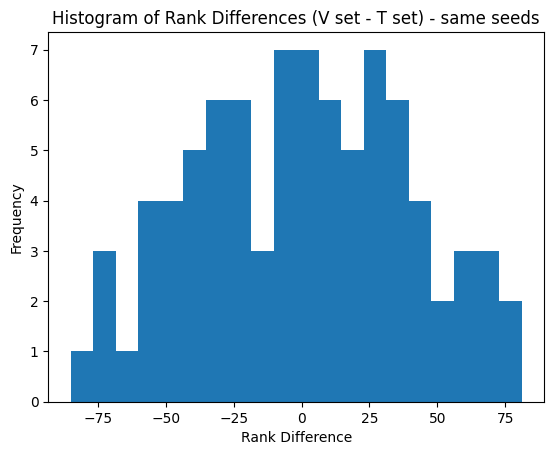

87

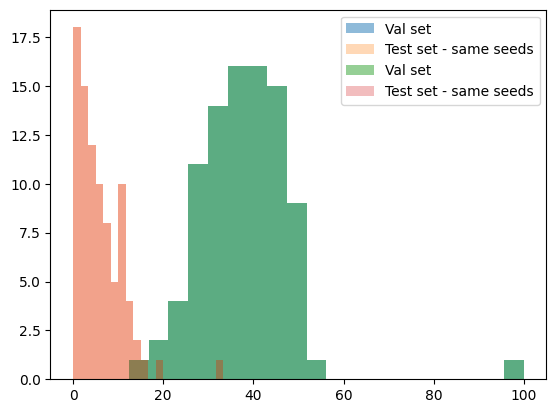

In [26]:



model_summaries_combo_idxs = [t[1] for t in model_summaries]
model_summaries_combo_idxs_Tset_same_seeds = [t[1] for t in model_summaries_Tset_same_seeds]


model_summaries_mean_V = [i[0] for i in model_summaries]
model_summaries_mean_T_same_seeds = [i[0] for i in model_summaries_Tset_same_seeds]


# for i , j in zip(model_summaries_combo_idxs_Tset, model_summaries_combo_idxs):
#  print(i , j)



###################################### with same seeds

list_ranks_coupled_V_T_same_seeds = []
for rank , (T_idx , V_idx , T_mean , V_mean) in enumerate(zip( model_summaries_combo_idxs_Tset_same_seeds, model_summaries_combo_idxs , model_summaries_mean_T_same_seeds , model_summaries_mean_V )):
    if not (np.isfinite(T_mean) and np.isfinite(V_mean)):
        continue
    dic = {"rank_V" : rank , "combo_idx_val_V" : V_idx , "rank_T" : rank , "combo_idx_val_T" : T_idx  , "mean_V" : V_mean , "mean_T" : T_mean  }
    list_ranks_coupled_V_T_same_seeds.append(dic)


for out in list_ranks_coupled_V_T_same_seeds:
    matched = False
    for inner in list_ranks_coupled_V_T_same_seeds:
        if out["combo_idx_val_V"] == inner["combo_idx_val_T"]:
            out["rank_diff"] = inner["rank_T"] - out["rank_V"]
            out["mean_diff"] = inner["mean_T"] - out["mean_V"]
            out["new_mean_T"] = inner["mean_T"]
            matched = True
            break  # found the pair; no need to keep scanning
    if not matched:
        # no counterpart found → set safe defaults to avoid KeyError later
        out["rank_diff"] = np.nan
        out["mean_diff"] = np.nan
        out["new_mean_T"] = np.nan

rank_diffs = [i["rank_diff"] for i in list_ranks_coupled_V_T_same_seeds]
mean_diffs = [i["mean_diff"] for i in list_ranks_coupled_V_T_same_seeds]


plt.hist(rank_diffs , bins=20)
plt.title("Histogram of Rank Differences (V set - T set) - same seeds")
plt.xlabel("Rank Difference")
plt.ylabel("Frequency")
plt.show()



plt.hist(model_summaries_mean_V , bins=20 , alpha = 0.5 , label = "Val set")
plt.hist(model_summaries_mean_T_same_seeds , bins=20 , alpha = 0.3 , label = "Test set - same seeds")
plt.legend()



#### 

plt.hist(model_summaries_mean_V , bins=20 , alpha = 0.5 , label = "Val set")
plt.hist(model_summaries_mean_T_same_seeds , bins=20 , alpha = 0.3 , label = "Test set - same seeds")
plt.legend()

len(list_ranks_coupled_V_T_same_seeds)




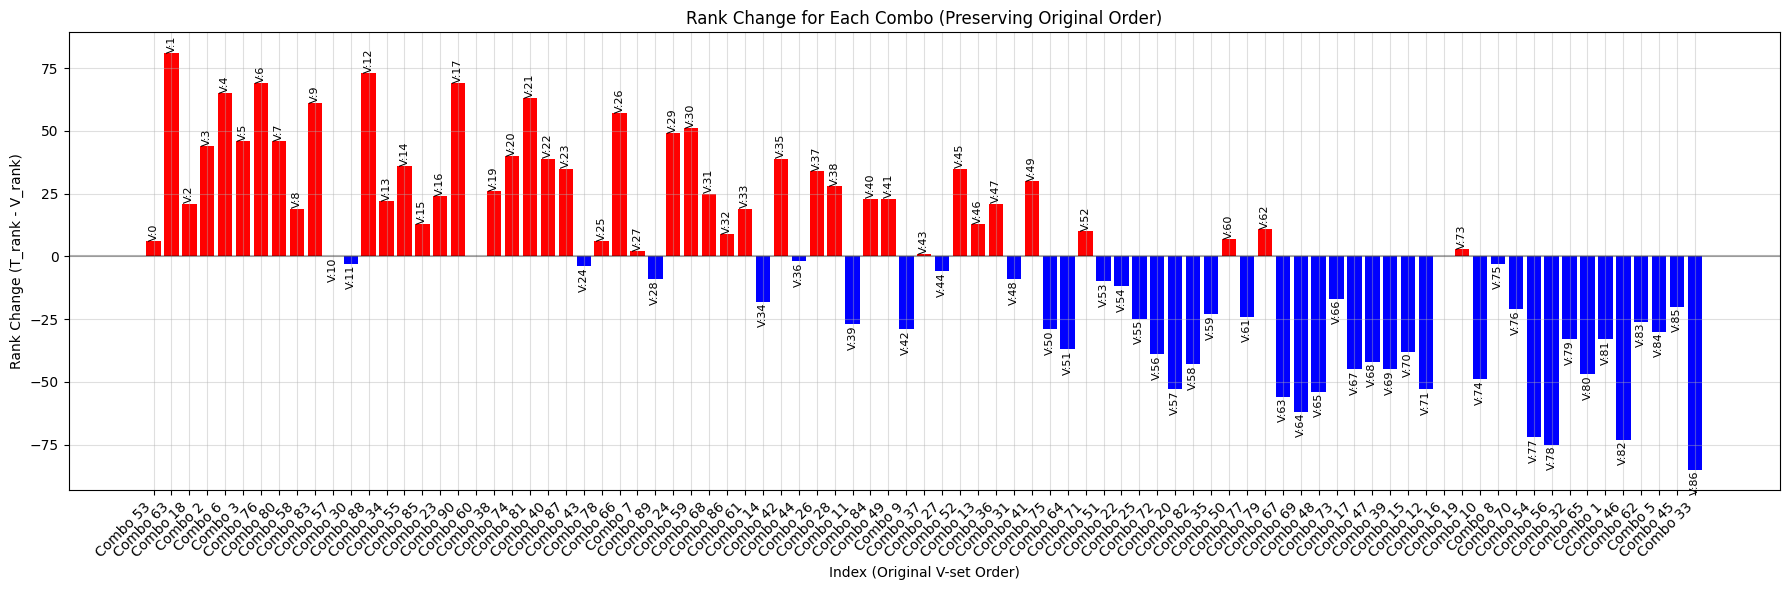

In [27]:
# Use the list_ranks_coupled in the order it was created (same as V set order)
combos = [f"Combo {item['combo_idx_val_V']}" for item in list_ranks_coupled_V_T_same_seeds]
changes = [item["rank_diff"] for item in list_ranks_coupled_V_T_same_seeds]
v_ranks = [item["rank_V"] for item in list_ranks_coupled_V_T_same_seeds]

plt.figure(figsize=(18, 6))
bars = plt.bar(range(len(combos)), changes, 
               color=np.where(np.array(changes) > 0, 'red', 'blue'))

plt.xlabel('Index (Original V-set Order)')
plt.ylabel('Rank Change (T_rank - V_rank)')
plt.title('Rank Change for Each Combo (Preserving Original Order)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add V rank labels for reference
for i, (bar, v_rank) in enumerate(zip(bars, v_ranks)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if bar.get_height() > 0 else -0.4), 
             f'V:{v_rank}', ha='center', va='bottom' if bar.get_height() > 0 else 'top', 
             fontsize=8, rotation=90)
plt.grid(True , alpha=0.4)
plt.xticks(range(len(combos)), combos, rotation=45, ha='right')
plt.tight_layout()
plt.show()

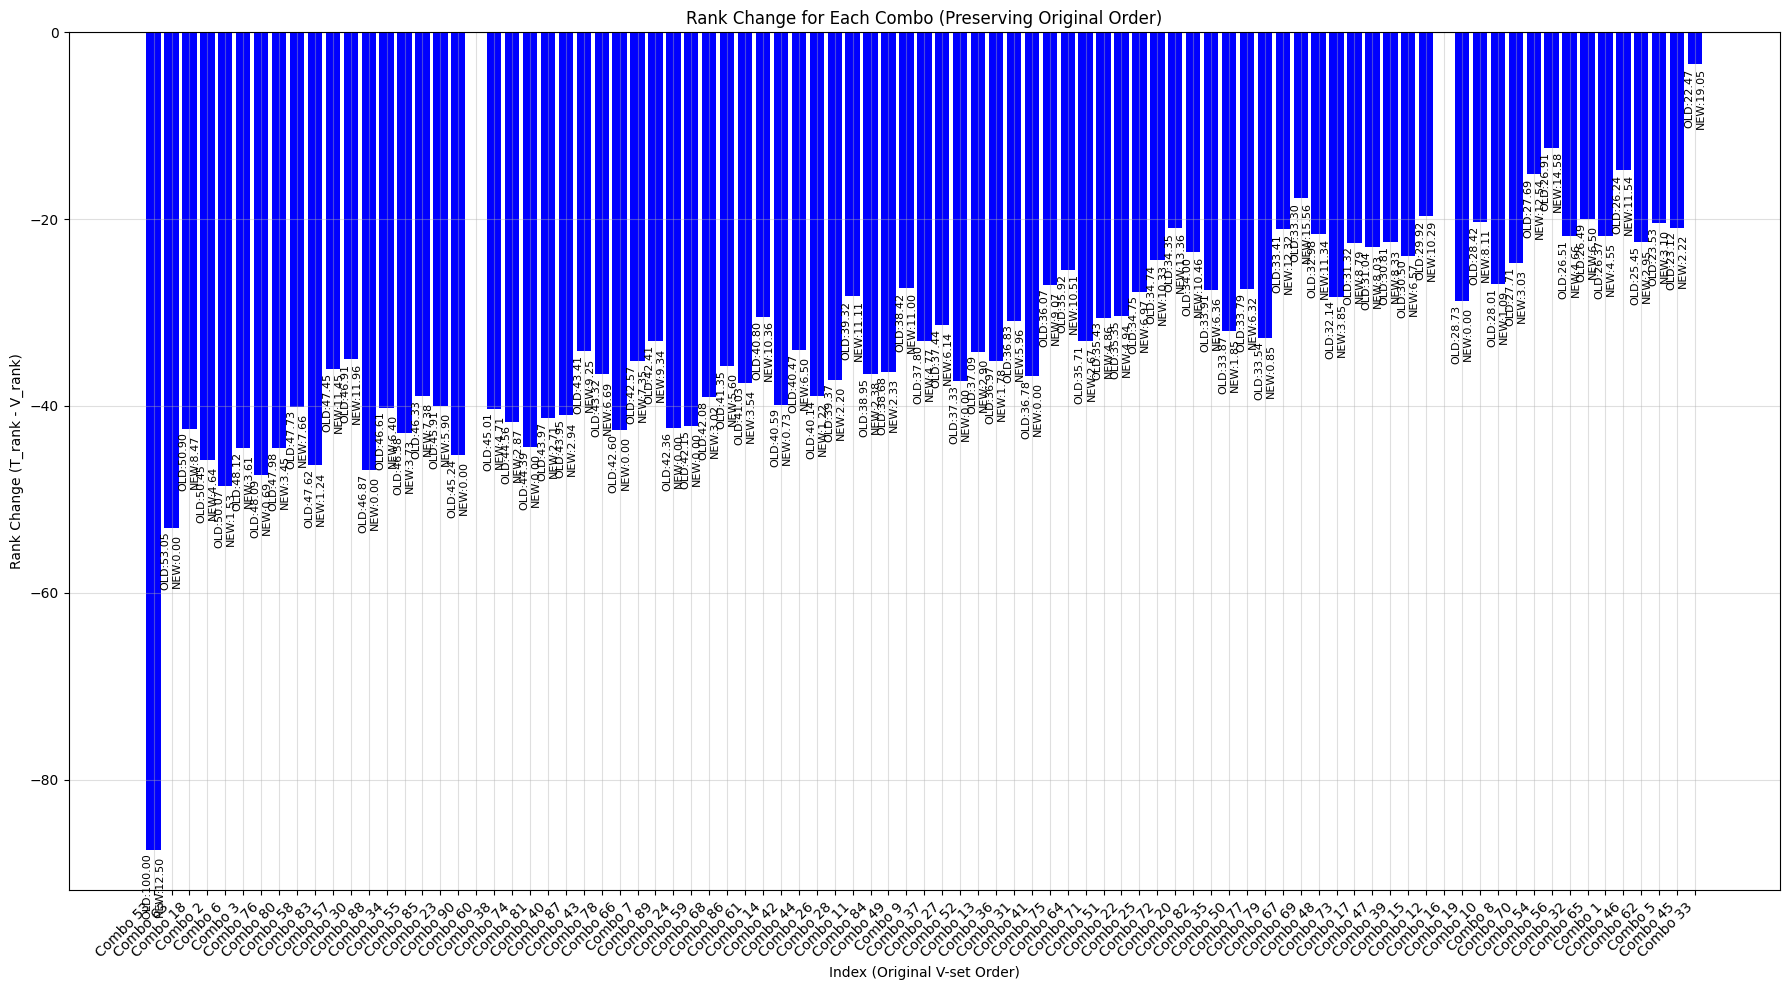

In [28]:
# Use the list_ranks_coupled in the order it was created (same as V set order)
combos = [f"Combo {item['combo_idx_val_V']}" for item in list_ranks_coupled_V_T_same_seeds]
changes = [item["mean_diff"] for item in list_ranks_coupled_V_T_same_seeds]
v_ranks = [item["rank_V"] for item in list_ranks_coupled_V_T_same_seeds]
v_mean = [item["mean_V"] for item in list_ranks_coupled_V_T_same_seeds]
v_new_mean = [item["new_mean_T"] for item in list_ranks_coupled_V_T_same_seeds]

plt.figure(figsize=(18, 10))
bars = plt.bar(range(len(combos)), changes, 
               color=np.where(np.array(changes) > 0, 'red', 'blue'))

plt.xlabel('Index (Original V-set Order)')
plt.ylabel('Rank Change (T_rank - V_rank)')
plt.title('Rank Change for Each Combo (Preserving Original Order)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add V rank labels for reference
for i, (bar, v_rank, v_mean_val, v_new_mean_val) in enumerate(zip(bars, v_ranks , v_mean , v_new_mean)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if bar.get_height() > 0 else -0.4), 
             f'OLD:{v_mean_val:.2f}\nNEW:{v_new_mean_val:.2f}', ha='center', va='bottom' if bar.get_height() > 0 else 'top', 
             fontsize=8, rotation=90)
plt.grid(True , alpha=0.4)
plt.xticks(range(len(combos)), combos, rotation=45, ha='right')
plt.tight_layout()
plt.show()

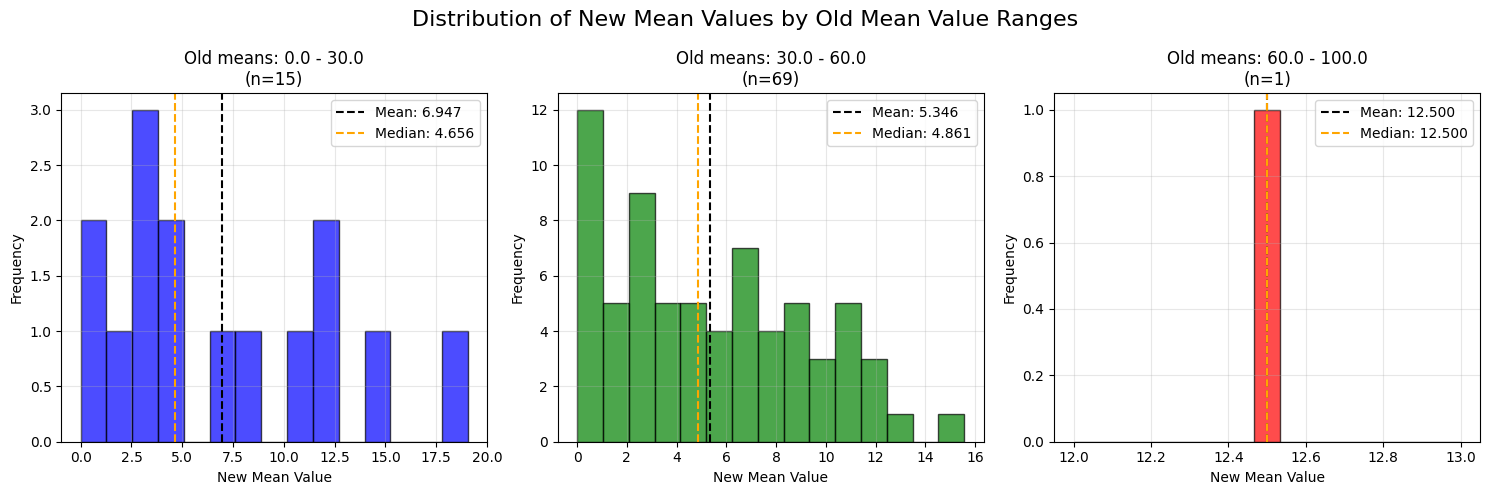

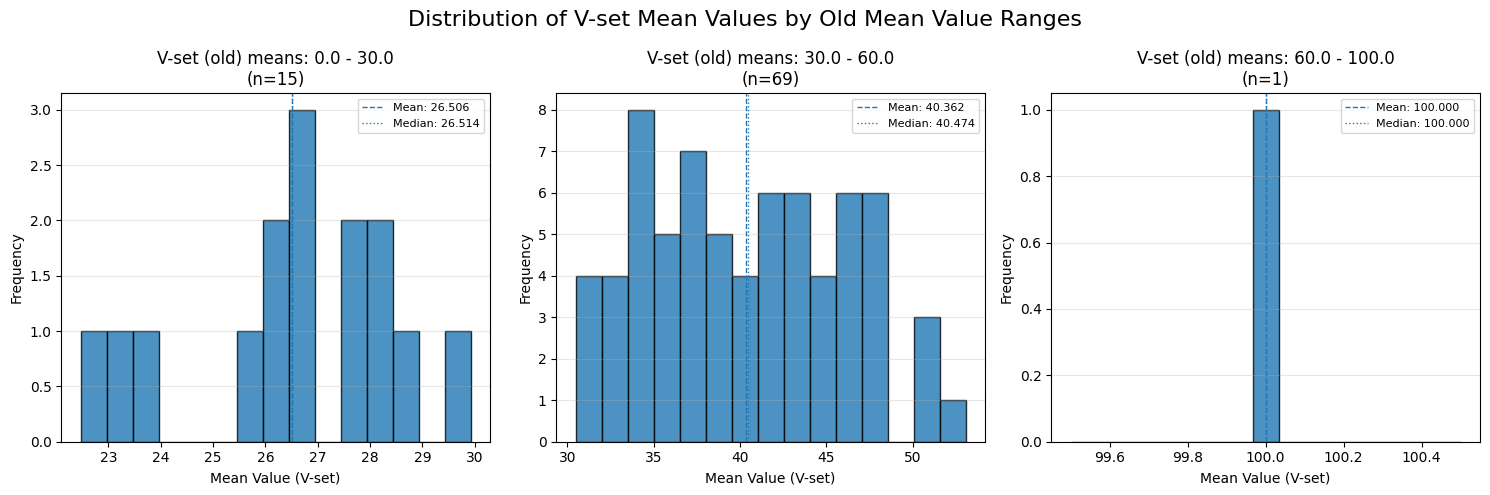

/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_34246/3780539703.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_new_means, labels=all_labels)


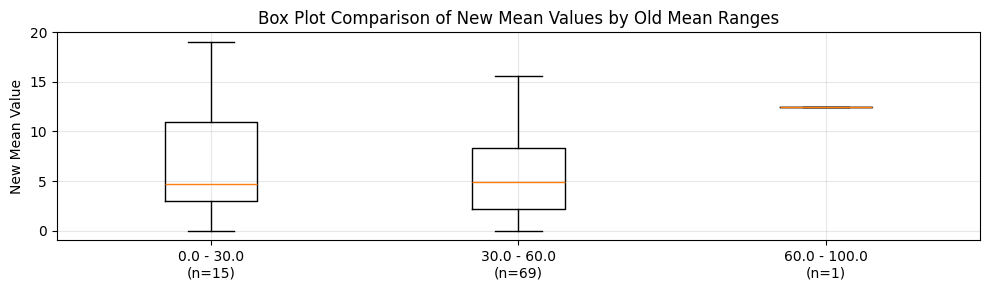

In [29]:

####*#**#*#*# Sanity check for functions below --- keep 


import numpy as np
import matplotlib.pyplot as plt

# Extract & sanitize inputs
old = np.asarray(v_mean, dtype=float)
new = np.asarray(v_new_mean, dtype=float)

# 1) Drop NaN/Inf in lockstep (keep only pairs where both are finite)
valid = np.isfinite(old) & np.isfinite(new)
old = old[valid]
new = new[valid]

# Define the ranges
ranges = [(0, 30), (30, 60), (60, 100)]
range_labels = ['0.0 - 30.0', '30.0 - 60.0', '60.0 - 100.0']
colors = ['blue', 'green', 'red']  # optional

# ----------------- Figure 1: T-set (new) distributions per OLD-mean range -----------------
plt.figure(figsize=(15, 5))
for i, (range_val, label, color) in enumerate(zip(ranges, range_labels, colors)):
    L, H = range_val
    mask = (old >= L) & (old < H) if i < len(ranges) - 1 else (old >= L) & (old <= H)

    new_r = new[mask]

    plt.subplot(1, 3, i + 1)
    if new_r.size > 0:
        plt.hist(new_r, bins=15, alpha=0.7, color=color, edgecolor='black')
        mean_v = float(np.mean(new_r))
        med_v  = float(np.median(new_r))
        plt.axvline(mean_v, color='black', linestyle='--', label=f'Mean: {mean_v:.3f}')
        plt.axvline(med_v,  color='orange', linestyle='--', label=f'Median: {med_v:.3f}')
        plt.title(f'Old means: {label}\n(n={new_r.size})')
        plt.xlabel('New Mean Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, f'No data in range\n{label}',
                 ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'Old means: {label}')

plt.suptitle('Distribution of New Mean Values by Old Mean Value Ranges', fontsize=16)
plt.tight_layout()
plt.show()

# ----------------- Figure 2: V-set (old) distributions per OLD-mean range -----------------
plt.figure(figsize=(15, 5))
for i, (range_val, label, color) in enumerate(zip(ranges, range_labels, colors)):
    L, H = range_val
    mask = (old >= L) & (old < H) if i < len(ranges) - 1 else (old >= L) & (old <= H)

    old_r = old[mask]

    plt.subplot(1, 3, i + 1)
    if old_r.size > 0:
        plt.hist(old_r, bins=15, alpha=0.8, edgecolor='black')
        mean_old = float(np.mean(old_r))
        med_old  = float(np.median(old_r))
        plt.axvline(mean_old, linestyle='--', linewidth=1, label=f'Mean: {mean_old:.3f}')
        plt.axvline(med_old,  linestyle=':',  linewidth=1, label=f'Median: {med_old:.3f}')
        plt.title(f'V-set (old) means: {label}\n(n={old_r.size})')
        plt.xlabel('Mean Value (V-set)')
        plt.ylabel('Frequency')
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3, axis='y')
    else:
        plt.text(0.5, 0.5, f'No data in range\n{label}',
                 ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'V-set (old) means: {label}')

plt.suptitle('Distribution of V-set Mean Values by Old Mean Value Ranges', fontsize=16)
plt.tight_layout()
plt.show()

# ----------------- Figure 3: Box plot of NEW (T-set) by OLD-mean ranges -----------------
plt.figure(figsize=(10, 3))
all_new_means = []
all_labels = []

for i, (range_val, label) in enumerate(zip(ranges, range_labels)):
    L, H = range_val
    mask = (old >= L) & (old < H) if i < len(ranges) - 1 else (old >= L) & (old <= H)

    new_r = new[mask]
    if new_r.size > 0:
        all_new_means.append(new_r)
        all_labels.append(f'{label}\n(n={new_r.size})')

if all_new_means:
    plt.boxplot(all_new_means, labels=all_labels)
    plt.title('Box Plot Comparison of New Mean Values by Old Mean Ranges')
    plt.ylabel('New Mean Value')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No non-empty ranges for boxplot.")


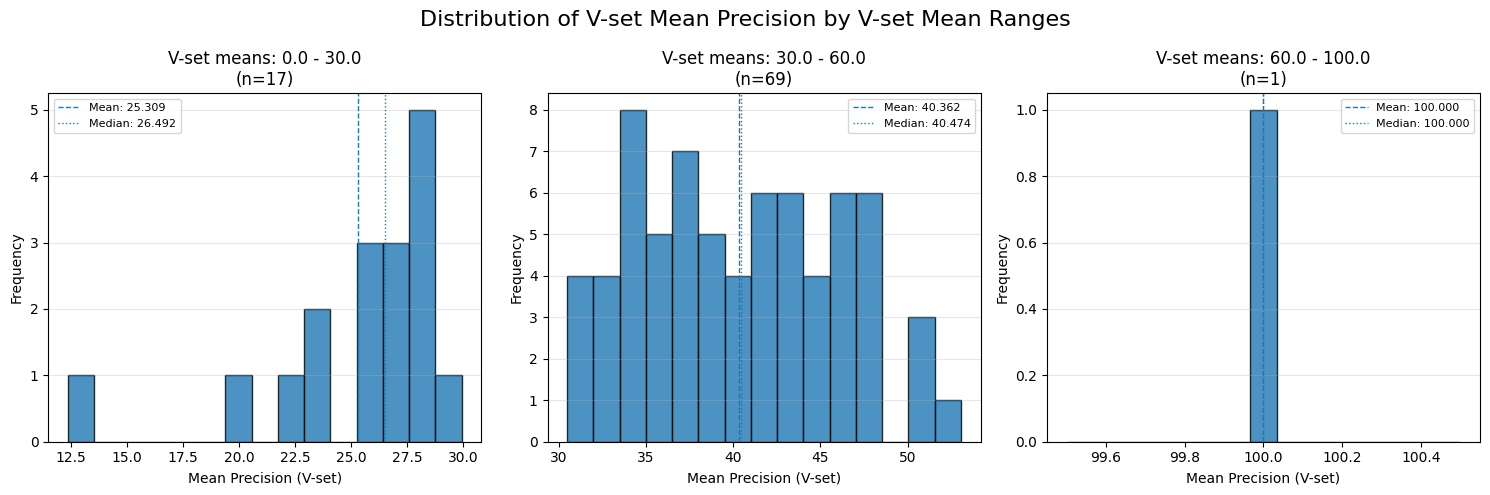

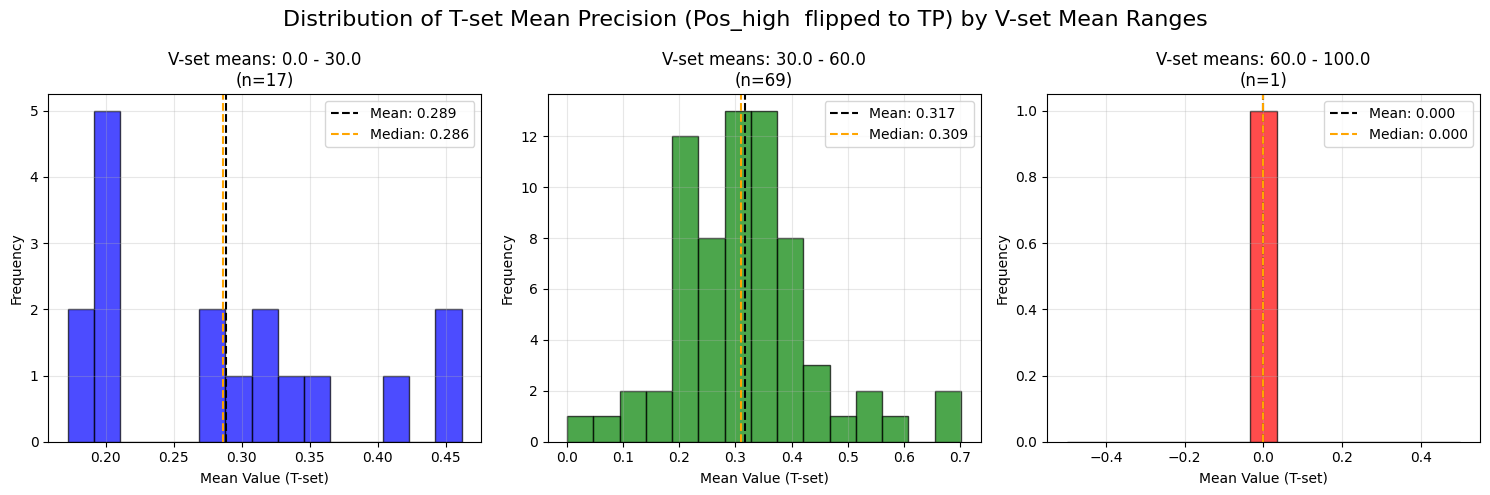

/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_34246/3633787518.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_new_means, labels=all_labels)


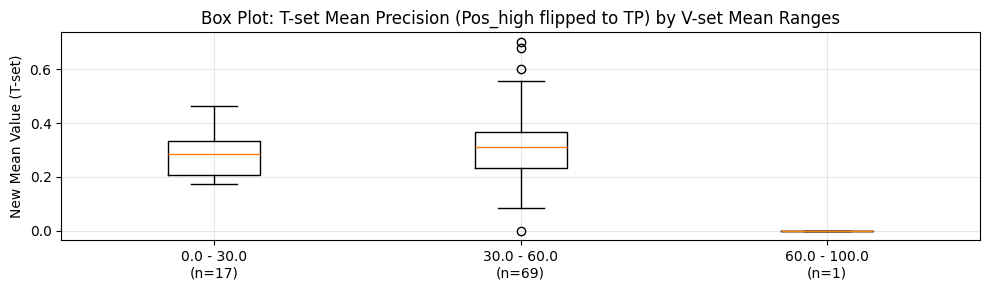

Statistics by (V-set) Mean Range:

Range: 0.0 - 30.0
  Count: 17
  T-set mean  - Mean:   0.2885
  T-set mean  - Median: 0.2861
  T-set mean  - Std:    0.0904
  T-set mean  - Min:    0.1721
  T-set mean - Max:    0.4615
  V-set mean - Mean:           25.3087

Range: 30.0 - 60.0
  Count: 69
  T-set mean  - Mean:   0.3175
  T-set mean  - Median: 0.3091
  T-set mean  - Std:    0.1248
  T-set mean  - Min:    0.0000
  T-set mean - Max:    0.7019
  V-set mean - Mean:           40.3622

Range: 60.0 - 100.0
  Count: 1
  T-set mean  - Mean:   0.0000
  T-set mean  - Median: 0.0000
  T-set mean  - Std:    0.0000
  T-set mean  - Min:    0.0000
  T-set mean - Max:    0.0000
  V-set mean - Mean:           100.0000


In [30]:

import numpy as np
import matplotlib.pyplot as plt

# ---------- 0) Get metrics ONLY via your functions ----------
# Select *all* models on V-set (no filtering)
selected_models_all = select_models_by_criteria(
    results_data=results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(0, 100),
    min_seeds_per_model=1,
    max_models_to_return=len(results_dist_disc),  # include all; prevents sampling cap
    max_zero_precision_seeds=None,
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs=None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,
    random_seed=None,
)

# tset_models_keep = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
#                                       selected_models=selected_models_all,
#                                       brackets=((0.5, 0.7), (0.7, 1.0)))

# Recompute the same models on T-set with a NO-OP policy (no FP rewriting)
tset_models_keep = recompute_metrics_ignoring_pos_fp(
    selected_models_output=selected_models_all,
    results_data=results_dist_disc_Tset_same_seeds_organized,
    targets=("pos_high"),           # target nothing
    fp_treatment="flip_to_tp",    # leave FPs as-is (no-op)
)

# ---------- 1) Build aligned vectors (OLD = V-set means, NEW = T-set means) ----------
old_map = {m["combo_index"]: m.get("mean_precision", np.nan) for m in selected_models_all}
new_map = {m["combo_index"]: m.get("mean_precision", np.nan) for m in tset_models_keep}

# Keep consistent V-set ordering and only models present in both
combo_order = [m["combo_index"] for m in selected_models_all if m["combo_index"] in new_map]

v_mean     = np.array([old_map[c] for c in combo_order], dtype=float)  # OLD = V-set (from selection fn)
v_new_mean = np.array([new_map[c] for c in combo_order], dtype=float)  # NEW = T-set (from recompute fn)

# Drop NaN/Inf in lockstep (keep only pairs where both are finite)
valid = np.isfinite(v_mean) & np.isfinite(v_new_mean)
old = v_mean[valid]
new = v_new_mean[valid]

# ---------- 2) Define OLD-mean ranges (bin by OLD) ----------
ranges = [(0, 30), (30, 60), (60, 100)]
range_labels = ['0.0 - 30.0', '30.0 - 60.0', '60.0 - 100.0']
colors = ['blue', 'green', 'red']

def range_mask(arr, i, L, H):
    return ((arr >= L) & (arr < H)) if i < len(ranges) - 1 else ((arr >= L) & (arr <= H))

# ---------- 3) Figure A: V-set (old) distributions per OLD-mean range ----------
plt.figure(figsize=(15, 5))
for i, ((L, H), label, color) in enumerate(zip(ranges, range_labels, colors)):
    mask = range_mask(old, i, L, H)
    old_r = old[mask]

    ax = plt.subplot(1, 3, i + 1)
    if old_r.size > 0:
        plt.hist(old_r, bins=15, alpha=0.8, edgecolor='black')
        mean_old = float(np.mean(old_r))
        med_old  = float(np.median(old_r))
        plt.axvline(mean_old, linestyle='--', linewidth=1, label=f'Mean: {mean_old:.3f}')
        plt.axvline(med_old,  linestyle=':',  linewidth=1, label=f'Median: {med_old:.3f}')
        plt.title(f'V-set means: {label}\n(n={old_r.size})')
        plt.xlabel('Mean Precision (V-set)'); plt.ylabel('Frequency')
        plt.legend(fontsize=8); plt.grid(True, alpha=0.3, axis='y')
    else:
        ax.text(0.5, 0.5, f'No data in range\n{label}', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'V-set means: {label}')
plt.suptitle('Distribution of V-set Mean Precision by V-set Mean Ranges', fontsize=16)
plt.tight_layout(); plt.show()

# ---------- 4) Figure B: T-set (new) distributions per OLD-mean range ----------
plt.figure(figsize=(15, 5))
for i, ((L, H), label, color) in enumerate(zip(ranges, range_labels, colors)):
    mask = range_mask(old, i, L, H)  # binning by OLD means
    new_r = new[mask]

    ax = plt.subplot(1, 3, i + 1)
    if new_r.size > 0:
        plt.hist(new_r, bins=15, alpha=0.7, color=color, edgecolor='black')
        mean_new = float(np.mean(new_r))
        med_new  = float(np.median(new_r))
        plt.axvline(mean_new, color='black', linestyle='--', label=f'Mean: {mean_new:.3f}')
        plt.axvline(med_new,  color='orange', linestyle='--', label=f'Median: {med_new:.3f}')
        plt.title(f'V-set means: {label}\n(n={new_r.size})')
        plt.xlabel('Mean Value (T-set)'); plt.ylabel('Frequency')
        plt.legend(); plt.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'No data in range\n{label}', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'V-set means: {label}')
plt.suptitle('Distribution of T-set Mean Precision (Pos_high  flipped to TP) by V-set Mean Ranges', fontsize=16)
plt.tight_layout(); plt.show()

# ---------- 5) Figure C: Box plot of NEW (T-set) by OLD-mean ranges ----------
plt.figure(figsize=(10, 3))
all_new_means, all_labels = [], []
for i, ((L, H), label) in enumerate(zip(ranges, range_labels)):
    mask = range_mask(old, i, L, H)
    new_r = new[mask]
    if new_r.size > 0:
        all_new_means.append(new_r)
        all_labels.append(f'{label}\n(n={new_r.size})')
if all_new_means:
    plt.boxplot(all_new_means, labels=all_labels)
    plt.title('Box Plot: T-set Mean Precision (Pos_high flipped to TP) by V-set Mean Ranges')
    plt.ylabel('New Mean Value (T-set)')
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
else:
    print("No non-empty ranges for boxplot.")

# ---------- 6) Stats printout ----------
print("Statistics by (V-set) Mean Range:")
print("=" * 50)
for i, ((L, H), label) in enumerate(zip(ranges, range_labels)):
    mask = range_mask(old, i, L, H)
    new_r = new[mask]; old_r = old[mask]
    if new_r.size > 0:
        print(f"\nRange: {label}")
        print(f"  Count: {new_r.size}")
        print(f"  T-set mean  - Mean:   {np.mean(new_r):.4f}")
        print(f"  T-set mean  - Median: {np.median(new_r):.4f}")
        print(f"  T-set mean  - Std:    {np.std(new_r, ddof=0):.4f}")
        print(f"  T-set mean  - Min:    {np.min(new_r):.4f}")
        print(f"  T-set mean - Max:    {np.max(new_r):.4f}")
        print(f"  V-set mean - Mean:           {np.mean(old_r):.4f}")
    else:
        print(f"\nRange: {label} - No data")


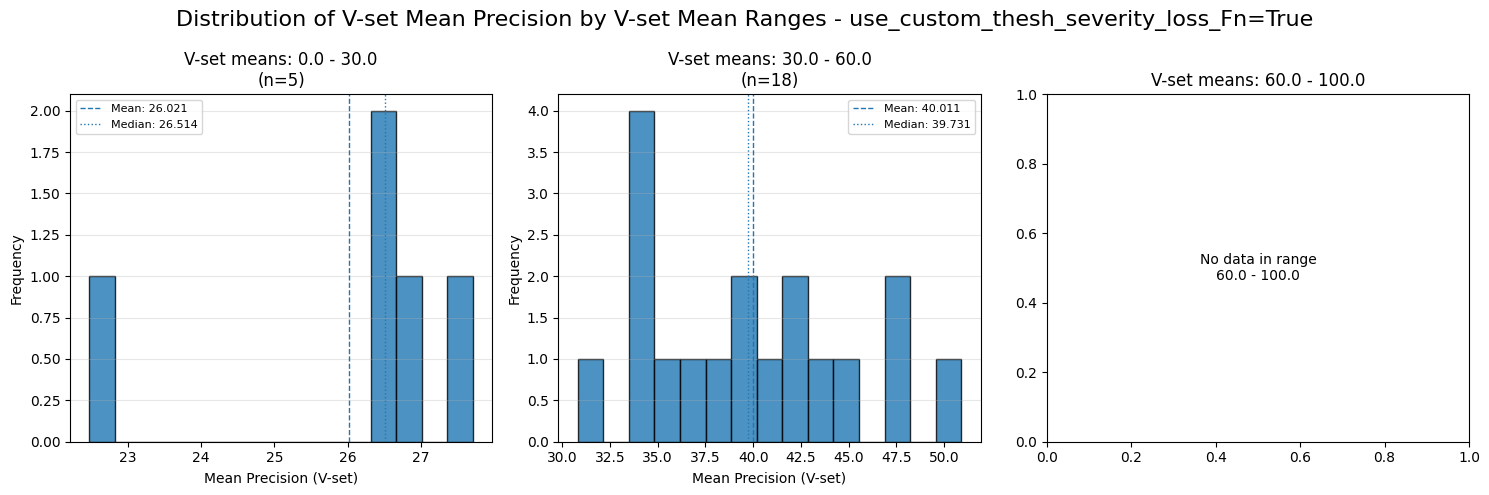

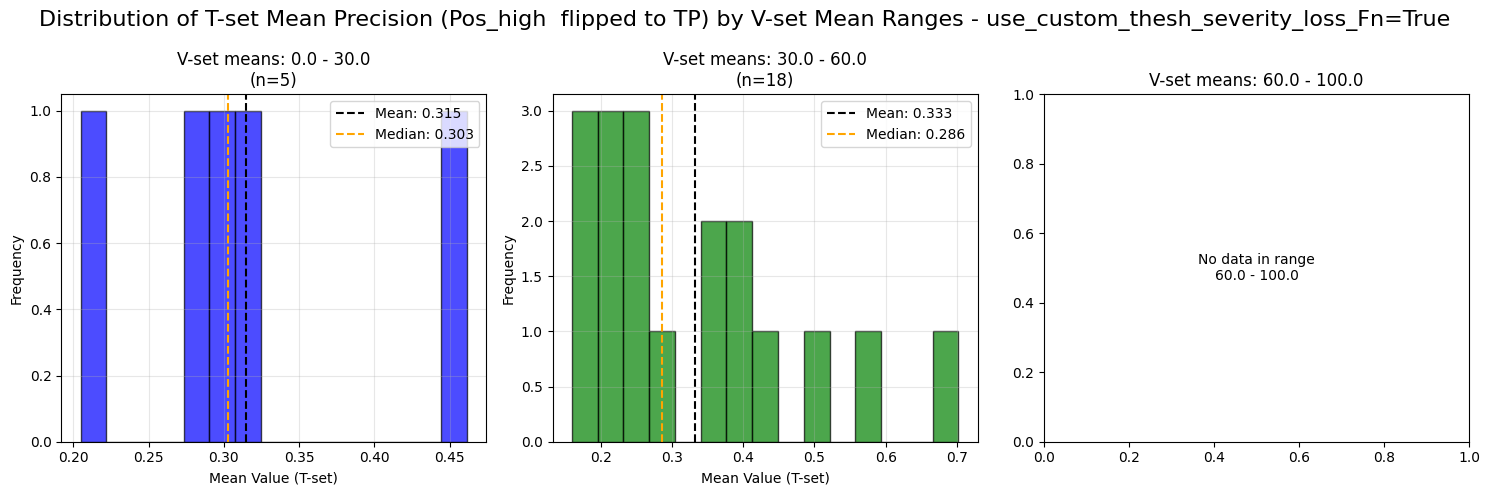

/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_34246/4040337774.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_new_means, labels=all_labels)


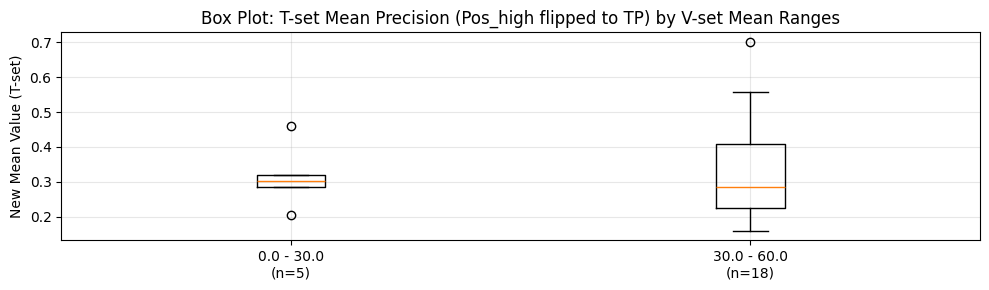

Statistics by (V-set) Mean Range:

Range: 0.0 - 30.0
  Count: 5
  T-set mean  - Mean:   0.3147
  T-set mean  - Median: 0.3030
  T-set mean  - Std:    0.0832
  T-set mean  - Min:    0.2048
  T-set mean - Max:    0.4615
  V-set mean - Mean:           26.0213

Range: 30.0 - 60.0
  Count: 18
  T-set mean  - Mean:   0.3328
  T-set mean  - Median: 0.2858
  T-set mean  - Std:    0.1425
  T-set mean  - Min:    0.1597
  T-set mean - Max:    0.7019
  V-set mean - Mean:           40.0115

Range: 60.0 - 100.0 - No data


In [31]:
####                        MODELS with CUSTOM BCE LOSS FUNCTION -- THRESH AND SEVERITY
import numpy as np
import matplotlib.pyplot as plt

# ---------- 0) Get metrics ONLY via your functions ----------
# Select *all* models on V-set (no filtering)
selected_models_all = select_models_by_criteria(
    results_data=results_dist_disc,
    use_custom_thesh_severity_loss_Fn= True,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(0, 100),
    min_seeds_per_model=1,
    max_models_to_return=len(results_dist_disc),  # include all; prevents sampling cap
    max_zero_precision_seeds=None,
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs=None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,
    random_seed=None,
)

# tset_models_keep = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
#                                       selected_models=selected_models_all,
#                                       brackets=((0.5, 0.7), (0.7, 1.0)))

# Recompute the same models on T-set with a NO-OP policy (no FP rewriting)
tset_models_keep = recompute_metrics_ignoring_pos_fp(
    selected_models_output=selected_models_all,
    results_data=results_dist_disc_Tset_same_seeds_organized,
    targets=("pos_high"),           # target nothing
    fp_treatment="flip_to_tp",    # leave FPs as-is (no-op)
)

# ---------- 1) Build aligned vectors (OLD = V-set means, NEW = T-set means) ----------
old_map = {m["combo_index"]: m.get("mean_precision", np.nan) for m in selected_models_all}
new_map = {m["combo_index"]: m.get("mean_precision", np.nan) for m in tset_models_keep}

# Keep consistent V-set ordering and only models present in both
combo_order = [m["combo_index"] for m in selected_models_all if m["combo_index"] in new_map]

v_mean     = np.array([old_map[c] for c in combo_order], dtype=float)  # OLD = V-set (from selection fn)
v_new_mean = np.array([new_map[c] for c in combo_order], dtype=float)  # NEW = T-set (from recompute fn)

# Drop NaN/Inf in lockstep (keep only pairs where both are finite)
valid = np.isfinite(v_mean) & np.isfinite(v_new_mean)
old = v_mean[valid]
new = v_new_mean[valid]

# ---------- 2) Define OLD-mean ranges (bin by OLD) ----------
ranges = [(0, 30), (30, 60), (60, 100)]
range_labels = ['0.0 - 30.0', '30.0 - 60.0', '60.0 - 100.0']
colors = ['blue', 'green', 'red']

def range_mask(arr, i, L, H):
    return ((arr >= L) & (arr < H)) if i < len(ranges) - 1 else ((arr >= L) & (arr <= H))

# ---------- 3) Figure A: V-set (old) distributions per OLD-mean range ----------
plt.figure(figsize=(15, 5))
for i, ((L, H), label, color) in enumerate(zip(ranges, range_labels, colors)):
    mask = range_mask(old, i, L, H)
    old_r = old[mask]

    ax = plt.subplot(1, 3, i + 1)
    if old_r.size > 0:
        plt.hist(old_r, bins=15, alpha=0.8, edgecolor='black')
        mean_old = float(np.mean(old_r))
        med_old  = float(np.median(old_r))
        plt.axvline(mean_old, linestyle='--', linewidth=1, label=f'Mean: {mean_old:.3f}')
        plt.axvline(med_old,  linestyle=':',  linewidth=1, label=f'Median: {med_old:.3f}')
        plt.title(f'V-set means: {label}\n(n={old_r.size})')
        plt.xlabel('Mean Precision (V-set)'); plt.ylabel('Frequency')
        plt.legend(fontsize=8); plt.grid(True, alpha=0.3, axis='y')
    else:
        ax.text(0.5, 0.5, f'No data in range\n{label}', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'V-set means: {label}')
plt.suptitle('Distribution of V-set Mean Precision by V-set Mean Ranges - use_custom_thesh_severity_loss_Fn=True', fontsize=16)
plt.tight_layout(); plt.show()

# ---------- 4) Figure B: T-set (new) distributions per OLD-mean range ----------
plt.figure(figsize=(15, 5))
for i, ((L, H), label, color) in enumerate(zip(ranges, range_labels, colors)):
    mask = range_mask(old, i, L, H)  # binning by OLD means
    new_r = new[mask]

    ax = plt.subplot(1, 3, i + 1)
    if new_r.size > 0:
        plt.hist(new_r, bins=15, alpha=0.7, color=color, edgecolor='black')
        mean_new = float(np.mean(new_r))
        med_new  = float(np.median(new_r))
        plt.axvline(mean_new, color='black', linestyle='--', label=f'Mean: {mean_new:.3f}')
        plt.axvline(med_new,  color='orange', linestyle='--', label=f'Median: {med_new:.3f}')
        plt.title(f'V-set means: {label}\n(n={new_r.size})')
        plt.xlabel('Mean Value (T-set)'); plt.ylabel('Frequency')
        plt.legend(); plt.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'No data in range\n{label}', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'V-set means: {label}')
plt.suptitle('Distribution of T-set Mean Precision (Pos_high  flipped to TP) by V-set Mean Ranges - use_custom_thesh_severity_loss_Fn=True', fontsize=16)
plt.tight_layout(); plt.show()

# ---------- 5) Figure C: Box plot of NEW (T-set) by OLD-mean ranges ----------
plt.figure(figsize=(10, 3))
all_new_means, all_labels = [], []
for i, ((L, H), label) in enumerate(zip(ranges, range_labels)):
    mask = range_mask(old, i, L, H)
    new_r = new[mask]
    if new_r.size > 0:
        all_new_means.append(new_r)
        all_labels.append(f'{label}\n(n={new_r.size})')
if all_new_means:
    plt.boxplot(all_new_means, labels=all_labels)
    plt.title('Box Plot: T-set Mean Precision (Pos_high flipped to TP) by V-set Mean Ranges')
    plt.ylabel('New Mean Value (T-set)')
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
else:
    print("No non-empty ranges for boxplot.")

# ---------- 6) Stats printout ----------
print("Statistics by (V-set) Mean Range:")
print("=" * 50)
for i, ((L, H), label) in enumerate(zip(ranges, range_labels)):
    mask = range_mask(old, i, L, H)
    new_r = new[mask]; old_r = old[mask]
    if new_r.size > 0:
        print(f"\nRange: {label}")
        print(f"  Count: {new_r.size}")
        print(f"  T-set mean  - Mean:   {np.mean(new_r):.4f}")
        print(f"  T-set mean  - Median: {np.median(new_r):.4f}")
        print(f"  T-set mean  - Std:    {np.std(new_r, ddof=0):.4f}")
        print(f"  T-set mean  - Min:    {np.min(new_r):.4f}")
        print(f"  T-set mean - Max:    {np.max(new_r):.4f}")
        print(f"  V-set mean - Mean:           {np.mean(old_r):.4f}")
    else:
        print(f"\nRange: {label} - No data")


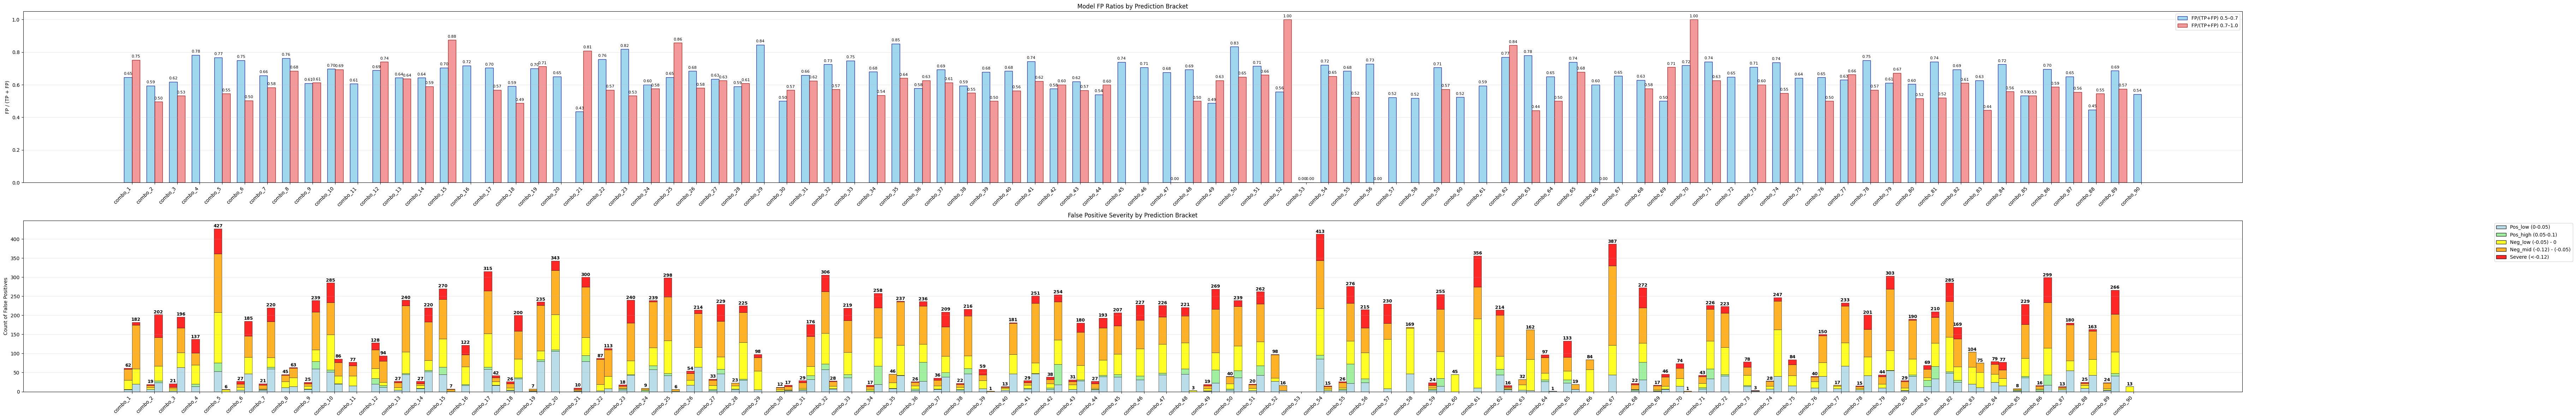

In [32]:
import numpy as np
import matplotlib.pyplot as plt

SEVERITY_CATS = [
    "Pos_low (0-0.05)",
    "Pos_high (0.05-0.1)",
    "Neg_low (-0.05) - 0",
    "Neg_mid (-0.12) - (-0.05)",
    "Severe (<-0.12)",
]
SEVERITY_COLORS = {
    "Pos_low (0-0.05)": 'lightblue',
    "Pos_high (0.05-0.1)": 'lightgreen',
    "Neg_low (-0.05) - 0": 'yellow',
    "Neg_mid (-0.12) - (-0.05)": 'orange',
    "Severe (<-0.12)": 'red',
    "Other": 'gray',
}

if not selected_models:
    print("No models to plot.")
else:
    labels = [f"combo_{m['combo_index']}" for m in selected_models]
    x = np.arange(len(labels))
    width = 0.35

    # --- Plot 1: FP Ratios (from fp_tp_ratios in selected_models) ---
    r_05_07 = [m.get("fp_tp_ratios", {}).get("0.5-0.7", np.nan) for m in selected_models]
    r_07_10 = [m.get("fp_tp_ratios", {}).get("0.7-1.0", np.nan) for m in selected_models]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(10, len(labels)*0.8), 12))

    b1 = ax1.bar(x - width/2, r_05_07, width, label='FP/(TP+FP) 0.5–0.7',
                 alpha=0.8, color='skyblue', edgecolor='navy')
    b2 = ax1.bar(x + width/2, r_07_10, width, label='FP/(TP+FP) 0.7–1.0',
                 alpha=0.8, color='lightcoral', edgecolor='darkred')
    ax1.set_xticks(x); ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_ylabel('FP / (TP + FP)'); ax1.set_title('Model FP Ratios by Prediction Bracket')
    ax1.legend(); ax1.grid(True, alpha=0.3, axis='y')

    for i, (v1, v2) in enumerate(zip(r_05_07, r_07_10)):
        if not np.isnan(v1): ax1.text(i - width/2, v1 + 0.01, f'{v1:.2f}', ha='center', va='bottom', fontsize=8)
        if not np.isnan(v2): ax1.text(i + width/2, v2 + 0.01, f'{v2:.2f}', ha='center', va='bottom', fontsize=8)

    # --- Plot 2: Severity Breakdown (read from fp_severity_by_bracket) ---
    # Build arrays directly from each model's fp_severity_by_bracket
    def get_counts(model, bracket_key, cat):
        d = model.get("fp_severity_by_bracket", {}).get(bracket_key, {})
        return int(d.get(cat, 0))

    low_data  = {cat: [get_counts(m, "0.5-0.7", cat) for m in selected_models] for cat in SEVERITY_CATS}
    high_data = {cat: [get_counts(m, "0.7-1.0", cat) for m in selected_models] for cat in SEVERITY_CATS}

    bottom_low  = np.zeros(len(labels))
    bottom_high = np.zeros(len(labels))
    legend_handles = []

    for cat in SEVERITY_CATS:
        color = SEVERITY_COLORS.get(cat, 'gray')
        ax2.bar(x - width/2, low_data[cat],  width, bottom=bottom_low,  color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
        ax2.bar(x + width/2, high_data[cat], width, bottom=bottom_high, color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
        bottom_low  += np.array(low_data[cat])
        bottom_high += np.array(high_data[cat])
        legend_handles.append(plt.Rectangle((0,0), 1, 1, fc=color, alpha=0.85, label=cat, edgecolor='black'))

    ax2.set_xticks(x); ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_ylabel('Count of False Positives')
    ax2.set_title('False Positive Severity by Prediction Bracket')
    ax2.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.15, 1))
    ax2.grid(True, alpha=0.3, axis='y')

    # Totals above bars
    total_low  = bottom_low
    total_high = bottom_high
    for i in range(len(labels)):
        if total_low[i]  > 0: ax2.text(i - width/2, total_low[i]  + 0.5, int(total_low[i]),  ha='center', va='bottom', fontsize=9, fontweight='bold')
        if total_high[i] > 0: ax2.text(i + width/2, total_high[i] + 0.5, int(total_high[i]), ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # # --- Summary printout using the same data (no raw re-walk) ---
    # print("\n" + "="*60)
    # print("SEVERE CASE PROPORTIONS BY BRACKET")
    # print("="*60)
    # for i, label in enumerate(labels):
    #     low_counts  = [low_data[cat][i]  for cat in SEVERITY_CATS]
    #     high_counts = [high_data[cat][i] for cat in SEVERITY_CATS]
    #     total_low   = sum(low_counts)
    #     total_high  = sum(high_counts)
    #     severe_low  = low_data["Severe (<-0.12)"][i]
    #     severe_high = high_data["Severe (<-0.12)"][i]

    #     prop_low  = (severe_low  / total_low  * 100) if total_low  > 0 else 0
    #     prop_high = (severe_high / total_high * 100) if total_high > 0 else 0

    #     print(f"{label}:")
    #     print(f"  Low bracket (0.5-0.7): {prop_low:.1f}% severe ({severe_low}/{total_low})")
    #     print(f"  High bracket (0.7-1.0): {prop_high:.1f}% severe ({severe_high}/{total_high})")
    #     print("-" * 40)


Models Selected control: 90
Total seeds selected control: 4470
Models Selected HIGH: 0
Total seeds selected HIGH: 0
Models Selected LOW: 37
Total seeds selected LOW: 1886


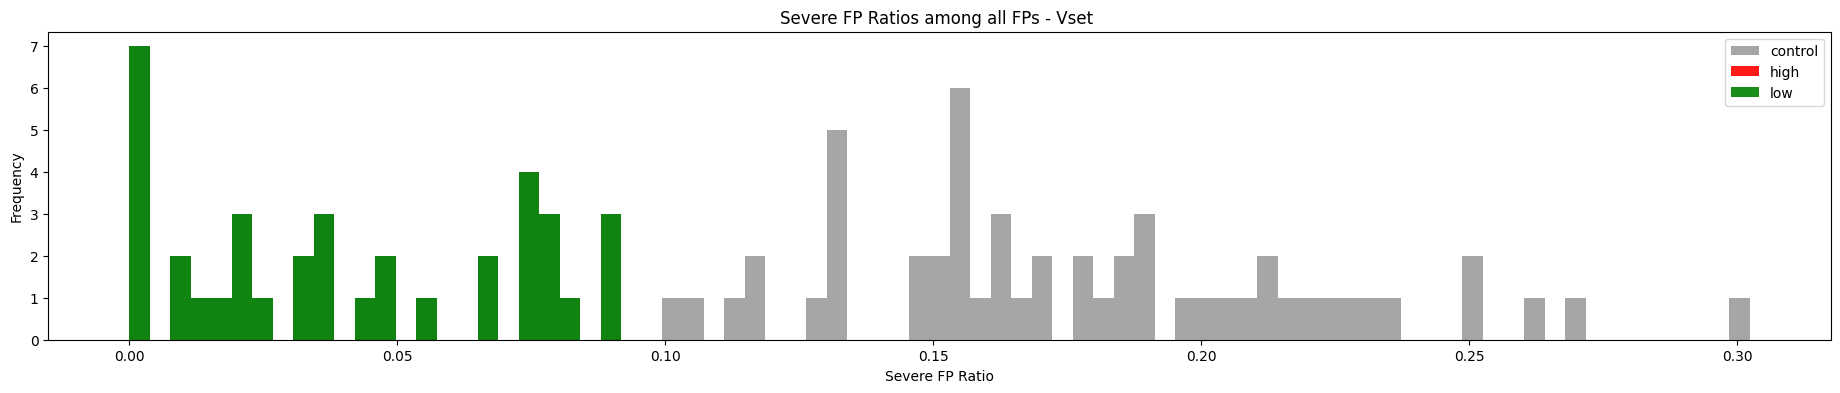

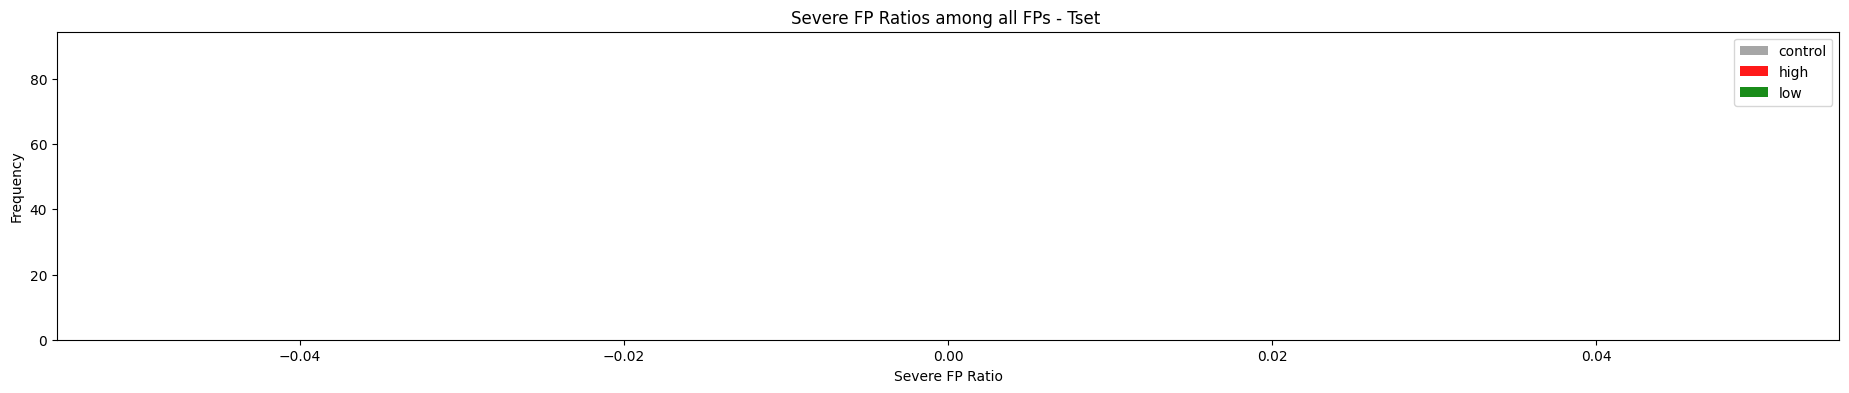

In [33]:
import random
####                                                                                TESTING max_FP_severe_ratio_FPs
# Run the model selection function with the new parameters
selected_models_control = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)  # No limit; get all that match criteria
)

selected_models_test_LOW_ratio___fp_severe_ratio_fps = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= .1,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)  # No limit; get all that match criteria
)


selected_models_test_HIGH_ratio___fp_severe_ratio_fps = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs= .8,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)  # No limit; get all that match criteria
)

selected_models_control_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_control,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))

selected_models_test_LOW_ratio___fp_severe_ratio_fps_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_test_LOW_ratio___fp_severe_ratio_fps,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))

selected_models_test_HIGH_ratio___fp_severe_ratio_fps_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_test_HIGH_ratio___fp_severe_ratio_fps,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))




# Print summary of selected models
print(f"Models Selected control: {len(selected_models_control)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models_control)
print(f"Total seeds selected control: {total_seeds}")

print(f"Models Selected HIGH: {len(selected_models_test_HIGH_ratio___fp_severe_ratio_fps)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models_test_HIGH_ratio___fp_severe_ratio_fps)
print(f"Total seeds selected HIGH: {total_seeds}")

print(f"Models Selected LOW: {len(selected_models_test_LOW_ratio___fp_severe_ratio_fps)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models_test_LOW_ratio___fp_severe_ratio_fps)
print(f"Total seeds selected LOW: {total_seeds}")


#his tof all severe FPs among all MODELS

list_ALL_fp_severe_ratio_fps_control = []
for i in selected_models_control:
    list_ALL_fp_severe_ratio_fps_control.append(i["fp_severe_ratio_fps"])

list_ALL_fp_severe_ratio_fps_low = []
for i in selected_models_test_LOW_ratio___fp_severe_ratio_fps:
    list_ALL_fp_severe_ratio_fps_low.append(i["fp_severe_ratio_fps"])

list_ALL_fp_severe_ratio_fps_high = []
for i in selected_models_test_HIGH_ratio___fp_severe_ratio_fps: 
    list_ALL_fp_severe_ratio_fps_high.append(i["fp_severe_ratio_fps"])

######################
list_ALL_fp_severe_ratio_fps_control_TEST = []
for i in selected_models_control_TEST:
    list_ALL_fp_severe_ratio_fps_control_TEST.append(i["fp_severe_ratio_fps"])

list_ALL_fp_severe_ratio_fps_low_TEST = []
for i in selected_models_test_LOW_ratio___fp_severe_ratio_fps_TEST:
    list_ALL_fp_severe_ratio_fps_low_TEST.append(i["fp_severe_ratio_fps"])

list_ALL_fp_severe_ratio_fps_high_TEST = []
for i in selected_models_test_HIGH_ratio___fp_severe_ratio_fps_TEST:
    list_ALL_fp_severe_ratio_fps_high_TEST.append(i["fp_severe_ratio_fps"])


all_vals = list_ALL_fp_severe_ratio_fps_control + list_ALL_fp_severe_ratio_fps_low + list_ALL_fp_severe_ratio_fps_high
Bins = np.linspace(min(all_vals), max(all_vals), 80)  # 30 bins, same edges for all

plt.figure(figsize = (23 , 4))
plt.hist(list_ALL_fp_severe_ratio_fps_control , bins=Bins , alpha = 0.7 , label = "control" , color = "grey")
plt.hist(list_ALL_fp_severe_ratio_fps_high , bins = Bins , alpha = 0.9 , label = "high" , color = "red")
plt.hist(list_ALL_fp_severe_ratio_fps_low , bins = Bins , alpha = 0.9 , label = "low" , color = "green")
plt.title("Severe FP Ratios among all FPs - Vset ")
plt.xlabel("Severe FP Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()


all_vals = list_ALL_fp_severe_ratio_fps_control_TEST + list_ALL_fp_severe_ratio_fps_low_TEST + list_ALL_fp_severe_ratio_fps_high_TEST
Bins = np.linspace(min(all_vals), max(all_vals), 80)  # 30 bins, same edges for all

plt.figure(figsize = (23 , 4))
plt.hist(list_ALL_fp_severe_ratio_fps_control_TEST , bins=Bins , alpha = 0.7 , label = "control" , color = "grey")
plt.hist(list_ALL_fp_severe_ratio_fps_high_TEST , bins = Bins , alpha = 0.9 , label = "high" , color = "red")
plt.hist(list_ALL_fp_severe_ratio_fps_low_TEST , bins = Bins , alpha = 0.9 , label = "low" , color = "green")
plt.title("Severe FP Ratios among all FPs - Tset ")
plt.xlabel("Severe FP Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()





mean control V 0.08604955139624743
mean custom loss severity V 0.09630281571537636
mean control T 0.0
mean custom loss severity T 0.0
-----
std control V 0.08886743426911609
std custom loss severity V 0.09557664222516205
std control T 0.0
std custom loss severity T 0.0


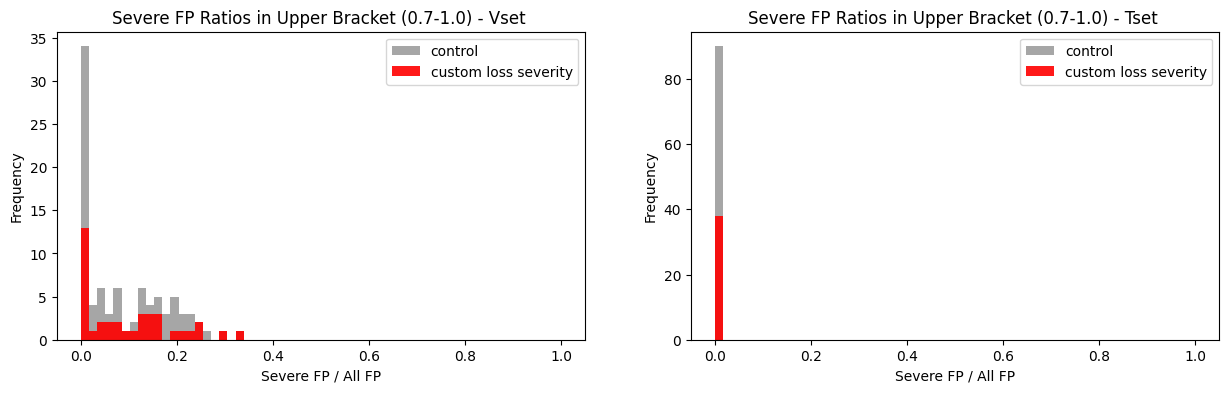

In [34]:
####                               UPPER BRACKET (0.7-1.0) SEVERE FPs --- USING CUSTOM SEVERITY + THRESH LOSS FUNCTION 


import random
####                                                                                TESTING max_FP_severe_ratio_FPs
# Run the model selection function with the new parameters
selected_models_control = select_models_by_criteria(
    results_dist_disc,

    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)  
)

selected_models_custom_loss_severity = select_models_by_criteria(
    results_dist_disc,
    # use_custom_thesh_severity_loss_Fn=True,
    use_custom_thesh_loss_Fn=True,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return= len(results_dist_disc) 
)



selected_models_control_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_control)

selected_models_custom_loss_severity_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_custom_loss_severity)





def ratio_calculator_FPs_allFP(selected_models):

    list_ALL_ratios = []
    for i in selected_models:

        if i.get("fp_severity_by_bracket" , None) is None:
            ratio = 0
            list_ALL_ratios.append(ratio)
            continue
        if i.get("bracket_counts" , None) is None:
            continue    
        if i.get("fp_severity_by_bracket").get("0.7-1.0") is None:
            ratio = 0
            list_ALL_ratios.append(ratio)
            continue
        if i.get("bracket_counts", []).get("0.7-1.0", None) is None:
            continue

        severe_count = i["fp_severity_by_bracket"].get("0.7-1.0").get("Severe (<-0.12)", 0)

        fp_count = i["bracket_counts"].get("0.7-1.0", {}).get("FP", 0)  # Avoid division by zero

        if fp_count > 0:
            ratio = severe_count / fp_count
        else:
            ratio = 0
        list_ALL_ratios.append(ratio)

    return list_ALL_ratios


list_ALL_ratios_control_V = ratio_calculator_FPs_allFP(selected_models_control)

list_ALL_ratios_custom_loss_severity_V = ratio_calculator_FPs_allFP(selected_models_custom_loss_severity)

##########

list_ALL_ratios_control_T = ratio_calculator_FPs_allFP(selected_models_control_TEST)

list_ALL_ratios_custom_loss_severity_T = ratio_calculator_FPs_allFP(selected_models_custom_loss_severity_TEST)


plt.figure(figsize = (15 , 4))
plt.subplot(1,2,1)

Bins = np.linspace(0, 1, 60)  # 30 bins, same edges for all
plt.hist(list_ALL_ratios_control_V , bins=Bins , alpha = 0.7 , label = "control" , color = "grey")
plt.hist(list_ALL_ratios_custom_loss_severity_V , bins = Bins , alpha = 0.9 , label = "custom loss severity" , color = "red")
plt.title("Severe FP Ratios in Upper Bracket (0.7-1.0) - Vset ")
plt.xlabel("Severe FP / All FP")
plt.ylabel("Frequency")
plt.legend()
plt.subplot(1,2,2)
print("mean control V" , np.mean(list_ALL_ratios_control_V))
print("mean custom loss severity V" , np.mean(list_ALL_ratios_custom_loss_severity_V))
print("mean control T" , np.mean(list_ALL_ratios_control_T))
print("mean custom loss severity T" , np.mean(list_ALL_ratios_custom_loss_severity_T))
print("-----")
print("std control V" , np.std(list_ALL_ratios_control_V))
print("std custom loss severity V" , np.std(list_ALL_ratios_custom_loss_severity_V))
print("std control T" , np.std(list_ALL_ratios_control_T))
print("std custom loss severity T" , np.std(list_ALL_ratios_custom_loss_severity_T))

Bins = np.linspace(0, 1, 60)  # 30 bins, same edges for all
plt.hist(list_ALL_ratios_control_T , bins=Bins , alpha = 0.7 , label = "control" , color = "grey")
plt.hist(list_ALL_ratios_custom_loss_severity_T , bins = Bins , alpha = 0.9 , label = "custom loss severity" , color = "red")
plt.title("Severe FP Ratios in Upper Bracket (0.7-1.0) - Tset ")
plt.xlabel("Severe FP / All FP")
plt.ylabel("Frequency")
plt.legend()
plt.show()





#  'bracket_counts': {'0.7-1.0': {'TP': 29, 'FP': 90},
#   '0.5-0.7': {'TP': 4, 'FP': 18}},
#  'non_bracket_counts': {'TN': 1092, 'FN': 207},
#  'fp_tp_ratios': {'0.7-1.0': 0.7563025210084033,
#   '0.5-0.7': 0.8181818181818182},
#  'ratio_difference': 0.06187929717341489,
#  'fp_severe_ratio_fps': 0.3425925925925926,
#  'fp_severe_ratio_fps_tps': 0.2624113475177305,
#  'fp_severity_by_bracket': {'0.5-0.7': {'Severe (<-0.12)': 9,
#    'Neg_low (-0.05) - 0': 4,
#    'Neg_mid (-0.12) - (-0.05)': 5},
#   '0.7-1.0': {'Neg_mid (-0.12) - (-0.05)': 22,
#    'Severe (<-0.12)': 28,




mean control V 0.08020443268208965
mean custom loss severity V 0.053119437820986964
mean control T 0.0
mean custom loss severity T 0.0
-----
std control V 0.09125021094824416
std custom loss severity V 0.0755295683403507
std control T 0.0
std custom loss severity T 0.0


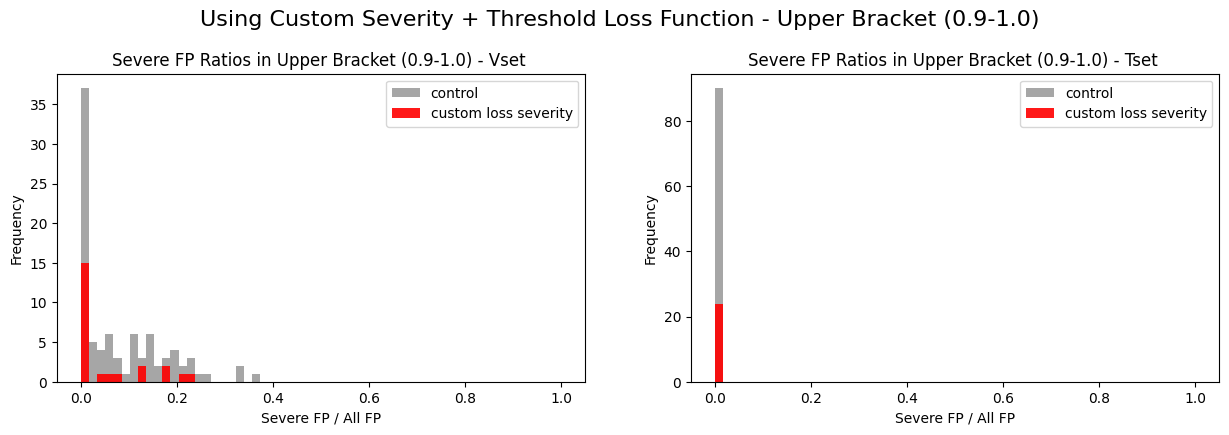

In [35]:
####                               UPPER BRACKET (0.9-1.0) SEVERE FPs --- USING CUSTOM SEVERITY + THRESH LOSS FUNCTION 


import random
####                                                                                TESTING max_FP_severe_ratio_FPs
# Run the model selection function with the new parameters
selected_models_control = select_models_by_criteria(
    results_dist_disc,

    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return= len(results_dist_disc)
)

selected_models_custom_loss_severity = select_models_by_criteria(
    results_dist_disc,
    use_custom_thesh_severity_loss_Fn=True,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return= len(results_dist_disc)
)



selected_models_control_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_control)

selected_models_custom_loss_severity_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_custom_loss_severity)




def ratio_calculator_FPs_allFP(selected_models):

    list_ALL_ratios = []
    for i in selected_models:

        if i.get("fp_severity_by_bracket" , None) is None:
            ratio = 0
            list_ALL_ratios.append(ratio)
            continue
        if i.get("bracket_counts" , None) is None:
            continue    
        if i.get("fp_severity_by_bracket").get("0.9-1.0") is None:
            ratio = 0
            list_ALL_ratios.append(ratio)
            continue
        if i.get("bracket_counts", []).get("0.9-1.0", None) is None:
            continue

        severe_count = i["fp_severity_by_bracket"].get("0.9-1.0").get("Severe (<-0.12)", 0)

        fp_count = i["bracket_counts"].get("0.9-1.0", {}).get("FP", 0)  # Avoid division by zero

        if fp_count > 0:
            ratio = severe_count / fp_count
        else:
            ratio = 0
        list_ALL_ratios.append(ratio)

    return list_ALL_ratios

    



list_ALL_ratios_control_V = ratio_calculator_FPs_allFP(selected_models_control)

list_ALL_ratios_custom_loss_severity_V = ratio_calculator_FPs_allFP(selected_models_custom_loss_severity)

##########

list_ALL_ratios_control_T = ratio_calculator_FPs_allFP(selected_models_control_TEST)

list_ALL_ratios_custom_loss_severity_T = ratio_calculator_FPs_allFP(selected_models_custom_loss_severity_TEST)
    


plt.figure(figsize = (15 , 4))
plt.subplot(1,2,1)

Bins = np.linspace(0, 1, 60)  # 30 bins, same edges for all
plt.hist(list_ALL_ratios_control_V , bins=Bins , alpha = 0.7 , label = "control" , color = "grey")
plt.hist(list_ALL_ratios_custom_loss_severity_V , bins = Bins , alpha = 0.9 , label = "custom loss severity" , color = "red")
plt.title("Severe FP Ratios in Upper Bracket (0.9-1.0) - Vset ")
plt.xlabel("Severe FP / All FP")
plt.ylabel("Frequency")
plt.legend()
plt.subplot(1,2,2)

print("mean control V" , np.mean(list_ALL_ratios_control_V))
print("mean custom loss severity V" , np.mean(list_ALL_ratios_custom_loss_severity_V))
print("mean control T" , np.mean(list_ALL_ratios_control_T))
print("mean custom loss severity T" , np.mean(list_ALL_ratios_custom_loss_severity_T))
print("-----")
print("std control V" , np.std(list_ALL_ratios_control_V))
print("std custom loss severity V" , np.std(list_ALL_ratios_custom_loss_severity_V))
print("std control T" , np.std(list_ALL_ratios_control_T))
print("std custom loss severity T" , np.std(list_ALL_ratios_custom_loss_severity_T))

Bins = np.linspace(0, 1, 60)  # 30 bins, same edges for all
plt.hist(list_ALL_ratios_control_T , bins=Bins , alpha = 0.7 , label = "control" , color = "grey")
plt.hist(list_ALL_ratios_custom_loss_severity_T , bins = Bins , alpha = 0.9 , label = "custom loss severity" , color = "red")
plt.title("Severe FP Ratios in Upper Bracket (0.9-1.0) - Tset ")
plt.xlabel("Severe FP / All FP")
plt.ylabel("Frequency")
plt.legend()
plt.suptitle("Using Custom Severity + Threshold Loss Function - Upper Bracket (0.9-1.0)" , y=1.04 , fontsize=16) 
plt.show()








mean control V 0.12995600136246327
mean custom loss severity V 0.0677356371257822
mean control T 0.0
mean custom loss severity T 0.0
-----
std control V 0.1689231702282913
std custom loss severity V 0.10110608929674215
std control T 0.0
std custom loss severity T 0.0


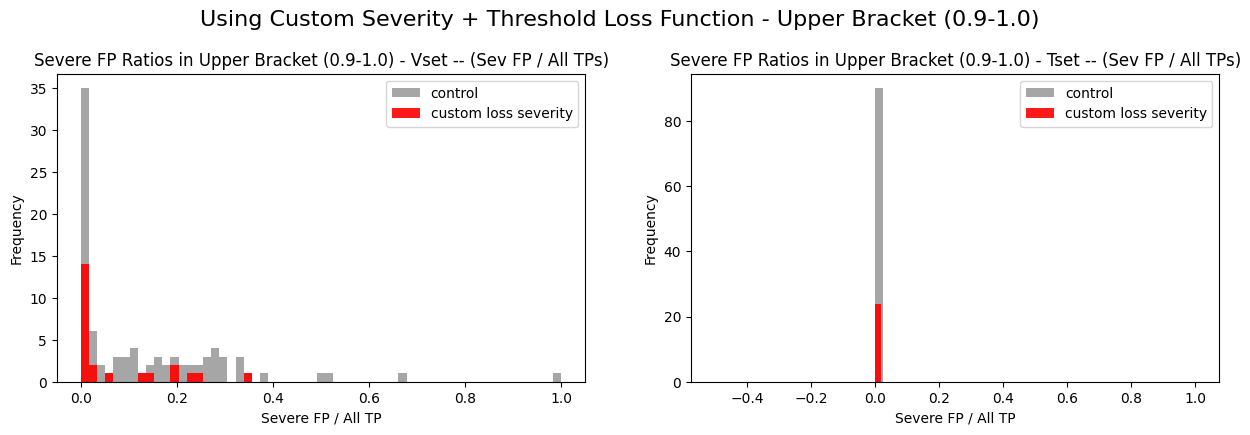

In [36]:
####                               UPPER BRACKET (0.9-1.0) SEVERE FPs / All TPs --- USING CUSTOM SEVERITY + THRESH LOSS FUNCTION 


import random

# Run the model selection function with the new parameters
selected_models_control = select_models_by_criteria(
    results_dist_disc,

    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)

selected_models_custom_loss_severity = select_models_by_criteria(
    results_dist_disc,
    use_custom_thesh_severity_loss_Fn=True,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)



selected_models_control_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_control)

selected_models_custom_loss_severity_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_custom_loss_severity)


def ratio_calculator_FPs_allTP(selected_models):

    list_ALL_ratios = []
    for i in selected_models:

        if i.get("fp_severity_by_bracket" , None) is None:
            ratio = 0
            list_ALL_ratios.append(ratio)
            continue
        if i.get("bracket_counts" , None) is None:
            continue
        if i.get("fp_severity_by_bracket").get("0.9-1.0") is None:
            ratio = 0
            list_ALL_ratios.append(ratio)
            continue
        if i.get("bracket_counts", []).get("0.9-1.0", None) is None:
            continue
        if i.get("bracket_counts", []).get("0.9-1.0", None).get("TP", None) is None:
            ratio = 1
            list_ALL_ratios.append(ratio)
            continue

        severe_count = i.get("fp_severity_by_bracket").get("0.9-1.0").get("Severe (<-0.12)", 0)
        tp_count = i.get("bracket_counts", []).get("0.9-1.0", []).get("TP", 0)  # Avoid division by zero

        if tp_count > 0 and severe_count != None:

            ratio = severe_count / tp_count
        else:
            ratio = 0

        list_ALL_ratios.append(ratio)

    return list_ALL_ratios


list_ALL_ratios_control_V = ratio_calculator_FPs_allTP(selected_models_control)

list_ALL_ratios_custom_loss_severity_V = ratio_calculator_FPs_allTP(selected_models_custom_loss_severity)

##########

list_ALL_ratios_control_T = ratio_calculator_FPs_allTP(selected_models_control_TEST)

list_ALL_ratios_custom_loss_severity_T = ratio_calculator_FPs_allTP(selected_models_custom_loss_severity_TEST)

plt.figure(figsize = (15 , 4))
plt.subplot(1,2,1)

max_all = max( max(list_ALL_ratios_control_V) , max(list_ALL_ratios_custom_loss_severity_V) , max(list_ALL_ratios_control_T) , max(list_ALL_ratios_custom_loss_severity_T))
min_all = min( min(list_ALL_ratios_control_V) , min(list_ALL_ratios_custom_loss_severity_V) , min(list_ALL_ratios_control_T) , min(list_ALL_ratios_custom_loss_severity_T))
Bins = np.linspace(min_all, max_all, 60)

  # 30 bins, same edges for all
plt.hist(list_ALL_ratios_control_V , bins=Bins , alpha = 0.7 , label = "control" , color = "grey")
plt.hist(list_ALL_ratios_custom_loss_severity_V , bins = Bins , alpha = 0.9 , label = "custom loss severity" , color = "red")
plt.title("Severe FP Ratios in Upper Bracket (0.9-1.0) - Vset -- (Sev FP / All TPs)")
plt.xlabel("Severe FP / All TP")
plt.ylabel("Frequency")
plt.legend()
plt.subplot(1,2,2)

print("mean control V" , np.mean(list_ALL_ratios_control_V))
print("mean custom loss severity V" , np.mean(list_ALL_ratios_custom_loss_severity_V))
print("mean control T" , np.mean(list_ALL_ratios_control_T))
print("mean custom loss severity T" , np.mean(list_ALL_ratios_custom_loss_severity_T))
print("-----")
print("std control V" , np.std(list_ALL_ratios_control_V))
print("std custom loss severity V" , np.std(list_ALL_ratios_custom_loss_severity_V))
print("std control T" , np.std(list_ALL_ratios_control_T))
print("std custom loss severity T" , np.std(list_ALL_ratios_custom_loss_severity_T))

  # 30 bins, same edges for all
plt.hist(list_ALL_ratios_control_T , bins=40 , alpha = 0.7 , label = "control" , color = "grey")
plt.hist(list_ALL_ratios_custom_loss_severity_T , bins = Bins , alpha = 0.9 , label = "custom loss severity" , color = "red")
plt.title("Severe FP Ratios in Upper Bracket (0.9-1.0) - Tset -- (Sev FP / All TPs)")
plt.xlabel("Severe FP / All TP")
plt.ylabel("Frequency")
plt.legend()
plt.suptitle("Using Custom Severity + Threshold Loss Function - Upper Bracket (0.9-1.0)" , y=1.04 , fontsize=16) 
plt.show()





Models Selected control: 90
Total seeds selected control: 4470
Models Selected POS: 54
Total seeds selected POS: 2870
Models Selected NEG: 21
Total seeds selected NEG: 986
Models Selected LOW: 90
Total seeds selected Adjusted Control: 4470


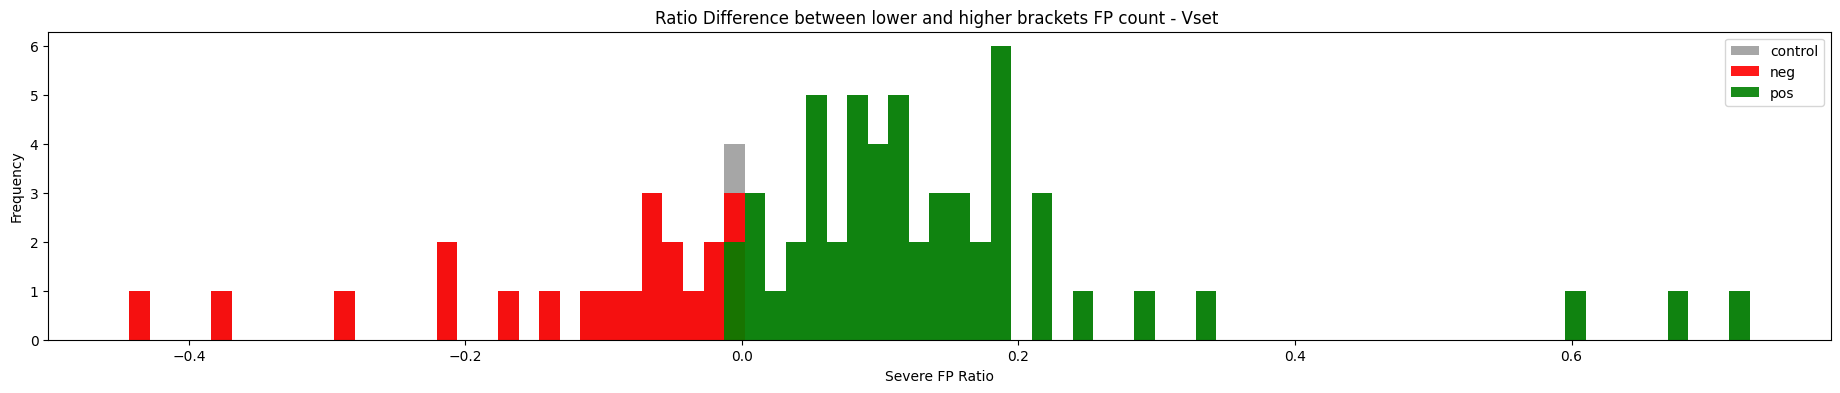

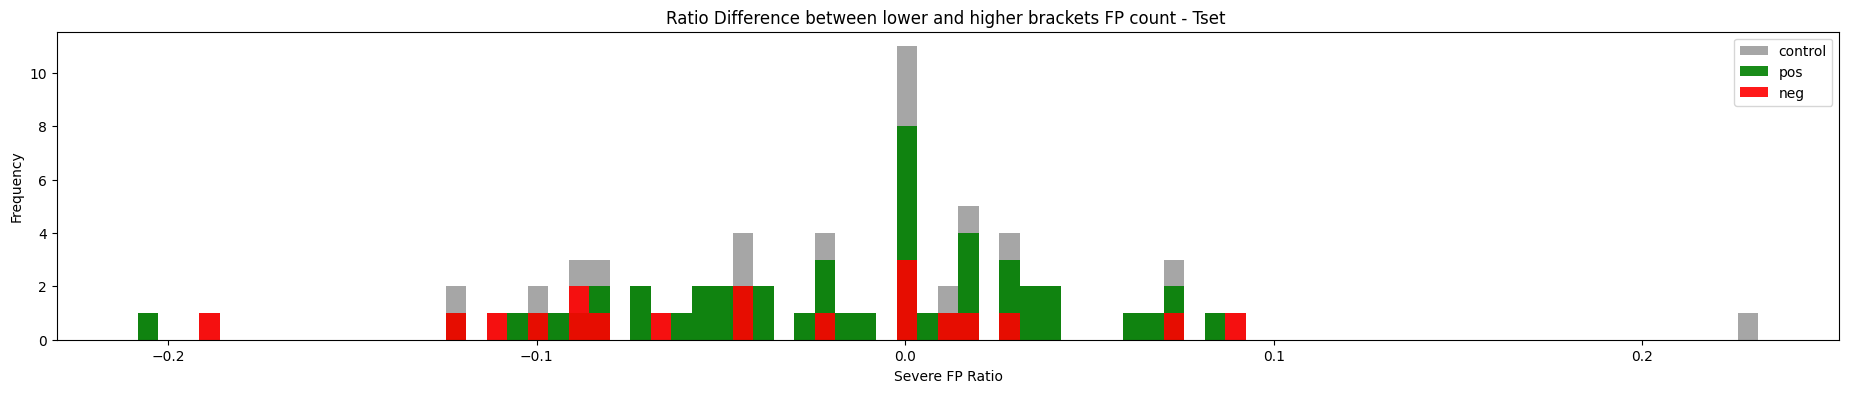

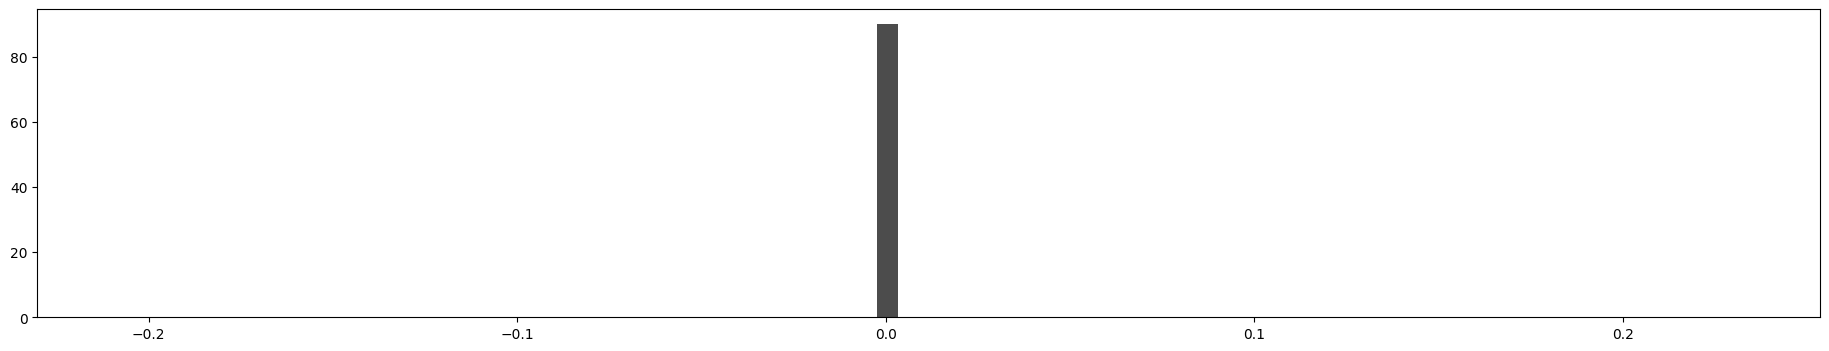

In [37]:
####                                                              TESTING min_ratio_difference between higher and lower brackets FP count 

## still to be tested: remove the pos high adn see fi the dist change is less severe 



# Run the model selection function with the new parameters
selected_models_control = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)

selected_models_test_POS_ratio = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference=0,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)


selected_models_test_NEG_ratio = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference= 0,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs= None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)

selected_models_control_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_control,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))

selected_models_test_POS_ratio_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_test_POS_ratio,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))

selected_models_test_NEG_ratio_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_test_NEG_ratio,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))

selected_models_control_TEST_ADJUSTED_FPs = recompute_metrics_ignoring_pos_fp(
    selected_models_output = selected_models_control_TEST,
    results_data = results_dist_disc_Tset_same_seeds_organized,
    targets=("pos_high"),
    fp_treatment="ignore",
)



# Print summary of selected models
print(f"Models Selected control: {len(selected_models_control)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models_control)
print(f"Total seeds selected control: {total_seeds}")

print(f"Models Selected POS: {len(selected_models_test_POS_ratio)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models_test_POS_ratio)
print(f"Total seeds selected POS: {total_seeds}")

print(f"Models Selected NEG: {len(selected_models_test_NEG_ratio)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models_test_NEG_ratio)
print(f"Total seeds selected NEG: {total_seeds}")

print(f"Models Selected LOW: {len(selected_models_control_TEST_ADJUSTED_FPs)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models_control_TEST_ADJUSTED_FPs)
print(f"Total seeds selected Adjusted Control: {total_seeds}")


#his tof all severe FPs among all MODELS

list_ALL_control = []
for i in selected_models_control:
    list_ALL_control.append(i["ratio_difference"])

list_ALL_control = [i for i in list_ALL_control if i is not None]

list_ALL_neg = []
for i in selected_models_test_NEG_ratio:
    list_ALL_neg.append(i["ratio_difference"])

list_ALL_pos = []
for i in selected_models_test_POS_ratio:
    list_ALL_pos.append(i["ratio_difference"])

######################

list_ALL_control_TEST = []
for i in selected_models_control_TEST:
    list_ALL_control_TEST.append(i["ratio_difference"])

list_ALL_control_TEST = [i for i in list_ALL_control_TEST if i is not None]

list_ALL_fp_severe_ratio_fps_control_TEST_ADJUSTED_FPs = []
for i in selected_models_control_TEST_ADJUSTED_FPs:
    list_ALL_fp_severe_ratio_fps_control_TEST_ADJUSTED_FPs.append(i["fp_severe_ratio_fps"])



list_ALL_neg_TEST = []
for i in selected_models_test_NEG_ratio_TEST:
    list_ALL_neg_TEST.append(i["ratio_difference"])

list_ALL_neg_TEST = [i for i in list_ALL_neg_TEST if i is not None]

list_ALL_pos_TEST = []
for i in selected_models_test_POS_ratio_TEST:
    list_ALL_pos_TEST.append(i["ratio_difference"])

list_ALL_pos_TEST = [i for i in list_ALL_pos_TEST if i is not None]


all_vals = list_ALL_control + list_ALL_neg + list_ALL_pos + list_ALL_fp_severe_ratio_fps_control_TEST_ADJUSTED_FPs
Bins = np.linspace(min(all_vals), max(all_vals), 80)  # 30 bins, same edges for all



plt.figure(figsize = (23 , 4))
plt.hist(list_ALL_control , bins=Bins , alpha = 0.7 , label = "control" , color = "grey")
plt.hist(list_ALL_neg , bins = Bins , alpha = 0.9 , label = "neg" , color = "red")
plt.hist(list_ALL_pos , bins = Bins , alpha = 0.9 , label = "pos" , color = "green")
plt.title("Ratio Difference between lower and higher brackets FP count - Vset ")
plt.xlabel("Severe FP Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()


all_vals = list_ALL_control_TEST + list_ALL_neg_TEST + list_ALL_pos_TEST + list_ALL_fp_severe_ratio_fps_control_TEST_ADJUSTED_FPs
Bins = np.linspace(min(all_vals), max(all_vals), 80)  # 30 bins, same edges for all


plt.figure(figsize = (23 , 4))
plt.hist(list_ALL_control_TEST , bins= Bins , alpha = 0.7 , label = "control" , color = "grey")
# plt.hist(list_ALL_fp_severe_ratio_fps_control_TEST_ADJUSTED_FPs , bins=Bins , alpha = 0.7 , label = "control - adjusted FPs" , color = "black" )
plt.hist(list_ALL_pos_TEST , bins = Bins , alpha = 0.9 , label = "pos" , color = "green")
plt.hist(list_ALL_neg_TEST , bins = Bins , alpha = 0.9 , label = "neg" , color = "red")
plt.title("Ratio Difference between lower and higher brackets FP count - Tset ")
plt.xlabel("Severe FP Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()


plt.figure(figsize = (23 , 4))
plt.hist(list_ALL_fp_severe_ratio_fps_control_TEST_ADJUSTED_FPs , bins=Bins , alpha = 0.7 , label = "control - adjusted FPs" , color = "black" )
plt.show()






Models Selected control: 90
Total seeds selected control: 4946
Models Selected high: 56
Total seeds selected high: 3356
Models Selected low: 23
Total seeds selected low: 948


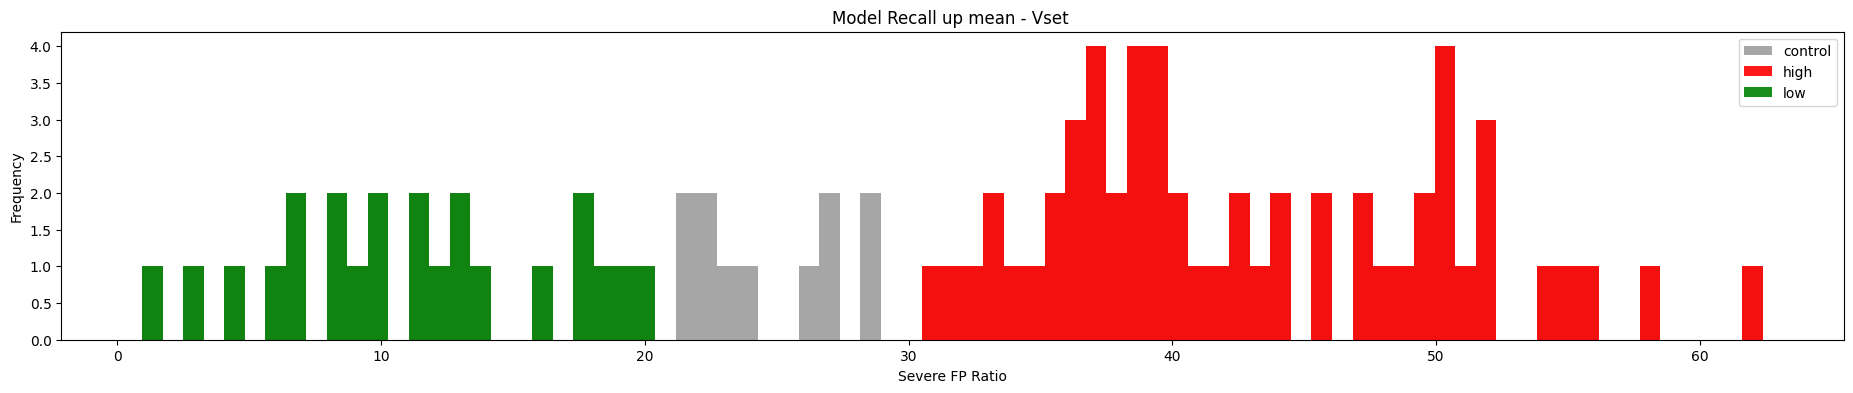

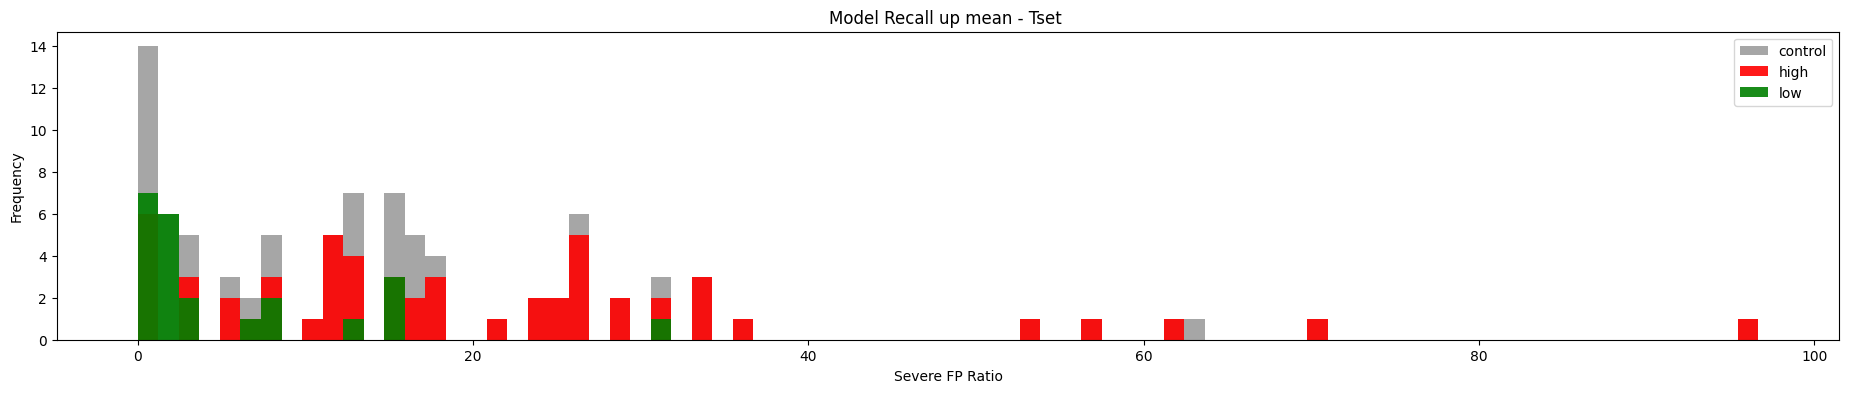

In [38]:
####                                                                    Testing for change is the dist of RECALL up in V vs T set  

## still to be tested: remove the pos high adn see fi the dist change is less severe 



# Run the model selection function with the new parameters
selected_models_control = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    mean_recall_up_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(0, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)

selected_models_test_low = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    mean_recall_up_range=(0, 20),
    seed_precision_range=(0, 100),
    seed_recall_range=(0, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)


selected_models_test_high = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    mean_recall_up_range=(30, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(0, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference= None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs= None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)

selected_models_control_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_control,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))

selected_models_test_high_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_test_high,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))

selected_models_test_low_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_test_low,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))




# Print summary of selected models
print(f"Models Selected control: {len(selected_models_control)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models_control)
print(f"Total seeds selected control: {total_seeds}")

print(f"Models Selected high: {len(selected_models_test_high)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models_test_high)
print(f"Total seeds selected high: {total_seeds}")

print(f"Models Selected low: {len(selected_models_test_low)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models_test_low)
print(f"Total seeds selected low: {total_seeds}")



#his tof all severe FPs among all MODELS

list_ALL_control = []
for i in selected_models_control:
    list_ALL_control.append(i["mean_recall_up"])
list_ALL_control = [i for i in list_ALL_control if i is not None]

list_ALL_high = []
for i in selected_models_test_high:
    list_ALL_high.append(i["mean_recall_up"])
list_ALL_high = [i for i in list_ALL_high if i is not None]

list_ALL_low = []
for i in selected_models_test_low:
    list_ALL_low.append(i["mean_recall_up"])
list_ALL_low = [i for i in list_ALL_low if i is not None]

######################

list_ALL_control_TEST = []
for i in selected_models_control_TEST:
    list_ALL_control_TEST.append(i["mean_recall_up"])
list_ALL_control_TEST = [i for i in list_ALL_control_TEST if i is not None]

list_ALL_high_TEST = []
for i in selected_models_test_high_TEST:
    list_ALL_high_TEST.append(i["mean_recall_up"])
list_ALL_high_TEST = [i for i in list_ALL_high_TEST if i is not None]

list_ALL_low_TEST = []
for i in selected_models_test_low_TEST:
    list_ALL_low_TEST.append(i["mean_recall_up"])
list_ALL_low_TEST = [i for i in list_ALL_low_TEST if i is not None]


all_vals = list_ALL_control + list_ALL_high + list_ALL_low
Bins = np.linspace(min(all_vals), max(all_vals), 80)  # 30 bins, same edges for all



plt.figure(figsize = (23 , 4))
plt.hist(list_ALL_control , bins=Bins , alpha = 0.7 , label = "control" , color = "grey")
plt.hist(list_ALL_high , bins = Bins , alpha = 0.9 , label = "high" , color = "red")
plt.hist(list_ALL_low , bins = Bins , alpha = 0.9 , label = "low" , color = "green")
plt.title("Model Recall up mean - Vset ")
plt.xlabel("Severe FP Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()


all_vals = list_ALL_control_TEST + list_ALL_low_TEST + list_ALL_high_TEST
Bins = np.linspace(min(all_vals), max(all_vals), 80)  # 30 bins, same edges for all


plt.figure(figsize = (23 , 4))
plt.hist(list_ALL_control_TEST , bins= Bins , alpha = 0.7 , label = "control" , color = "grey")
# plt.hist(list_ALL_fp_severe_ratio_fps_control_TEST_ADJUSTED_FPs , bins=Bins , alpha = 0.7 , label = "control - adjusted FPs" , color = "black" )
plt.hist(list_ALL_high_TEST , bins = Bins , alpha = 0.9 , label = "high" , color = "red")
plt.hist(list_ALL_low_TEST , bins = Bins , alpha = 0.9 , label = "low" , color = "green")
plt.title("Model Recall up mean - Tset ")
plt.xlabel("Severe FP Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()








In [39]:


# Run the model selection function with the new parameters
selected_models = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(75, 100),
    mean_recall_up_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=0,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)

# Print summary of selected models
print(f"Models Selected control: {len(selected_models)}")
total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
print(f"Total seeds selected control: {total_seeds}")


selected_models[0]

Models Selected control: 1
Total seeds selected control: 4


{'combo_index': 53,
 'parameters': {'binary_0_1_cutoff_ret_rate_percentage': 0.1,
  'learning_rate': 0.05,
  'num_epochs': 300,
  'batch_size': 70,
  'use_bidirectional': False,
  'lag': 6,
  'input_size': 12,
  'hidden_size': 35,
  'num_layers': 6,
  'use_monthly_dfs_only': True,
  'use_binary_0_1_retRate': False,
  'use_custom_loss_function_BCE_THRESH': False,
  'use_custom_loss_function_BCE_THRESH_AND_SEVERITY': False,
  'use_LOW_weights_for_BCE_custom_loss': True,
  'pred_threshold_sigmoid01_up': None,
  'use_binary_neg1_1': False,
  'use_ret_rate': False,
  'use_print_acc': False,
  'use_dropout': False,
  'use_class_weighting': False,
  'is_deterministic': True,
  'seed_num': 60607,
  'use_existing_lagged_data': True,
  'use_dynamic_weights': False,
  'use_binary_0_1_retRate_custom_neg': False,
  'use_binary_0_1_retRate_custom_pos': True,
  'POS_weight_multiplier': 1.3,
  'use_rolling_fixed_train_size': False,
  'use_existing_initial_weights': False,
  'state_dict': None,
  'use_

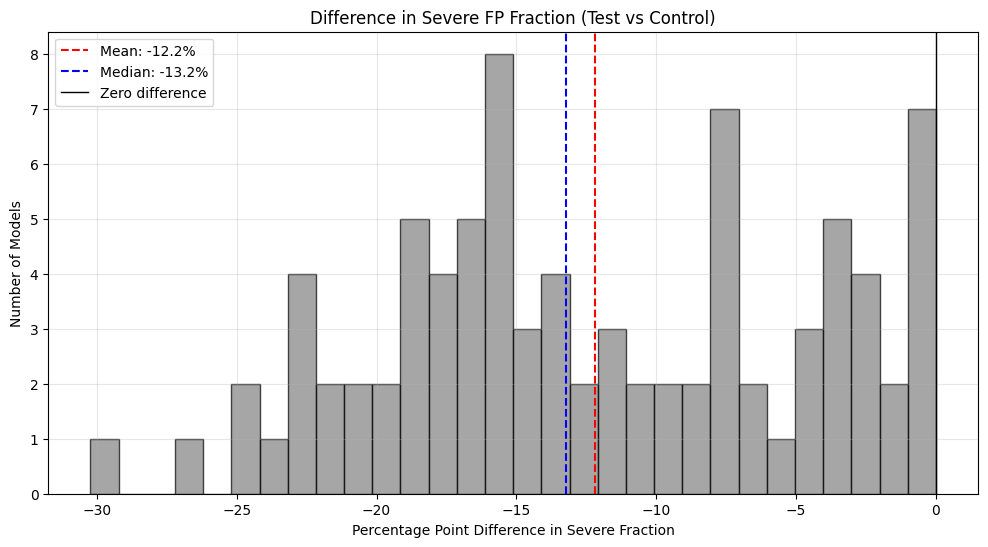

Models analyzed: 86
Mean difference: -12.19 percentage points
Median difference: -13.24 percentage points
Std deviation: 7.56 percentage points


In [40]:
######                                                                        Testing the difference in severe FP fraction between test and control models 

## use frations since the number of preds in the T set and the V set are different



selected_models_control = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs=None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)

selected_models_control_TEST = recompute_selected_models_on_Tset(
    results_dist_disc_Tset_same_seeds_organized,
    selected_models_control,
    brackets=((0.5, 0.7), (0.7, 1.0))
)

# Create mapping for model matching
test_models_map = {model["combo_index"]: model for model in selected_models_control_TEST}

# Calculate severe fraction differences
severe_fraction_differences = []
for control_model in selected_models_control:
    combo_idx = control_model["combo_index"]
    test_model = test_models_map.get(combo_idx)
    
    if test_model and "fp_severity_by_bracket" in control_model and "fp_severity_by_bracket" in test_model:
        # Calculate total FPs and severe FPs for control model
        control_total_fp = sum(bracket_counts["FP"] for bracket_counts in control_model["bracket_counts"].values())
        control_severe_fp = sum(bracket_data.get("Severe (<-0.12)", 0) 
                              for bracket_data in control_model["fp_severity_by_bracket"].values())
        
        # Calculate total FPs and severe FPs for test model
        test_total_fp = sum(bracket_counts["FP"] for bracket_counts in test_model["bracket_counts"].values())
        test_severe_fp = sum(bracket_data.get("Severe (<-0.12)", 0) 
                           for bracket_data in test_model["fp_severity_by_bracket"].values())
        
        # Calculate severe fractions
        if control_total_fp > 0 and test_total_fp > 0:
            control_severe_frac = control_severe_fp / control_total_fp
            test_severe_frac = test_severe_fp / test_total_fp
            
            # Calculate percentage difference in severe fraction
            severe_frac_diff = (test_severe_frac - control_severe_frac) * 100  # Convert to percentage
            severe_fraction_differences.append(severe_frac_diff)

# Plot results
if severe_fraction_differences:
    plt.figure(figsize=(12, 6))
    plt.hist(severe_fraction_differences, bins=30, alpha=0.7, color='grey', edgecolor='black')
    plt.axvline(np.mean(severe_fraction_differences), color='red', linestyle='--', 
                label=f'Mean: {np.mean(severe_fraction_differences):.1f}%')
    plt.axvline(np.median(severe_fraction_differences), color='blue', linestyle='--', 
                label=f'Median: {np.median(severe_fraction_differences):.1f}%')
    plt.axvline(0, color='black', linestyle='-', linewidth=1, label='Zero difference')
    plt.title("Difference in Severe FP Fraction (Test vs Control)")
    plt.xlabel("Percentage Point Difference in Severe Fraction")
    plt.ylabel("Number of Models")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print summary statistics
    print(f"Models analyzed: {len(severe_fraction_differences)}")
    print(f"Mean difference: {np.mean(severe_fraction_differences):.2f} percentage points")
    print(f"Median difference: {np.median(severe_fraction_differences):.2f} percentage points")
    print(f"Std deviation: {np.std(severe_fraction_differences):.2f} percentage points")

In [41]:
results_dist_disc_Tset_NOTsorted_same_seeds[0]

{'combo_number': 1,
 'parameters': {'binary_0_1_cutoff_ret_rate_percentage': 0.1,
  'learning_rate': 0.005,
  'num_epochs': 700,
  'batch_size': 50,
  'use_bidirectional': False,
  'lag': 2,
  'input_size': 12,
  'hidden_size': 12,
  'num_layers': 6,
  'use_monthly_dfs_only': True,
  'use_binary_0_1_retRate': False,
  'use_custom_loss_function_BCE_THRESH': False,
  'use_custom_loss_function_BCE_THRESH_AND_SEVERITY': False,
  'use_LOW_weights_for_BCE_custom_loss': True,
  'pred_threshold_sigmoid01_up': None,
  'use_binary_neg1_1': False,
  'use_ret_rate': False,
  'use_print_acc': False,
  'use_dropout': False,
  'use_class_weighting': False,
  'is_deterministic': True,
  'seed_num': 56183,
  'use_existing_lagged_data': True,
  'use_dynamic_weights': False,
  'use_binary_0_1_retRate_custom_neg': False,
  'use_binary_0_1_retRate_custom_pos': True,
  'POS_weight_multiplier': 1,
  'use_rolling_fixed_train_size': False,
  'use_existing_initial_weights': False,
  'state_dict': None,
  'use_U

In [42]:
#####                                  SEED BASED ANALYSIS: max_seed_severe_FPs_high_bracket and min_seed_TPs_high_bracket


# Run the model selection function with the new parameters
selected_models_control = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  
    random_seed=42,
    max_models_to_return=len(results_dist_disc)
)

selected_models_test_0_fps1tps = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=len(results_dist_disc),
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs=None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=0, #***
    min_seed_TPs_high_bracket=1,  #***
    random_seed=42,
    max_models_to_return= len(results_dist_disc)
)

selected_models_test_maxFP_severe_ratio_FPs = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds= len(results_dist_disc),  
    min_ratio_difference=None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs=.2,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None, #***
    min_seed_TPs_high_bracket=None,  #***
    random_seed=42,
    max_models_to_return= len(results_dist_disc)
)





selected_models_control_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_control,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))

selected_models_test_0_fps1tps_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_test_0_fps1tps,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))

selected_models_test_maxFP_severe_ratio_FPs_TEST = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
                                      selected_models_test_maxFP_severe_ratio_FPs,
                                      brackets=((0.5, 0.7), (0.7, 1.0)))



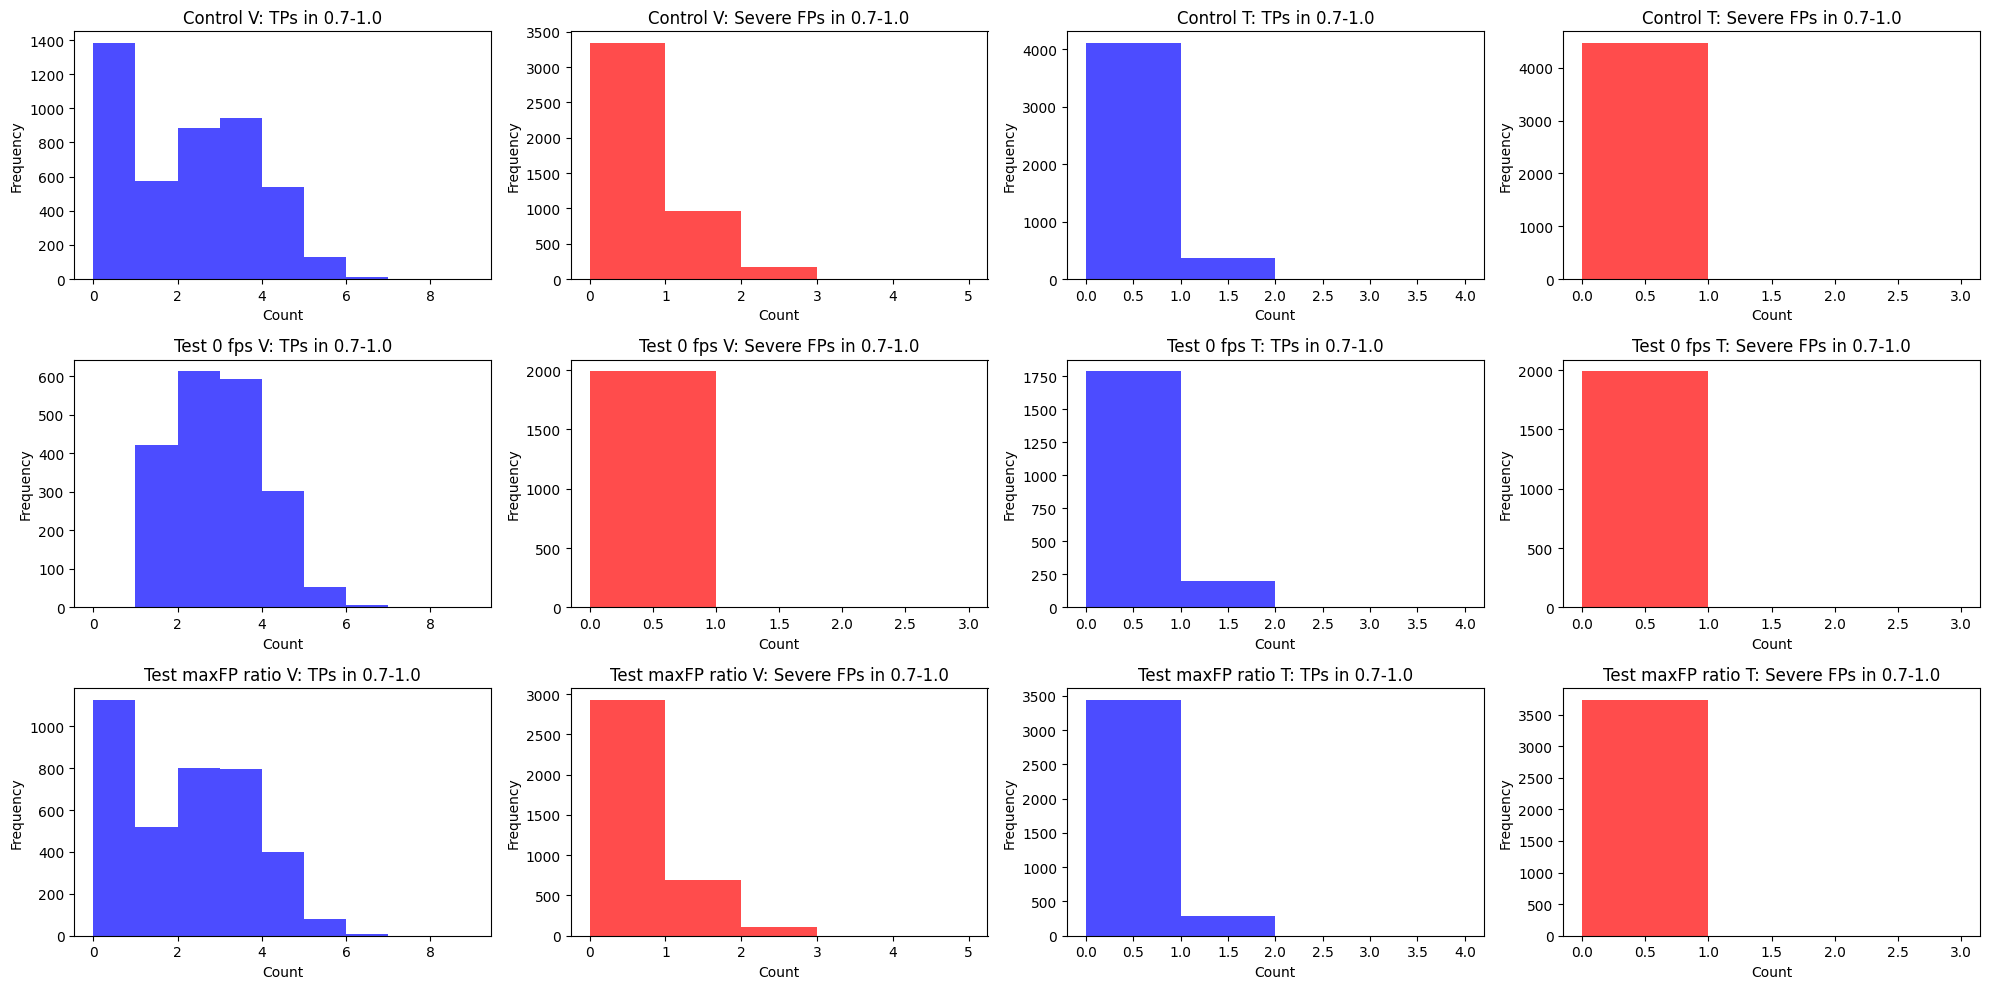

Control V seeds: 4470
Control T seeds: 4470
Test 0 fps V seeds: 1988
Test 0 fps T seeds: 1988
Test maxFP ratio V seeds: 3734
Test maxFP ratio T seeds: 3734

Severe FP Statistics:
Control V - Avg severe FPs: 0.29
Control T - Avg severe FPs: 0.00
Test 0 fps V - Avg severe FPs: 0.00
Test 0 fps T - Avg severe FPs: 0.00
Test maxFP ratio V - Avg severe FPs: 0.24
Test maxFP ratio T - Avg severe FPs: 0.00

Filtering check for test_highTP (max_severe_FPs_high_bracket=0):
Test 0 fps V - Seeds with 0 severe FPs: 1988/1988
Test 0 fps T - Seeds with 0 severe FPs: 1988/1988
Filtering check for test_maxFP_severe_ratio_FPs (max_FP_severe_ratio_FPs=0.2):
Test maxFP ratio V - Seeds with 0 severe FPs: 2930/3734
Test maxFP ratio T - Seeds with 0 severe FPs: 3734/3734

Filtering check for control (no severe FP filter):
Control T - Seeds with 0 severe FPs: 4470/4470


In [43]:
###### NOTE NOTE the results here are counterintuitive --- i think there is a overfitting problem here 
###### NOTE NOTE HOWEVER, if you include max_FP_Severe_ratio_FPs=.2 you get better results ... 

# Extract seed data from control models (V set)
control_v_high_bracket_tps = []
control_v_high_bracket_severe_fps = []  # Changed to severe FPs

for model in selected_models_control:
    for seed in model["selected_seeds"]:
        high_bracket = seed["seed_bracket_counts"].get("0.7-1.0", {"TP": 0, "FP": 0})
        control_v_high_bracket_tps.append(high_bracket["TP"])
        control_v_high_bracket_severe_fps.append(seed["seed_severe_fp_high_bracket"])  # Severe FPs

# Extract seed data from control models (T set)
control_t_high_bracket_tps = []
control_t_high_bracket_severe_fps = []  # Changed to severe FPs

for model in selected_models_control_TEST:
    for seed in model["selected_seeds"]:
        high_bracket = seed["seed_bracket_counts"].get("0.7-1.0", {"TP": 0, "FP": 0})
        control_t_high_bracket_tps.append(high_bracket["TP"])
        control_t_high_bracket_severe_fps.append(seed["seed_severe_fp_high_bracket"])  # Severe FPs



# Extract seed data from test_highTP models (V set)  
test_v_high_bracket_tps = []
test_v_high_bracket_severe_fps = []  # Changed to severe FPs

for model in selected_models_test_0_fps1tps:
    for seed in model["selected_seeds"]:
        high_bracket = seed["seed_bracket_counts"].get("0.7-1.0", {"TP": 0, "FP": 0})
        test_v_high_bracket_tps.append(high_bracket["TP"])
        test_v_high_bracket_severe_fps.append(seed["seed_severe_fp_high_bracket"])  # Severe FPs

# Extract seed data from test_0_fps models (T set)
test_t_high_bracket_tps = []
test_t_high_bracket_severe_fps = []  # Changed to severe FPs

for model in selected_models_test_0_fps1tps_TEST:
    for seed in model["selected_seeds"]:
        high_bracket = seed["seed_bracket_counts"].get("0.7-1.0", {"TP": 0, "FP": 0})
        test_t_high_bracket_tps.append(high_bracket["TP"])
        test_t_high_bracket_severe_fps.append(seed["seed_severe_fp_high_bracket"])  # Severe FPs




# Extract seed data from test_maxFP_severe_ratio_FPs models (V set)  
test_v_maxFP_severe_ratio_FPs_high_bracket_tps = []
test_v_maxFP_severe_ratio_FPs_high_bracket_severe_fps = []  # Changed to severe FPs 
for model in selected_models_test_maxFP_severe_ratio_FPs:
    for seed in model["selected_seeds"]:
        high_bracket = seed["seed_bracket_counts"].get("0.7-1.0", {"TP": 0, "FP": 0})
        test_v_maxFP_severe_ratio_FPs_high_bracket_tps.append(high_bracket["TP"])
        test_v_maxFP_severe_ratio_FPs_high_bracket_severe_fps.append(seed["seed_severe_fp_high_bracket"])  # Severe FPs


# Extract seed data from test_maxFP_severe_ratio_FPs models (T set)
test_t_maxFP_severe_ratio_FPs_high_bracket_tps = []
test_t_maxFP_severe_ratio_FPs_high_bracket_severe_fps = []  # Changed to severe FPs
for model in selected_models_test_maxFP_severe_ratio_FPs_TEST:
    for seed in model["selected_seeds"]:
        high_bracket = seed["seed_bracket_counts"].get("0.7-1.0", {"TP": 0, "FP": 0})
        test_t_maxFP_severe_ratio_FPs_high_bracket_tps.append(high_bracket["TP"])
        test_t_maxFP_severe_ratio_FPs_high_bracket_severe_fps.append(seed["seed_severe_fp_high_bracket"])  # Severe FPs



# Create the 8 plots
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

# Control V set
axes[0,0].hist(control_v_high_bracket_tps, bins=range(0, max(control_v_high_bracket_tps)+4), alpha=0.7, color='blue')
axes[0,0].set_title('Control V: TPs in 0.7-1.0')
axes[0,1].hist(control_v_high_bracket_severe_fps, bins=range(0, max(control_v_high_bracket_severe_fps)+4), alpha=0.7, color='red')
axes[0,1].set_title('Control V: Severe FPs in 0.7-1.0')

# Control T set
axes[0,2].hist(control_t_high_bracket_tps, bins=range(0, max(control_t_high_bracket_tps)+4), alpha=0.7, color='blue')
axes[0,2].set_title('Control T: TPs in 0.7-1.0')
axes[0,3].hist(control_t_high_bracket_severe_fps, bins=range(0, max(control_t_high_bracket_severe_fps)+4), alpha=0.7, color='red')
axes[0,3].set_title('Control T: Severe FPs in 0.7-1.0')

# Test 0 fps V set
axes[1,0].hist(test_v_high_bracket_tps, bins=range(0, max(test_v_high_bracket_tps)+4), alpha=0.7, color='blue')
axes[1,0].set_title('Test 0 fps V: TPs in 0.7-1.0')
axes[1,1].hist(test_v_high_bracket_severe_fps, bins=range(0, max(test_v_high_bracket_severe_fps)+4), alpha=0.7, color='red')
axes[1,1].set_title('Test 0 fps V: Severe FPs in 0.7-1.0')

# Test 0 fps T set
axes[1,2].hist(test_t_high_bracket_tps, bins=range(0, max(test_t_high_bracket_tps)+4), alpha=0.7, color='blue')
axes[1,2].set_title('Test 0 fps T: TPs in 0.7-1.0')
axes[1,3].hist(test_t_high_bracket_severe_fps, bins=range(0, max(test_t_high_bracket_severe_fps)+4), alpha=0.7, color='red')
axes[1,3].set_title('Test 0 fps T: Severe FPs in 0.7-1.0')


# Test 0 maxFPratio V set

axes[2,0].hist(test_v_maxFP_severe_ratio_FPs_high_bracket_tps, bins=range(0, max(test_v_maxFP_severe_ratio_FPs_high_bracket_tps)+4), alpha=0.7, color='blue')
axes[2,0].set_title('Test maxFP ratio V: TPs in 0.7-1.0')
axes[2,1].hist(test_v_maxFP_severe_ratio_FPs_high_bracket_severe_fps, bins=range(0, max(test_v_maxFP_severe_ratio_FPs_high_bracket_severe_fps)+4), alpha=0.7, color='red')
axes[2,1].set_title('Test maxFP ratio V: Severe FPs in 0.7-1.0')


# Test 0 maxFPratio T set
axes[2,2].hist(test_t_maxFP_severe_ratio_FPs_high_bracket_tps, bins=range(0, max(test_t_maxFP_severe_ratio_FPs_high_bracket_tps)+4), alpha=0.7, color='blue')
axes[2,2].set_title('Test maxFP ratio T: TPs in 0.7-1.0')
axes[2,3].hist(test_t_maxFP_severe_ratio_FPs_high_bracket_severe_fps, bins=range(0, max(test_t_maxFP_severe_ratio_FPs_high_bracket_severe_fps)+4), alpha=0.7, color='red')
axes[2,3].set_title('Test maxFP ratio T: Severe FPs in 0.7-1.0')



# Set labels
for ax in axes.flat:
    ax.set(xlabel='Count', ylabel='Frequency')

plt.tight_layout()
plt.show()

# Print stats
print(f"Control V seeds: {len(control_v_high_bracket_tps)}")
print(f"Control T seeds: {len(control_t_high_bracket_tps)}")
print(f"Test 0 fps V seeds: {len(test_v_high_bracket_tps)}")
print(f"Test 0 fps T seeds: {len(test_t_high_bracket_tps)}")
print(f"Test maxFP ratio V seeds: {len(test_v_maxFP_severe_ratio_FPs_high_bracket_tps)}")
print(f"Test maxFP ratio T seeds: {len(test_t_maxFP_severe_ratio_FPs_high_bracket_tps)}")

# Print severe FP statistics
print(f"\nSevere FP Statistics:")
print(f"Control V - Avg severe FPs: {np.mean(control_v_high_bracket_severe_fps):.2f}")
print(f"Control T - Avg severe FPs: {np.mean(control_t_high_bracket_severe_fps):.2f}")
print(f"Test 0 fps V - Avg severe FPs: {np.mean(test_v_high_bracket_severe_fps):.2f}")
print(f"Test 0 fps T - Avg severe FPs: {np.mean(test_t_high_bracket_severe_fps):.2f}")
print(f"Test maxFP ratio V - Avg severe FPs: {np.mean(test_v_maxFP_severe_ratio_FPs_high_bracket_severe_fps):.2f}")
print(f"Test maxFP ratio T - Avg severe FPs: {np.mean(test_t_maxFP_severe_ratio_FPs_high_bracket_severe_fps):.2f}")

# Check if filtering worked correctly for test_highTP
print(f"\nFiltering check for test_highTP (max_severe_FPs_high_bracket=0):")
print(f"Test 0 fps V - Seeds with 0 severe FPs: {sum(1 for x in test_v_high_bracket_severe_fps if x == 0)}/{len(test_v_high_bracket_severe_fps)}")
print(f"Test 0 fps T - Seeds with 0 severe FPs: {sum(1 for x in test_t_high_bracket_severe_fps if x == 0)}/{len(test_t_high_bracket_severe_fps)}")
print(f"Filtering check for test_maxFP_severe_ratio_FPs (max_FP_severe_ratio_FPs=0.2):")
print(f"Test maxFP ratio V - Seeds with 0 severe FPs: {sum(1 for x in test_v_maxFP_severe_ratio_FPs_high_bracket_severe_fps if x == 0)}/{len(test_v_maxFP_severe_ratio_FPs_high_bracket_severe_fps)}")
print(f"Test maxFP ratio T - Seeds with 0 severe FPs: {sum(1 for x in test_t_maxFP_severe_ratio_FPs_high_bracket_severe_fps if x == 0)}/{len(test_t_maxFP_severe_ratio_FPs_high_bracket_severe_fps)}")

print(f"\nFiltering check for control (no severe FP filter):")

print(f"Control T - Seeds with 0 severe FPs: {sum(1 for x in control_t_high_bracket_severe_fps if x == 0)}/{len(control_t_high_bracket_severe_fps)}")

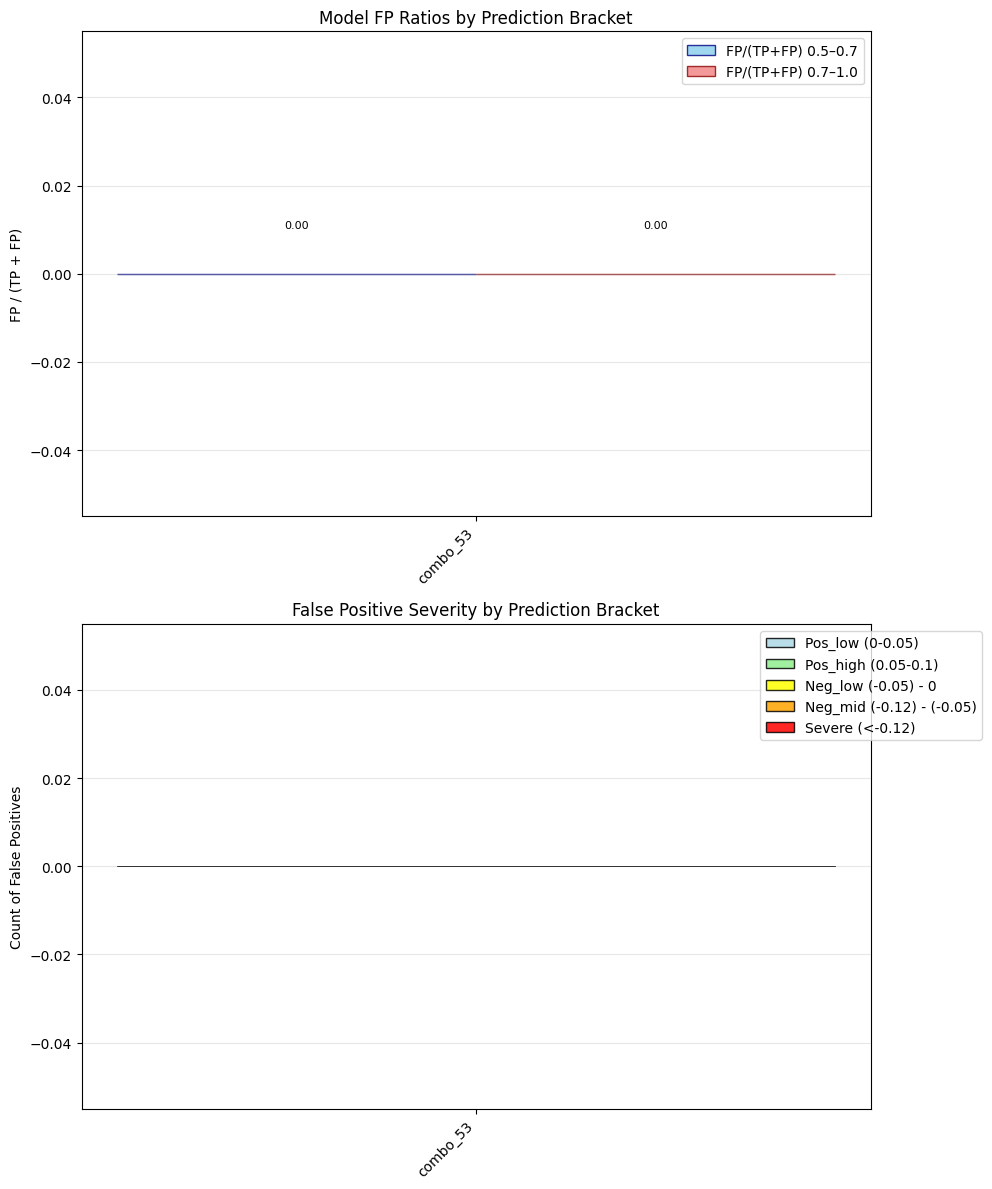

In [44]:
import numpy as np
import matplotlib.pyplot as plt

SEVERITY_CATS = [
    "Pos_low (0-0.05)",
    "Pos_high (0.05-0.1)",
    "Neg_low (-0.05) - 0",
    "Neg_mid (-0.12) - (-0.05)",
    "Severe (<-0.12)",
]
SEVERITY_COLORS = {
    "Pos_low (0-0.05)": 'lightblue',
    "Pos_high (0.05-0.1)": 'lightgreen',
    "Neg_low (-0.05) - 0": 'yellow',
    "Neg_mid (-0.12) - (-0.05)": 'orange',
    "Severe (<-0.12)": 'red',
    "Other": 'gray',
}

if not selected_models:
    print("No models to plot.")
else:
    labels = [f"combo_{m['combo_index']}" for m in selected_models]
    x = np.arange(len(labels))
    width = 0.35

    # --- Plot 1: FP Ratios (from fp_tp_ratios in selected_models) ---
    r_05_07 = [m.get("fp_tp_ratios", {}).get("0.5-0.7", np.nan) for m in selected_models]
    r_07_10 = [m.get("fp_tp_ratios", {}).get("0.7-1.0", np.nan) for m in selected_models]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(10, len(labels)*0.8), 12))

    b1 = ax1.bar(x - width/2, r_05_07, width, label='FP/(TP+FP) 0.5–0.7',
                 alpha=0.8, color='skyblue', edgecolor='navy')
    b2 = ax1.bar(x + width/2, r_07_10, width, label='FP/(TP+FP) 0.7–1.0',
                 alpha=0.8, color='lightcoral', edgecolor='darkred')
    ax1.set_xticks(x); ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_ylabel('FP / (TP + FP)'); ax1.set_title('Model FP Ratios by Prediction Bracket')
    ax1.legend(); ax1.grid(True, alpha=0.3, axis='y')

    for i, (v1, v2) in enumerate(zip(r_05_07, r_07_10)):
        if not np.isnan(v1): ax1.text(i - width/2, v1 + 0.01, f'{v1:.2f}', ha='center', va='bottom', fontsize=8)
        if not np.isnan(v2): ax1.text(i + width/2, v2 + 0.01, f'{v2:.2f}', ha='center', va='bottom', fontsize=8)

    # --- Plot 2: Severity Breakdown (read from fp_severity_by_bracket) ---
    # Build arrays directly from each model's fp_severity_by_bracket
    def get_counts(model, bracket_key, cat):
        d = model.get("fp_severity_by_bracket", {}).get(bracket_key, {})
        return int(d.get(cat, 0))

    low_data  = {cat: [get_counts(m, "0.5-0.7", cat) for m in selected_models] for cat in SEVERITY_CATS}
    high_data = {cat: [get_counts(m, "0.7-1.0", cat) for m in selected_models] for cat in SEVERITY_CATS}

    bottom_low  = np.zeros(len(labels))
    bottom_high = np.zeros(len(labels))
    legend_handles = []

    for cat in SEVERITY_CATS:
        color = SEVERITY_COLORS.get(cat, 'gray')
        ax2.bar(x - width/2, low_data[cat],  width, bottom=bottom_low,  color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
        ax2.bar(x + width/2, high_data[cat], width, bottom=bottom_high, color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
        bottom_low  += np.array(low_data[cat])
        bottom_high += np.array(high_data[cat])
        legend_handles.append(plt.Rectangle((0,0), 1, 1, fc=color, alpha=0.85, label=cat, edgecolor='black'))

    ax2.set_xticks(x); ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_ylabel('Count of False Positives')
    ax2.set_title('False Positive Severity by Prediction Bracket')
    ax2.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.15, 1))
    ax2.grid(True, alpha=0.3, axis='y')

    # Totals above bars
    total_low  = bottom_low
    total_high = bottom_high
    for i in range(len(labels)):
        if total_low[i]  > 0: ax2.text(i - width/2, total_low[i]  + 0.5, int(total_low[i]),  ha='center', va='bottom', fontsize=9, fontweight='bold')
        if total_high[i] > 0: ax2.text(i + width/2, total_high[i] + 0.5, int(total_high[i]), ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # # --- Summary printout using the same data (no raw re-walk) ---
    # print("\n" + "="*60)
    # print("SEVERE CASE PROPORTIONS BY BRACKET")
    # print("="*60)
    # for i, label in enumerate(labels):
    #     low_counts  = [low_data[cat][i]  for cat in SEVERITY_CATS]
    #     high_counts = [high_data[cat][i] for cat in SEVERITY_CATS]
    #     total_low   = sum(low_counts)
    #     total_high  = sum(high_counts)
    #     severe_low  = low_data["Severe (<-0.12)"][i]
    #     severe_high = high_data["Severe (<-0.12)"][i]

    #     prop_low  = (severe_low  / total_low  * 100) if total_low  > 0 else 0
    #     prop_high = (severe_high / total_high * 100) if total_high > 0 else 0

    #     print(f"{label}:")
    #     print(f"  Low bracket (0.5-0.7): {prop_low:.1f}% severe ({severe_low}/{total_low})")
    #     print(f"  High bracket (0.7-1.0): {prop_high:.1f}% severe ({severe_high}/{total_high})")
    #     print("-" * 40)


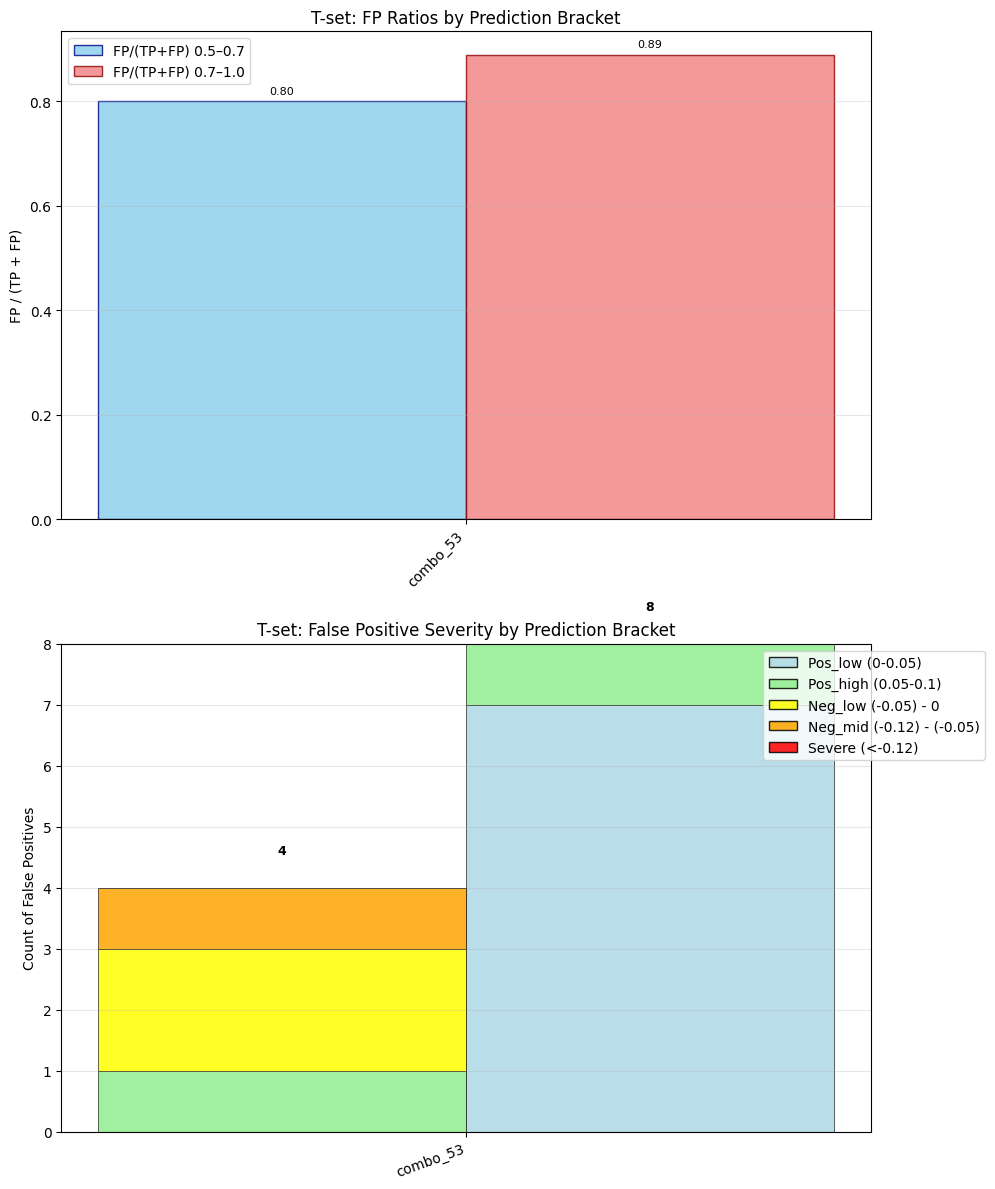

In [45]:
import numpy as np
import matplotlib.pyplot as plt

SEVERITY_CATS = [
    "Pos_low (0-0.05)",
    "Pos_high (0.05-0.1)",
    "Neg_low (-0.05) - 0",
    "Neg_mid (-0.12) - (-0.05)",
    "Severe (<-0.12)",
]
SEVERITY_COLORS = {
    "Pos_low (0-0.05)": 'lightblue',
    "Pos_high (0.05-0.1)": 'lightgreen',
    "Neg_low (-0.05) - 0": 'yellow',
    "Neg_mid (-0.12) - (-0.05)": 'orange',
    "Severe (<-0.12)": 'red',
    "Other": 'gray',
}

# 1) Get T-set metrics for the SAME selected models/seeds
tset_outputs = recompute_selected_models_on_Tset(
    results_dist_disc_Tset_same_seeds_organized,
    selected_models,
    brackets=((0.5, 0.7), (0.7, 1.0))
)

if not tset_outputs:
    print("No T-set models to plot.")
else:
    labels = [f"combo_{m['combo_index']}" for m in tset_outputs]
    x = np.arange(len(labels))
    width = 0.35

    # 2) Ratios directly from output
    r_05_07 = [m.get("fp_tp_ratios", {}).get("0.5-0.7", np.nan) for m in tset_outputs]
    r_07_10 = [m.get("fp_tp_ratios", {}).get("0.7-1.0", np.nan) for m in tset_outputs]

    # 3) Severity-by-bracket directly from output
    def get_counts(model, bracket_key, cat):
        return int(model.get("fp_severity_by_bracket", {}).get(bracket_key, {}).get(cat, 0))

    low_data  = {cat: [get_counts(m, "0.5-0.7", cat) for m in tset_outputs] for cat in SEVERITY_CATS}
    high_data = {cat: [get_counts(m, "0.7-1.0", cat) for m in tset_outputs] for cat in SEVERITY_CATS}

    # ----------------- PLOTS -----------------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(10, len(labels)*0.8), 12))

    # Plot 1: FP ratios
    ax1.bar(x - width/2, r_05_07, width, label='FP/(TP+FP) 0.5–0.7',
            alpha=0.8, color='skyblue', edgecolor='navy', linewidth=1)
    ax1.bar(x + width/2, r_07_10, width, label='FP/(TP+FP) 0.7–1.0',
            alpha=0.8, color='lightcoral', edgecolor='darkred', linewidth=1)
    ax1.set_xticks(x); ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_ylabel('FP / (TP + FP)'); ax1.set_title('T-set: FP Ratios by Prediction Bracket')
    ax1.legend(); ax1.grid(True, alpha=0.3, axis='y')

    for i, (v1, v2) in enumerate(zip(r_05_07, r_07_10)):
        if not np.isnan(v1): ax1.text(i - width/2, v1 + 0.01, f'{v1:.2f}', ha='center', va='bottom', fontsize=8)
        if not np.isnan(v2): ax1.text(i + width/2, v2 + 0.01, f'{v2:.2f}', ha='center', va='bottom', fontsize=8)

    # Plot 2: Stacked FP severity by bracket
    bottom_low  = np.zeros(len(labels))
    bottom_high = np.zeros(len(labels))
    legend_handles = []

    for cat in SEVERITY_CATS:
        color = SEVERITY_COLORS.get(cat, 'gray')
        ax2.bar(x - width/2, low_data[cat],  width, bottom=bottom_low,  color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
        ax2.bar(x + width/2, high_data[cat], width, bottom=bottom_high, color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
        bottom_low  += np.array(low_data[cat])
        bottom_high += np.array(high_data[cat])
        legend_handles.append(plt.Rectangle((0,0),1,1,fc=color,alpha=0.85,label=cat,edgecolor='black'))

    ax2.set_xticks(x); ax2.set_xticklabels(labels, rotation=20, ha='right')
    ax2.set_ylabel('Count of False Positives')
    ax2.set_title('T-set: False Positive Severity by Prediction Bracket')
    ax2.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.15, 1))
    ax2.grid(True, alpha=0.3, axis='y')

    # Totals above bars
    for i in range(len(labels)):
        total_low  = int(sum(low_data[cat][i]  for cat in SEVERITY_CATS))
        total_high = int(sum(high_data[cat][i] for cat in SEVERITY_CATS))
        if total_low  > 0: ax2.text(i - width/2, total_low  + 0.5, total_low,  ha='center', va='bottom', fontsize=9, fontweight='bold')
        if total_high > 0: ax2.text(i + width/2, total_high + 0.5, total_high, ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # # ----------------- SUMMARY -----------------
    # print("\n" + "="*60)
    # print("SEVERE CASE PROPORTIONS BY BRACKET")
    # print("="*60)
    # for i, label in enumerate(labels):
    #     total_low  = int(sum(low_data[cat][i]  for cat in SEVERITY_CATS))
    #     total_high = int(sum(high_data[cat][i] for cat in SEVERITY_CATS))
    #     severe_low  = low_data["Severe (<-0.12)"][i]
    #     severe_high = high_data["Severe (<-0.12)"][i]
    #     prop_low  = (severe_low  / total_low  * 100) if total_low  > 0 else 0
    #     prop_high = (severe_high / total_high * 100) if total_high > 0 else 0
    #     print(f"{label}:")
    #     print(f"  Low bracket (0.5-0.7): {prop_low:.1f}% severe ({severe_low}/{total_low})")
    #     print(f"  High bracket (0.7-1.0): {prop_high:.1f}% severe ({severe_high}/{total_high})")
    #     print("-" * 40)


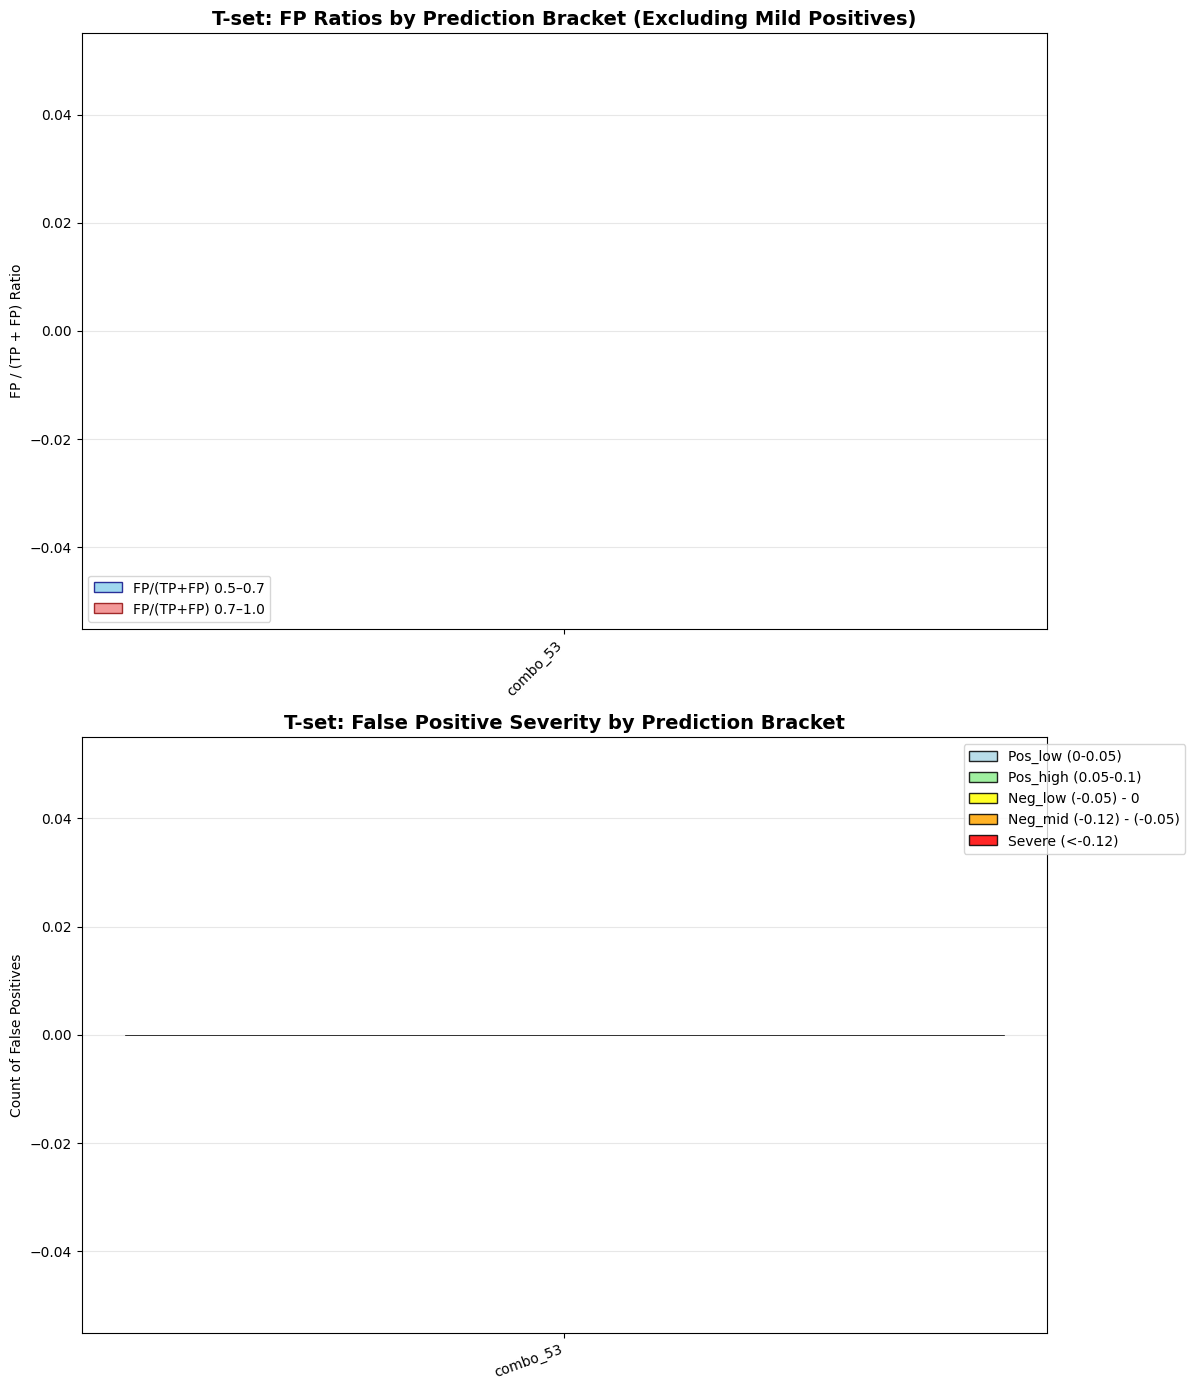

In [46]:
import numpy as np
import matplotlib.pyplot as plt

SEVERITY_CATS = [
    "Pos_low (0-0.05)",
    "Pos_high (0.05-0.1)",
    "Neg_low (-0.05) - 0",
    "Neg_mid (-0.12) - (-0.05)",
    "Severe (<-0.12)",
]
SEVERITY_COLORS = {
    "Pos_low (0-0.05)": 'lightblue',
    "Pos_high (0.05-0.1)": 'lightgreen',
    "Neg_low (-0.05) - 0": 'yellow',
    "Neg_mid (-0.12) - (-0.05)": 'orange',
    "Severe (<-0.12)": 'red',
    "Other": 'gray',
}

# --- Build T-set metrics using the helpers you already have ---
# 1) Baseline: keep Pos_low/Pos_high FPs
tset_keep = recompute_metrics_ignoring_pos_fp(
    selected_models_output=selected_models,
    results_data=results_dist_disc_Tset_same_seeds_organized,
    targets=("pos_low", "pos_high"),
    fp_treatment="keep",
)

# 2) Exclude mild positives: ignore Pos_low/Pos_high FPs
tset_ignore = recompute_metrics_ignoring_pos_fp(
    selected_models_output=selected_models,
    results_data=results_dist_disc_Tset_same_seeds_organized,
    targets=("pos_low", "pos_high"),
    fp_treatment="ignore",
)

if not tset_keep:
    print("No T-set models to plot.")
else:
    labels = [f"combo_{m['combo_index']}" for m in tset_keep]
    x = np.arange(len(labels))
    width = 0.35

    def get_ratio(models, key):
        return [m.get("fp_tp_ratios", {}).get(key, np.nan) for m in models]

    # choose which set to visualize
    EXCLUDE_MILD_POSITIVES = True  # toggle here
    current = tset_ignore if EXCLUDE_MILD_POSITIVES else tset_keep
    title_suffix = " (Excluding Mild Positives)" if EXCLUDE_MILD_POSITIVES else " (All FPs)"

    r_05_07 = get_ratio(current, "0.5-0.7")
    r_07_10 = get_ratio(current, "0.7-1.0")

    # severity-by-bracket from the model outputs
    def get_counts(model, bracket_key, cat):
        return int(model.get("fp_severity_by_bracket", {}).get(bracket_key, {}).get(cat, 0))

    low_data  = {cat: [get_counts(m, "0.5-0.7", cat) for m in current] for cat in SEVERITY_CATS}
    high_data = {cat: [get_counts(m, "0.7-1.0", cat) for m in current] for cat in SEVERITY_CATS}

    # ----------------- PLOTS -----------------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(12, len(labels)*0.8), 14))

    # Plot 1: FP ratios
    ax1.bar(x - width/2, r_05_07, width, label='FP/(TP+FP) 0.5–0.7',
            alpha=0.8, color='skyblue', edgecolor='navy', linewidth=1)
    ax1.bar(x + width/2, r_07_10, width, label='FP/(TP+FP) 0.7–1.0',
            alpha=0.8, color='lightcoral', edgecolor='darkred', linewidth=1)
    ax1.set_xticks(x); ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_ylabel('FP / (TP + FP) Ratio')
    ax1.set_title(f'T-set: FP Ratios by Prediction Bracket{title_suffix}', fontsize=14, fontweight='bold')
    ax1.legend(); ax1.grid(True, alpha=0.3, axis='y')

    for i, (v1, v2) in enumerate(zip(r_05_07, r_07_10)):
        if not np.isnan(v1): ax1.text(i - width/2, v1 + 0.01, f'{v1:.2f}', ha='center', va='bottom', fontsize=8)
        if not np.isnan(v2): ax1.text(i + width/2, v2 + 0.01, f'{v2:.2f}', ha='center', va='bottom', fontsize=8)

    # Plot 2: stacked FP severity by bracket
    bottom_low  = np.zeros(len(labels))
    bottom_high = np.zeros(len(labels))
    legend_handles = []

    for cat in SEVERITY_CATS:
        color = SEVERITY_COLORS.get(cat, 'gray')
        ax2.bar(x - width/2, low_data[cat],  width, bottom=bottom_low,  color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
        ax2.bar(x + width/2, high_data[cat], width, bottom=bottom_high, color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
        bottom_low  += np.array(low_data[cat])
        bottom_high += np.array(high_data[cat])
        legend_handles.append(plt.Rectangle((0,0), 1, 1, fc=color, alpha=0.85, label=cat, edgecolor='black'))

    ax2.set_xticks(x); ax2.set_xticklabels(labels, rotation=20, ha='right')
    ax2.set_ylabel('Count of False Positives')
    ax2.set_title('T-set: False Positive Severity by Prediction Bracket', fontsize=14, fontweight='bold')
    ax2.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.15, 1))
    ax2.grid(True, alpha=0.3, axis='y')

    # Totals above bars
    for i in range(len(labels)):
        total_low  = int(sum(low_data[cat][i]  for cat in SEVERITY_CATS))
        total_high = int(sum(high_data[cat][i] for cat in SEVERITY_CATS))
        if total_low  > 0: ax2.text(i - width/2, total_low  + 0.5, total_low,  ha='center', va='bottom', fontsize=9, fontweight='bold')
        if total_high > 0: ax2.text(i + width/2, total_high + 0.5, total_high, ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # # ----------------- COMPARISON PRINT (keep vs ignore) -----------------
    # print("\n" + "="*60)
    # print("COMPARISON: FP RATIOS WITH vs WITHOUT MILD POSITIVES (T-set)")
    # print("="*60)
    # base_05_07 = get_ratio(tset_keep,   "0.5-0.7")
    # base_07_10 = get_ratio(tset_keep,   "0.7-1.0")
    # ign_05_07  = get_ratio(tset_ignore, "0.5-0.7")
    # ign_07_10  = get_ratio(tset_ignore, "0.7-1.0")

    # for i, label in enumerate(labels):
    #     b1, b2 = base_05_07[i], base_07_10[i]
    #     n1, n2 = ign_05_07[i],  ign_07_10[i]
    #     if not (np.isnan(b1) or np.isnan(n1) or np.isnan(b2) or np.isnan(n2)):
    #         print(f"{label}:")
    #         print(f"  0.5-0.7: {b1:.3f} → {n1:.3f} (Δ={n1-b1:+.3f})")
    #         print(f"  0.7-1.0: {b2:.3f} → {n2:.3f} (Δ={n2-b2:+.3f})")
    #         print("-" * 30)


In [47]:
selected_models = select_models_by_criteria(
    results_dist_disc,
    mean_precision_range=(0, 100),
    seed_precision_range=(0, 100),
    seed_recall_range=(1, 100),
    min_seeds_per_model=1,
    max_zero_precision_seeds=70,
    min_ratio_difference= None,
    max_ratio_difference=None,
    seed_min_TPminusFP_greaterEqual=None,
    max_FP_severe_ratio_FPs= None,
    max_FP_severe_ratio_FPs_andTPs=None,
    min_FP_severe_ratio_FPs=None,
    min_FP_severe_ratio_FPs_andTPs=None,
    max_seed_severe_FPs_high_bracket=None,
    min_seed_TPs_high_bracket=None,  # NEW: Add the parameter here
    random_seed=42,
    max_models_to_return= len(results_dist_disc)
)

/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_34246/2382887675.py:136: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax6.boxplot(pdata, labels=['Original', 'Exclude', 'Reclassify'])


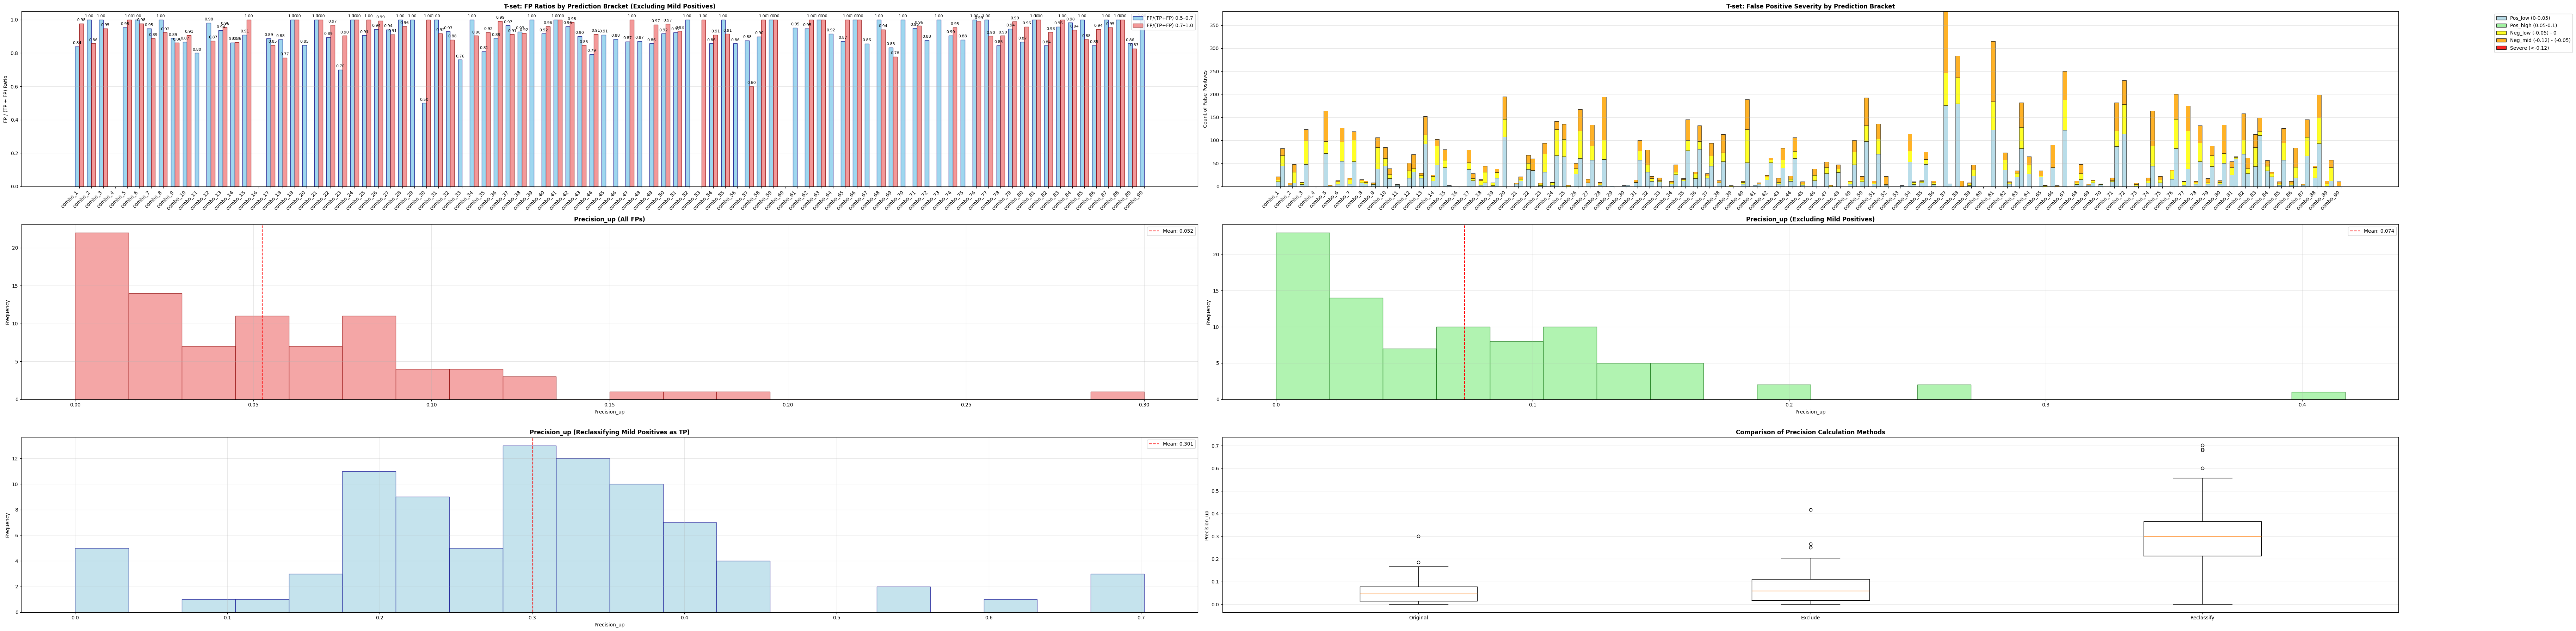

In [48]:
import numpy as np
import matplotlib.pyplot as plt

SEVERITY_CATS = [
    "Pos_low (0-0.05)",
    "Pos_high (0.05-0.1)",
    "Neg_low (-0.05) - 0",
    "Neg_mid (-0.12) - (-0.05)",
    "Severe (<-0.12)",
]
SEVERITY_COLORS = {
    "Pos_low (0-0.05)": 'lightblue',
    "Pos_high (0.05-0.1)": 'lightgreen',
    "Neg_low (-0.05) - 0": 'yellow',
    "Neg_mid (-0.12) - (-0.05)": 'orange',
    "Severe (<-0.12)": 'red',
    "Other": 'gray',
}

# --- 1) Build T-set metrics using the helper (no raw loops) ---
tset_keep = recompute_metrics_ignoring_pos_fp(
    selected_models_output=selected_models,
    results_data=results_dist_disc_Tset_same_seeds_organized,
    targets=("pos_low", "pos_high"),
    fp_treatment="keep",          # baseline, count all FPs as-is
)

# tset_keep = recompute_selected_models_on_Tset(results_dist_disc_Tset_same_seeds_organized,
#                                       selected_models,
#                                       brackets=((0.5, 0.7), (0.7, 1.0)))

tset_ignore = recompute_metrics_ignoring_pos_fp(
    selected_models_output=selected_models,
    results_data=results_dist_disc_Tset_same_seeds_organized,
    targets=("pos_high"),
    fp_treatment="ignore",        # drop Pos_low / Pos_high FPs entirely
)
tset_flip = recompute_metrics_ignoring_pos_fp(
    selected_models_output=selected_models,
    results_data=results_dist_disc_Tset_same_seeds_organized,
    targets=("pos_high"),
    fp_treatment="flip_to_tp",    # reclassify Pos_low / Pos_high FPs as TPs
)

if not tset_keep:
    print("No T-set models to plot.")
else:
    # pick which variant to visualize in the charts
    VIEW = "ignore"  # one of: "keep", "ignore", "flip_to_tp"
    current = {"keep": tset_keep, "ignore": tset_ignore, "flip_to_tp": tset_flip}[VIEW]
    title_suffix = {
        "keep": " (All FPs)",
        "ignore": " (Excluding Mild Positives)",
        "flip_to_tp": " (Reclassifying Mild Positives as TP)",
    }[VIEW]

    labels = [f"combo_{m['combo_index']}" for m in current]
    x = np.arange(len(labels))
    width = 0.35

    def get_ratio(models, key):
        return [m.get("fp_tp_ratios", {}).get(key, np.nan) for m in models]

    r_05_07 = get_ratio(current, "0.5-0.7")
    r_07_10 = get_ratio(current, "0.7-1.0")

    def get_counts(model, bracket_key, cat):
        return int(model.get("fp_severity_by_bracket", {}).get(bracket_key, {}).get(cat, 0))

    low_data  = {cat: [get_counts(m, "0.5-0.7", cat) for m in current] for cat in SEVERITY_CATS}
    high_data = {cat: [get_counts(m, "0.7-1.0", cat) for m in current] for cat in SEVERITY_CATS}

    # precision distributions from mean_precision (already recomputed under each policy)
    precis_keep   = [m["mean_precision"] for m in tset_keep   if not np.isnan(m["mean_precision"])]
    precis_ignore = [m["mean_precision"] for m in tset_ignore if not np.isnan(m["mean_precision"])]
    precis_flip   = [m["mean_precision"] for m in tset_flip   if not np.isnan(m["mean_precision"])]

    # severe FP counts per model (sum both brackets)
    severe_counts = [
        sum(get_counts(m, b, "Severe (<-0.12)") for b in ("0.5-0.7", "0.7-1.0"))
        for m in current
    ]

    # ----------------- PLOTS (4x2 trimmed & cleaner) -----------------
    fig, axes = plt.subplots(3, 2, figsize=(max(16, len(labels)*0.8), 18))
    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

    # Plot 1: FP ratios
    ax1.bar(x - width/2, r_05_07, width, label='FP/(TP+FP) 0.5–0.7',
            alpha=0.8, color='skyblue', edgecolor='navy', linewidth=1)
    ax1.bar(x + width/2, r_07_10, width, label='FP/(TP+FP) 0.7–1.0',
            alpha=0.8, color='lightcoral', edgecolor='darkred', linewidth=1)
    ax1.set_xticks(x); ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_ylabel('FP / (TP + FP) Ratio')
    ax1.set_title(f'T-set: FP Ratios by Prediction Bracket{title_suffix}', fontsize=12, fontweight='bold')
    ax1.legend(); ax1.grid(True, alpha=0.3, axis='y')
    for i, (v1, v2) in enumerate(zip(r_05_07, r_07_10)):
        if not np.isnan(v1): ax1.text(i - width/2, v1 + 0.01, f'{v1:.2f}', ha='center', va='bottom', fontsize=8)
        if not np.isnan(v2): ax1.text(i + width/2, v2 + 0.01, f'{v2:.2f}', ha='center', va='bottom', fontsize=8)

    # Plot 2: Stacked severity by bracket
    bottom_low  = np.zeros(len(labels))
    bottom_high = np.zeros(len(labels))
    legend_handles = []
    for cat in SEVERITY_CATS:
        color = SEVERITY_COLORS.get(cat, 'gray')
        ax2.bar(x - width/2, low_data[cat],  width, bottom=bottom_low,  color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
        ax2.bar(x + width/2, high_data[cat], width, bottom=bottom_high, color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
        bottom_low  += np.array(low_data[cat])
        bottom_high += np.array(high_data[cat])
        legend_handles.append(plt.Rectangle((0,0),1,1,fc=color,alpha=0.85,label=cat,edgecolor='black'))
    ax2.set_xticks(x); ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_ylabel('Count of False Positives')
    ax2.set_title('T-set: False Positive Severity by Prediction Bracket', fontsize=12, fontweight='bold')
    ax2.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.15, 1))
    ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3–5: Precision distributions under each policy
    def plot_hist(ax, data, title, color, edge):
        if data:
            ax.hist(data, bins=20, alpha=0.7, color=color, edgecolor=edge)
            ax.axvline(np.mean(data), color='red', linestyle='--', label=f'Mean: {np.mean(data):.3f}')
            ax.set_xlabel('Precision_up'); ax.set_ylabel('Frequency')
            ax.set_title(title, fontsize=12, fontweight='bold'); ax.legend(); ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No valid precision data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title, fontsize=12, fontweight='bold')

    plot_hist(ax3, precis_keep,   'Precision_up (All FPs)',                          'lightcoral', 'darkred')
    plot_hist(ax4, precis_ignore, 'Precision_up (Excluding Mild Positives)',         'lightgreen', 'darkgreen')
    plot_hist(ax5, precis_flip,   'Precision_up (Reclassifying Mild Positives as TP)','lightblue', 'darkblue')

    # Plot 6: Comparison boxplot
    pdata = [precis_keep, precis_ignore, precis_flip]
    if all(len(d) > 0 for d in pdata):
        ax6.boxplot(pdata, labels=['Original', 'Exclude', 'Reclassify'])
        ax6.set_ylabel('Precision_up')
        ax6.set_title('Comparison of Precision Calculation Methods', fontsize=12, fontweight='bold')
        ax6.grid(True, alpha=0.3, axis='y')
    else:
        ax6.text(0.5, 0.5, 'Insufficient data for comparison', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Comparison of Precision Calculation Methods', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # # ----------------- TEXT SUMMARY -----------------
    # print("\n" + "="*60)
    # print("SEVERE CASE PROPORTIONS BY BRACKET (current view)")
    # print("="*60)
    # for i, label in enumerate(labels):
    #     total_low  = sum(low_data[cat][i]  for cat in SEVERITY_CATS)
    #     total_high = sum(high_data[cat][i] for cat in SEVERITY_CATS)
    #     severe_low  = low_data["Severe (<-0.12)"][i]
    #     severe_high = high_data["Severe (<-0.12)"][i]
    #     prop_low  = (severe_low  / total_low  * 100) if total_low  > 0 else 0
    #     prop_high = (severe_high / total_high * 100) if total_high > 0 else 0
    #     print(f"{label}:")
    #     print(f"  Low bracket (0.5-0.7): {prop_low:.1f}% severe ({severe_low}/{total_low})")
    #     print(f"  High bracket (0.7-1.0): {prop_high:.1f}% severe ({severe_high}/{total_high})")
    #     print("-" * 40)

    # print("\n" + "="*60)
    # print("PRECISION COMPARISON (means)")
    # print("="*60)
    # def mean_n(data): 
    #     return (np.mean(data), len(data)) if data else (np.nan, 0)
    # m0,n0 = mean_n(precis_keep);   print(f"Original:     Mean = {m0:.3f} (n={n0})")
    # m1,n1 = mean_n(precis_ignore); print(f"Exclude mild: Mean = {m1:.3f} (n={n1})")
    # m2,n2 = mean_n(precis_flip);   print(f"Reclassify:   Mean = {m2:.3f} (n={n2})")
    # if n0 and n1: print(f"Exclude vs Original: Δ = {m1-m0:+.3f}")
    # if n0 and n2: print(f"Reclassify vs Original: Δ = {m2-m0:+.3f}")

    # print("\n" + "="*60)
    # print("SEVERE FALSE POSITIVES COUNT BY MODEL (current view)")
    # print("="*60)
    # for label, cnt in zip(labels, severe_counts):
    #     print(f"{label}: {cnt}")




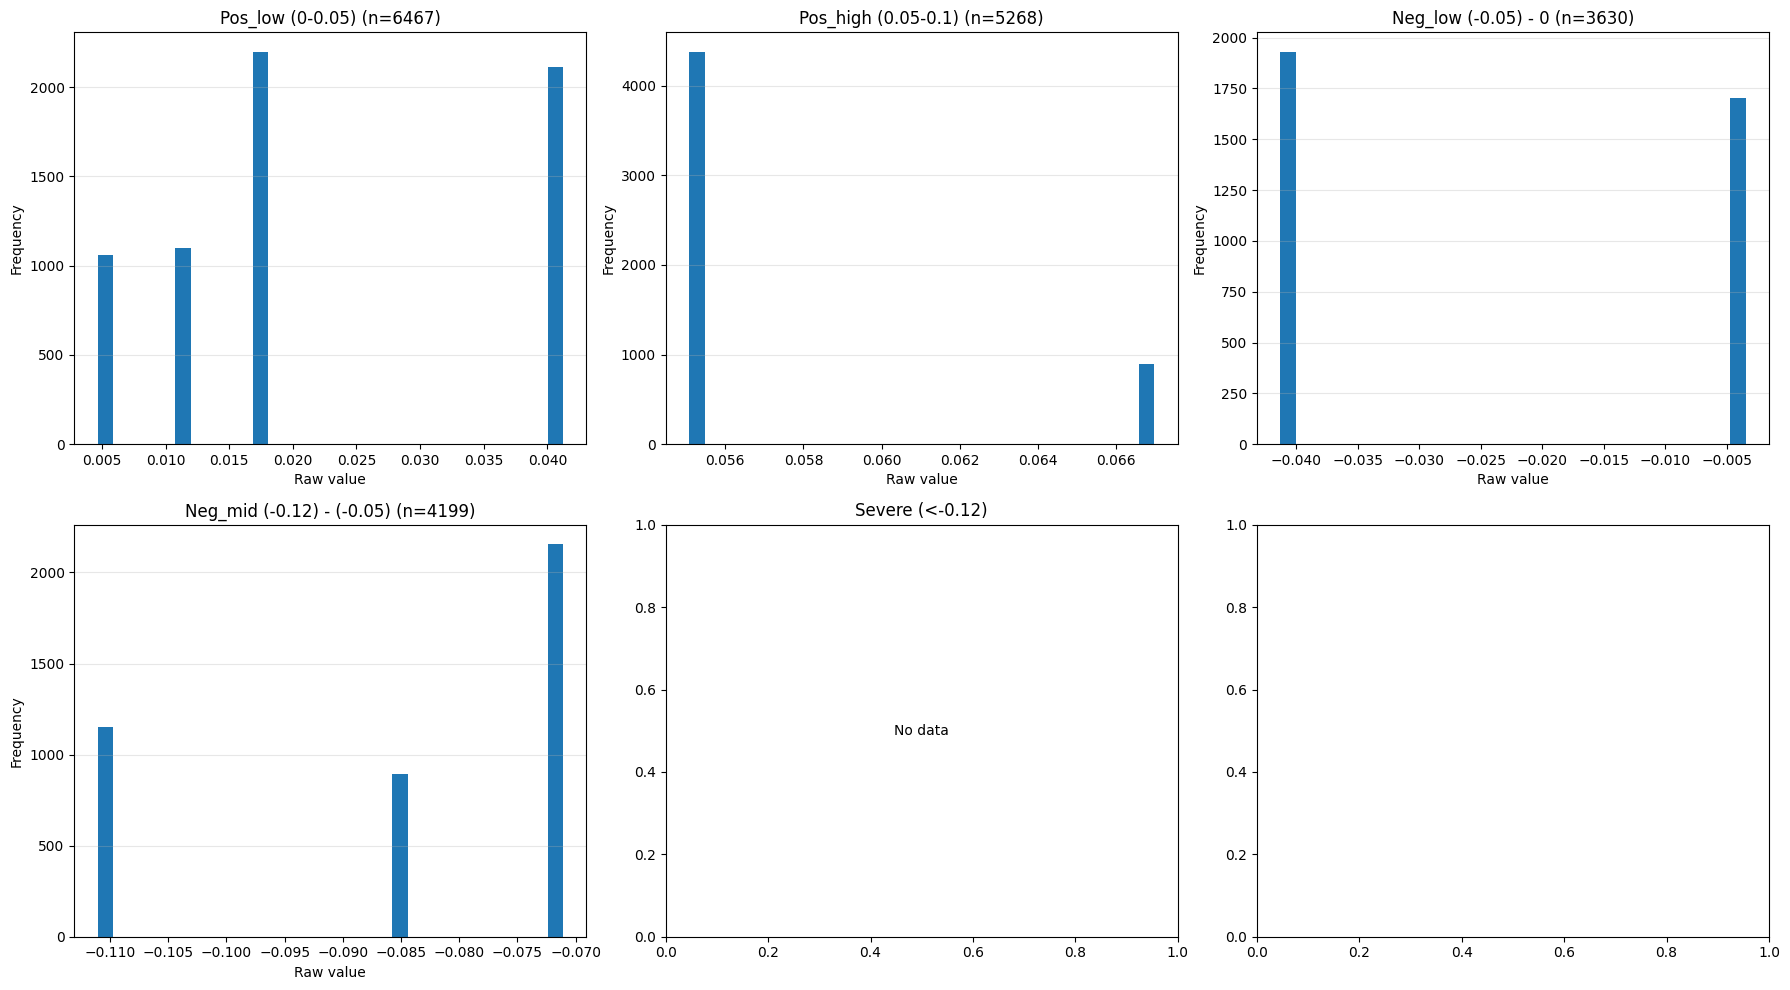

In [49]:
# --- NEW: Distributions using ONLY tset_keep ---

# 1) Collect FP raw values by severity (collapse across pred brackets)
severity_raws = {cat: [] for cat in SEVERITY_CATS}

for m in tset_keep:
    raw_map = m.get("fp_severity_by_bracket_raw_vals", {})  # {"0.5-0.7": {cat:[...]}, "0.7-1.0": {...}}
    for br_map in raw_map.values():                          # iterate both brackets (if present)
        for cat in SEVERITY_CATS:
            vals = br_map.get(cat, [])
            if vals:
                severity_raws[cat].extend(vals)


# 3) Plot: one histogram per severity + one for TP raws
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
axes2 = axes2.flatten()

# Severities (5 plots)
for i, cat in enumerate(SEVERITY_CATS):
    data = severity_raws[cat]
    ax = axes2[i]
    if data:
        ax.hist(data, bins=30)
        ax.set_title(f"{cat} (n={len(data)})")
        ax.set_xlabel("Raw value"); ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.3, axis='y')
    else:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(cat)


plt.tight_layout()
plt.show()


---
# Testing and Older Funcs 
---